In [76]:
import numpy as np
import matplotlib.pyplot as plt
import pyhmc as phmc
import scipy.linalg as la
import os

from scipy.optimize import curve_fit

from iminuit import Minuit

Nt=8
w, h = 3, Nt
n_smear = 5
n_op = 4
#n_meas =8000

def E_mass(L,mass):
    return np.arccosh(np.cosh(mass) + 1 -np.cos( 2*np.pi/L) )

def corr_th(x, a,b,c,d):
    #E= np.arccosh(2 - np.cos(2*np.pi/Nt))
    return a * np.cosh((x-Nt/2)*b) + c*np.cosh((x-Nt/2)*d)

def corr_s(x, a,b):
    #E= np.arccosh(2 - np.cos(2*np.pi/Nt))
    return a * np.cosh((x-Nt/2)*b)

def variational_analysis(kappa,eigen, eigen_err):
    avg = [0 for i in range(n_smear*n_op)]
    err = [0 for i in range(n_smear*n_op)]
    c_mat = [[0 for i in range(n_smear*n_op) ]for j in range(n_smear*n_op) ]
    c_mat0 = [[0 for i in range(n_smear*n_op) ]for j in range(n_smear*n_op) ]
    c_plus = [[0 for i in range(n_smear*n_op) ]for j in range(n_smear*n_op) ]
    c_minus = [[0 for i in range(n_smear*n_op) ]for j in range(n_smear*n_op) ]
    avg_np= np.loadtxt('cross_new/matrix_c_L%d_k%f.txt' %(Nt,kappa))
    avg_np=avg_np.reshape(Nt,n_smear*n_op,n_smear*n_op)
    err_np= np.loadtxt('cross_new/matrix_c_L%d_k%f_err.txt' %(Nt,kappa))
    err_np=err_np.reshape(Nt,n_smear*n_op,n_smear*n_op)
    
    for t in range(Nt):
        eigen.append([])
        eigen_err.append([])
        for i in range(n_smear*n_op):
            for j in range(n_smear*n_op):
                if t == 0:
                    c_mat0[i][j] = avg_np[t][i][j]
                c_mat[i][j] = avg_np[t][i][j]
                c_plus[i][j] = avg_np[t][i][j] + err_np[t][i][j]
                c_minus[i][j] = avg_np[t][i][j] - err_np[t][i][j]
        
        v,w = la.eig(c_mat,b=c_mat0)
        p,l = la.eig(c_plus,b=c_mat0)
        m,r = la.eig(c_minus,b=c_mat0)
        if t>0:
            v[::-1].sort()
            p[::-1].sort()
            m[::-1].sort()
        for i in range(n_op*n_smear):
            if p[i].real > v[i].real and p[i].real > m[i].real:
                if v[i].real > m[i].real:
                    avg[i] = v[i].real
                    err[i] = (p[i].real - m[i].real)/2
                if m[i].real > v[i].real:
                    avg[i] = m[i].real
                    err[i] = (p[i].real -v[i].real)/2
            if v[i].real > p[i].real and v[i].real > m[i].real:
                if p[i].real > m[i].real:
                    avg[i] = p[i].real
                    err[i] = (v[i].real - m[i].real)/2
                if m[i].real > p[i].real:
                    avg[i] = m[i].real
                    err[i] = (v[i].real -p[i].real)/2
            if m[i].real > v[i].real and m[i].real > p[i].real:
                if v[i].real > p[i].real:
                    avg[i] = v[i].real
                    err[i] = (m[i].real - p[i].real)/2
                if p[i].real > v[i].real:
                    avg[i] = p[i].real
                    err[i] = (m[i].real - v[i].real)/2
            eigen[t].append(avg[i])
            eigen_err[t].append(err[i])


def variational_analysis4(kappa,eigen, eigen_err,n_s):
    avg = [0 for i in range(4)]
    err = [0 for i in range(4)]
    index =[n_s,n_s+n_smear,n_s+n_smear*2,n_s+n_smear*3]
    c_mat = [[0 for i in range(4) ]for j in range(4) ]
    c_mat0 = [[0 for i in range(4) ]for j in range(4) ]
    c_plus = [[0 for i in range(4) ]for j in range(4) ]
    c_minus = [[0 for i in range(4) ]for j in range(4) ]
    avg_np= np.loadtxt('cross_new/matrix_c_L%d_k%f.txt' %(Nt,kappa))
    avg_np=avg_np.reshape(Nt,n_smear*n_op,n_smear*n_op)
    err_np= np.loadtxt('cross_new/matrix_c_L%d_k%f_err.txt' %(Nt,kappa))
    err_np=err_np.reshape(Nt,n_smear*n_op,n_smear*n_op)
    
    for t in range(Nt):
        eigen.append([])
        eigen_err.append([])
        eigen_plus.append([])
        eigen_minus.append([])
        for i in range(4):
            for j in range(4):
                if t == 0:
                    c_mat0[i][j] = avg_np[t][index[i]][index[j]]
                c_mat[i][j] = avg_np[t][index[i]][index[j]]
                c_plus[i][j] = avg_np[t][index[i]][index[j]] + err_np[t][index[i]][index[j]]
                c_minus[i][j] = avg_np[t][index[i]][index[j]] - err_np[t][index[i]][index[j]]
                '''
        with open('cross/matrix_3_L%d_k%f_ns%d_t%d.txt' %(Nt,kappa,n_s,t),'w')  as outfile:
            with open('cross/matrix_3_L%d_k%f_ns%d_t%d_plus.txt'%(Nt,kappa,n_s,t),'w') as plusfile:
                with open('cross/matrix_3_L%d_k%f_ns%d_t%d_minus.txt'%(Nt,kappa,n_s,t),'w') as minusfile:
                    np.savetxt(outfile ,c_mat,fmt='%.6f')
                    #outfile.write('# New time slice\n')
                    np.savetxt(plusfile ,c_plus,fmt='%.6f')
                    #plusfile.write('# New time slice\n')
                    np.savetxt(minusfile ,c_minus,fmt='%.6f')   
                    '''
        v,w = la.eig(c_mat,b=c_mat0)
        p,l = la.eig(c_plus,b=c_mat0)
        m,r = la.eig(c_minus,b=c_mat0)
        if t>0:
            v[::-1].sort()
            p[::-1].sort()
            m[::-1].sort()
        for i in range(4):
            if p[i].real > v[i].real and p[i].real > m[i].real:
                if v[i].real > m[i].real:
                    avg[i] = v[i].real
                    err[i] = (p[i].real - m[i].real)/2
                if m[i].real > v[i].real:
                    avg[i] = m[i].real
                    err[i] = (p[i].real -v[i].real)/2
            if v[i].real > p[i].real and v[i].real > m[i].real:
                if p[i].real > m[i].real:
                    avg[i] = p[i].real
                    err[i] = (v[i].real - m[i].real)/2
                if m[i].real > p[i].real:
                    avg[i] = m[i].real
                    err[i] = (v[i].real -p[i].real)/2
            if m[i].real > v[i].real and m[i].real > p[i].real:
                if v[i].real > p[i].real:
                    avg[i] = v[i].real
                    err[i] = (m[i].real - p[i].real)/2
                if p[i].real > v[i].real:
                    avg[i] = p[i].real
                    err[i] = (m[i].real - v[i].real)/2
            eigen[t].append(avg[i])
            eigen_err[t].append(err[i])
            eigen_plus[t].append(plus[i])
            eigen_minus[t].append(minus[i])
            
def variational_analysis3(kappa,eigen, eigen_err,n_s,n2):
    avg = [0 for i in range(4)]
    err = [0 for i in range(4)]
    index =[n_s,n_s+5,n_s+10,n_s+15]
    c_mat0 = [[0 for i in range(4) ]for j in range(4) ]
    #eigen_err = [0 for t in range(Nt)]
    #c_plus0 = [[0 for i in range(n_smear*n_op) ]for j in range(n_smear*n_op) ]
    #c_minus0 = [[0 for i in range(n_smear*n_op) ]for j in range(n_smear*n_op) ]
    avg_np= np.loadtxt('cross_new/matrix_c_L%d_k%f.txt' %(Nt,kappa))
    avg_np=avg_np.reshape(Nt,n_smear*n_op,n_smear*n_op)
    #print(avg)
    err_np= np.loadtxt('cross_new/matrix_c_L%d_k%f_err.txt' %(Nt,kappa))
    err_np=err_np.reshape(Nt,n_smear*n_op,n_smear*n_op)
    
    for t in range(Nt):
        c_mat = [[0 for i in range(4) ]for j in range(4) ]
        c_plus = [[0 for i in range(4) ]for j in range(4) ]
        c_minus = [[0 for i in range(4) ]for j in range(4) ]
        eigen.append([])
        eigen_err.append([])
        eigen_plus.append([])
        eigen_minus.append([])
        for i in range(4):
            for j in range(4):
                if t == 0:
                    #c_mat0[i][j] = c_mat[0][i][j][t]
                    c_mat0[i][j] = avg_np[t][index[i]][index[j]]
                    #c_plus0[i][j] = c_res[0][i][j][t] + c_res[1][i][j][t]
                    #c_minus0[i][j] = c_res[0][i][j][t] - c_res[1][i][j][t]
                c_mat[i][j] = avg_np[t][index[i]][index[j]]
                #c_mat_err[i][j] = c_res[1][i][j][t]
                c_plus[i][j] = avg_np[t][index[i]][index[j]] + err_np[t][index[i]][index[j]]
                c_minus[i][j] = avg_np[t][index[i]][index[j]] - err_np[t][index[i]][index[j]]
    
        #print('t= '+str(t)+str(check_symmetric(c_mat)))
        #print(c_mat)
        [j.pop(n2) for j in c_mat]
        c_mat.pop(n2)
        if t == 0:
            [j.pop(n2) for j in c_mat0]
            c_mat0.pop(n2)
        [j.pop(n2) for j in c_plus]
        c_plus.pop(n2)
        [j.pop(n2) for j in c_minus]
        c_minus.pop(n2)
        '''
        with open('cross/matrix_4_L%d_k%f_ns%d_n%d_t%d.txt' %(Nt,kappa,n_s,n2,t),'w')  as outfile:
            with open('cross/matrix_4_L%d_k%f_ns%d_n%d_t%d_plus.txt'%(Nt,kappa,n_s,n2,t),'w') as plusfile:
                with open('cross/matrix_4_L%d_k%f_ns%d_n%d_t%d_minus.txt'%(Nt,kappa,n_s,n2,t),'w') as minusfile:
                    np.savetxt(outfile ,c_mat,fmt='%.6f')
                    #outfile.write('# New time slice\n')
                    np.savetxt(plusfile ,c_plus,fmt='%.6f')
                    #plusfile.write('# New time slice\n')
                    np.savetxt(minusfile ,c_minus,fmt='%.6f')
        '''
        v,w = la.eig(c_mat,b=c_mat0)
        p,l = la.eig(c_plus,b=c_mat0)
        m,r = la.eig(c_minus,b=c_mat0)
        if t >0:
            v[::-1].sort()
            p[::-1].sort()
            m[::-1].sort()
        #print('v = ',v)
        #print('p = ',p)
        #print('m = ',m)
        for i in range(3):
            if p[i].real > v[i].real and p[i].real > m[i].real:
                if v[i].real > m[i].real:
                    avg[i] = v[i].real
                    err[i] = (p[i].real - m[i].real)/2
                if m[i].real > v[i].real:
                    avg[i] = m[i].real
                    err[i] = (p[i].real -v[i].real)/2
            if v[i].real > p[i].real and v[i].real > m[i].real:
                if p[i].real > m[i].real:
                    avg[i] = p[i].real
                    err[i] = (v[i].real - m[i].real)/2
                if m[i].real > p[i].real:
                    avg[i] = m[i].real
                    err[i] = (v[i].real -p[i].real)/2
            if m[i].real > v[i].real and m[i].real > p[i].real:
                if v[i].real > p[i].real:
                    avg[i] = v[i].real
                    err[i] = (m[i].real - p[i].real)/2
                if p[i].real > v[i].real:
                    avg[i] = p[i].real
                    err[i] = (m[i].real - v[i].real)/2
            eigen[t].append(avg[i])
            eigen_err[t].append(err[i])
            eigen_plus[t].append(plus[i])
            eigen_minus[t].append(minus[i])
        #print('Eigenvalue problem solved without the operator',n2)
        #print(t,'Eigenvalues: ',eigen[t], 'Errors: ',eigen_err[t])
    #print(eigen)

def plot_energy_var(kappa,Eigen,Eigen_err,n_eigen,n_s,n1,n2):
    Tm = list(range(Nt-1))
    T= list(range(Nt))
    C = list(range(Nt))
    C_err = list(range(Nt))

    corr_=list(range(Nt))
    corr2_th=list(range(Nt))
    corr_m=list(range(Nt))
    
    
    E_p= list(range(Nt-1))
    E_p2= list(range(Nt-1))
    E_m=list(range(Nt-1))
    E_c = 2*np.pi/Nt
    E_l= np.arccosh(2-np.cos(E_c))
    E_l2= np.arccosh(2-np.cos(2*E_c))
    x = np.arange(Nt-1)
    xdata = np.linspace(0,Nt-1,50)

    for t in range(Nt-1):
        E_p[t]=np.log(np.cosh(E_l*(t-Nt/2))/np.cosh(E_l*(t+1-Nt/2)))
        corr_[t]= np.cosh(E_l*(t-Nt/2))/ np.cosh(E_l*(-Nt/2))
        corr2_th[t]= np.cosh(E_l2*(t-Nt/2))/ np.cosh(E_l2*(-Nt/2))

        
        E_p2[t]=np.log(np.cosh(E_l2*(t-Nt/2))/np.cosh(E_l2*(t+1-Nt/2)))
        if kappa == 0.55:
            E_m[t] =np.log(np.cosh(E_mass(Nt,0.5)*(t-Nt/2))/np.cosh(E_mass(Nt,0.5)*(t+1-Nt/2)))
            corr_m[t]= np.cosh(E_mass(Nt,0.5)*(t-Nt/2))/np.cosh(E_mass(Nt,0.5)*(-Nt/2))
        if kappa == 0.65:
            E_m[t] =np.log(np.cosh(E_mass(Nt,1)*(t-Nt/2))/np.cosh(E_mass(Nt,1)*(t+1-Nt/2)))
            corr_m[t]= np.cosh(E_mass(Nt,1)*(t-Nt/2))/np.cosh(E_mass(Nt,1)*(-Nt/2))
        
        
    for ns in range(n_eigen):
        E = list(range(Nt-1))
        E_unc = list(range(Nt-1))
        for t in range(Nt):
            C[t] = np.array(Eigen[t][ns])
            C_err[t] = np.array(Eigen_err[t][ns])
        for t in range(Nt-1):
            Tm[t] = t +0.5
            E[t] = np.log(C[t]/C[t+1])
            E_unc[t] = np.sqrt( (C_err[t]/C[t])**2 + (C_err[t+1]/C[t+1])**2 )
            #if E_unc[t] > np.abs(E[t]):
            #    E[t] = np.log(-1)
                
        #C_fit=np.array(C)
        #print('E(before)=',E)
        
        #C_fit_err=np.array(C_err)
        #print(E_unc)
        t=np.linspace(0,Nt-2,Nt-1)
        T=np.linspace(0,Nt-1,Nt)
        #print('t(before)=',t)
        for i in range(Nt-2,-1,-1):
            if E_unc[i] > np.abs(E[i]):
                E=np.delete(E,i)
                E_unc=np.delete(E_unc,i)
                t=np.delete(t,i)
        E=np.delete(E,0)
        E_unc=np.delete(E_unc,0)
        t=np.delete(t,0)
        t=t+0.5
        #print('t(after)=',t)
        #print('E(after)=',E)

        def least_squares(a, b,c,d):
            return sum((E - np.log(corr_th(t, a, b,c,d)/corr_th(t+1, a, b,c,d) )) ** 2 / (E_unc*E_unc))
        
        def least_s(a, b):
            return sum((E - np.log(corr_s(t, a, b)/corr_s(t+1, a, b) )) ** 2 / (E_unc*E_unc))

        def least_c(a, b):
            print(sum((C - corr_s(T, a, b))** 2 / (C_err*C_err)))
            return sum((C - corr_s(T, a, b))** 2 / (C_err*C_err))
        
        
        #C_fit.pop(0)
        #C_fit_err.pop(0)
        #with open('O1minus/Energy/var%d/effective_energy_L%d_k%f_sm%d_n1_%d_n2_%d_lv%d.dat'% (n_eigen,Nt,kappa,n_s,n1,n2,ns),'w') as f:
        #    for t in list(range(Nt-1)):
        #        f.write(str(Tm[t])+" ")
        #        f.write(str(E[t])+" ")
        #        f.write(str(float(E_unc[t]))+"\n")
        '''
        plt.figure(num=None, figsize=(8, 6), dpi=160, facecolor='w', edgecolor='k')

        
        try:
            #popt, pcov = curve_fit(corr_th, T, C,sigma = C_err, absolute_sigma = True,bounds =([0.0001,0,0,0],[4.0,2,1,6]))
            #plt.plot(xdata +0.5, np.log(corr_th(xdata, *popt)/corr_th(xdata +1, *popt)),label=r'fit, $E_1 = %f\pm %f, E_2= %f \pm %f$' %(popt[1],np.sqrt(pcov[1][1]),popt[3],np.sqrt(pcov[3][3])))
            
            #m = Minuit(least_squares,a=1,b=0.5,c=0.1,d=1,error_a=0.1,error_b=0.05,error_c=0.01,error_d=0.1,limit_a=(0,10),limit_b=(0,2),limit_c=(0,10),limit_d=(0,5),errordef=0.5)
            m = Minuit(least_c,a=1,b=0.5,error_a=0.1,error_b=0.05,limit_a=(0,10),limit_b=(0,3),errordef=0.5)
            m.migrad()
            print(m.args)
            print(m.errors)
            plt.plot(xdata, corr_s(xdata, *m.args),label=r'fit, $E=%f \pm %f$'%(m.args[1],m.errors[1]))

        except RuntimeError:
            print("Error - curve_fit failed")
        
        
        plt.errorbar(T, C,C_err,fmt='o',label='data')
        plt.plot(T,corr_,label='$corr_E$')
        plt.plot(T,corr2_th,label='$corr_{2E}$')
        if kappa == 0.55 or kappa == 0.65:
            plt.plot(T,corr_m,label='$corr_{m}$')
        
        plt.yscale("log")
        plt.xlim([0,Nt/2+0.5])
        plt.legend()
        
        if n_eigen == n_smear*n_op:
            plt.title(r"Correlator eigenvalue %d, L=%d ($\beta=4, \kappa=%f, \lambda=1 $)" % (ns,Nt,kappa))
            plt.savefig('O1minus/Corr/var%d/correlator_L%d_k%f_lv%d.jpg'% (n_eigen,Nt,kappa,ns))
        if n_eigen == 20:
            plt.title(r"Correlator eigenvalue %d, L=%d ($\beta=4, \kappa=%f, \lambda=1 $)" % (ns,Nt,kappa))
            plt.savefig('O1minus/Corr/var%d/correlator_L%d_k%f_lv%d.jpg'% (n_eigen,Nt,kappa,ns))
        if n_eigen == 4:
            plt.title(r"Correlator eigenvalue %d smear %d, L=%d ($\beta=4, \kappa=%f, \lambda=1 $)" % (ns,n_s,Nt,kappa))
            plt.savefig('O1minus/Corr/var%d/correlator_L%d_k%f_sm%d_lv%d.jpg'% (n_eigen,Nt,kappa,n_s,ns))        
        if n_eigen == 3:
            plt.title(r"Correlator eigenvalue %d smear %d without %d, L=%d ($\beta=4, \kappa=%f, \lambda=1 $)" % (ns,n_s,n1,Nt,kappa))
            plt.savefig('O1minus/Corr/var%d/correlator_L%d_k%f_sm%d_n1_%d_lv%d.jpg'% (n_eigen,Nt,kappa,n_s,n1,ns))
        '''
        
        
        plt.figure(num=None, figsize=(8, 6), dpi=160, facecolor='w', edgecolor='k')
        try:
            #popt, pcov = curve_fit(corr_th, T, C,sigma = C_err, absolute_sigma = True,bounds =([0.0001,0,0,0],[4.0,2,1,6]))
            #plt.plot(xdata +0.5, np.log(corr_th(xdata, *popt)/corr_th(xdata +1, *popt)),label=r'fit, $E_1 = %f\pm %f, E_2= %f \pm %f$' %(popt[1],np.sqrt(pcov[1][1]),popt[3],np.sqrt(pcov[3][3])))
            
            #m = Minuit(least_squares,a=1,b=0.5,c=0.1,d=1,error_a=0.1,error_b=0.05,error_c=0.01,error_d=0.1,limit_a=(0,10),limit_b=(0,2),limit_c=(0,10),limit_d=(0,5),errordef=0.5)
            m = Minuit(least_s,a=1,b=0.5,error_a=0.1,error_b=0.05,limit_a=(0,10),limit_b=(0,3),errordef=0.5)
            m.migrad()
            print('averages =',*m.args)
            print('errors =',list(m.np_errors()))
            arg=m.np_values()
            errs=m.np_errors()
            pl= arg+errs
            mn=arg-errs
            print(arg)
            plt.plot(xdata +0.5, np.log(corr_s(xdata, *m.args)/corr_s(xdata +1, *m.args)),label=r'fit, $E=%f $'%(m.args[1]))
            plt.plot(xdata +0.5, np.log(corr_s(xdata, pl[0],pl[1])/corr_s(xdata +1,pl[0],pl[1])),label=r'fit+, $E=%f$'%(pl[1]))
            plt.plot(xdata +0.5, np.log(corr_s(xdata, mn[0],mn[1])/corr_s(xdata +1,mn[0],mn[1])),label=r'fit-, $E=%f$'%(mn[1]))

            
        except RuntimeError:
            print("Error - curve_fit failed")

        plt.errorbar(t, E,E_unc,fmt='o',label='data')
        plt.plot(x+0.5,E_p,label='$E_{th}$')
        plt.plot(x+0.5,E_p2,label='$E2_{th}$')
        #if kappa == 0.55 or kappa == 0.65:
        #    plt.plot(x+0.5,E_m,label='$E_{m}$')
        plt.xlabel("t/a")
        plt.ylabel("a E(t)")
        #plt.yscale("log")
        plt.legend()
        plt.xlim([0.5,Nt/2+1])
        #plt.ylim([-0.5,1.0])
        #print(n_eigen)
        if n_eigen == n_smear*n_op:
            plt.title(r"Effective energy eigenvalue %d, L=%d ($\beta=4, \kappa=%f, \lambda=1 $)" % (ns,Nt,kappa))
            plt.savefig('O1minus/Energy_2/var%d/effective_energy_L%d_k%f_lv%d.jpg'% (n_eigen,Nt,kappa,ns))
        if n_eigen == 20:
            plt.title(r"Effective energy eigenvalue %d, L=%d ($\beta=4, \kappa=%f, \lambda=1 $)" % (ns,Nt,kappa))
            plt.savefig('O1minus/Energy_2/var%d/effective_energy_L%d_k%f_lv%d.jpg'% (n_eigen,Nt,kappa,ns))
        if n_eigen == 4:
            plt.title(r"Effective energy eigenvalue %d smear %d, L=%d ($\beta=4, \kappa=%f, \lambda=1 $)" % (ns,n_s,Nt,kappa))
            plt.savefig('O1minus/Energy_2/var%d/effective_energy_L%d_k%f_sm%d_lv%d.jpg'% (n_eigen,Nt,kappa,n_s,ns))        
        if n_eigen == 3:
            plt.title(r"Effective energy eigenvalue %d smear %d without %d, L=%d ($\beta=4, \kappa=%f, \lambda=1 $)" % (ns,n_s,n1,Nt,kappa))
            plt.savefig('O1minus/Energy_2/var%d/effective_energy_L%d_k%f_sm%d_n1_%d_lv%d.jpg'% (n_eigen,Nt,kappa,n_s,n1,ns))
        if n_eigen == 2:
            plt.title(r"Effective energy eigenvalue %d smear %d without %d,%d, L=%d ($\beta=4, \kappa=%f, \lambda=1 $)" % (ns,n_s,n1,n2,Nt,kappa))
            #plt.savefig('O1minus/Energy_2/var%d/effective_energy_L%d_k%f_sm%d_n1_%d_n2_%d_lv%d.jpg'% (n_eigen,Nt,kappa,n_s,n1,n2,ns))
        
def var_analysis_plot(kappa):
    Eigen =[]
    Eigen_err=[]
    variational_analysis(kappa,Eigen,Eigen_err)
    plot_energy_var(kappa,Eigen,Eigen_err,n_smear*n_op,0,0,0)

def var_analysis_plot4(kappa,n_s):
    Eigen =[]
    Eigen_err=[]
    variational_analysis4(kappa,Eigen,Eigen_err,n_s)
    plot_energy_var(kappa,Eigen,Eigen_err,4,n_s,0,0)

def var_analysis_plot3(kappa,ns,n1):
    Eigen =[]
    Eigen_err=[]
    variational_analysis3(kappa,Eigen,Eigen_err,ns,n1)
    #print(Eigen)
    plot_energy_var(kappa,Eigen,Eigen_err,3,ns,n1,0)

averages = 1.0000000000009535 0.7637115327048603
errors = [5.631210132450315, 0.001581545353840419]
[1.         0.76371153]
averages = 1.1985024912034192 1.1765646771172626
errors = [5.402844653946715, 0.0018580598501803935]
[1.19850249 1.17656468]
averages = 0.9979917154449425 0.826439651106171
errors = [5.208632179134575, 0.004825053434326043]
[0.99799172 0.82643965]
averages = 0.9999999999987114 1.6288004415590158
errors = [0.0, 0.0]
[1.         1.62880044]
averages = 1.0663977551656418 0.4999999999999999
errors = [2.597239879543968, nan]
[1.06639776 0.5       ]
averages = 1.0000000000002185 1.8327647974878913
errors = [5.314878446491204, 0.023762386432295335]
[1.        1.8327648]
averages = 0.9588866889759401 1.8009423342236563
errors = [5.251279454829883, 0.016331215564256207]
[0.95888669 1.80094233]
averages = 1.0000000000000853 1.9391808935484653
errors = [5.206461228468082, 0.0405815256353983]
[1.         1.93918089]
averages = 1.0186961711185711 1.7482967077165334
errors = [0

/hosts/nashome/vaf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:283: RuntimeWarning: invalid value encountered in log


averages = nan nan
errors = [nan, nan]
[nan nan]
averages = nan nan
errors = [nan, nan]
[nan nan]
averages = nan nan
errors = [nan, nan]
[nan nan]
averages = nan nan
errors = [nan, nan]
[nan nan]
averages = nan nan
errors = [nan, nan]
[nan nan]
averages = nan nan
errors = [nan, nan]
[nan nan]


/hosts/nashome/vaf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:370: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


averages = nan nan
errors = [nan, nan]
[nan nan]
averages = nan nan
errors = [nan, nan]
[nan nan]
averages = 1.010034036232439 0.0007607155408745347
errors = [5.085554566199239, 0.41890474740170974]
[1.01003404e+00 7.60715541e-04]
averages = 0.9999999999999998 0.4392306161204326
errors = [0.0, 0.0]
[1.         0.43923062]
averages = 0.7977171928275123 0.9703796743499337
errors = [0.0, 0.0]
[0.79771719 0.97037967]
averages = 0.9999999999999998 0.7676395846546792
errors = [5.108393570570712, 0.0015530850198210988]
[1.         0.76763958]
averages = 0.99999999999487 1.349019990908115
errors = [5.498700260254922, 0.004442762957562074]
[1.         1.34901999]
averages = 0.9494323327770443 1.274147704590265
errors = [0.0, 0.0]
[0.94943233 1.2741477 ]
averages = 1.000000000001382 1.1400713648649416
errors = [8.172377025327844, 0.018089035474720183]
[1.         1.14007136]
averages = 0.9999999999998288 1.6806013901289834
errors = [5.206461228468358, 0.012510454086264167]
[1.         1.68060139

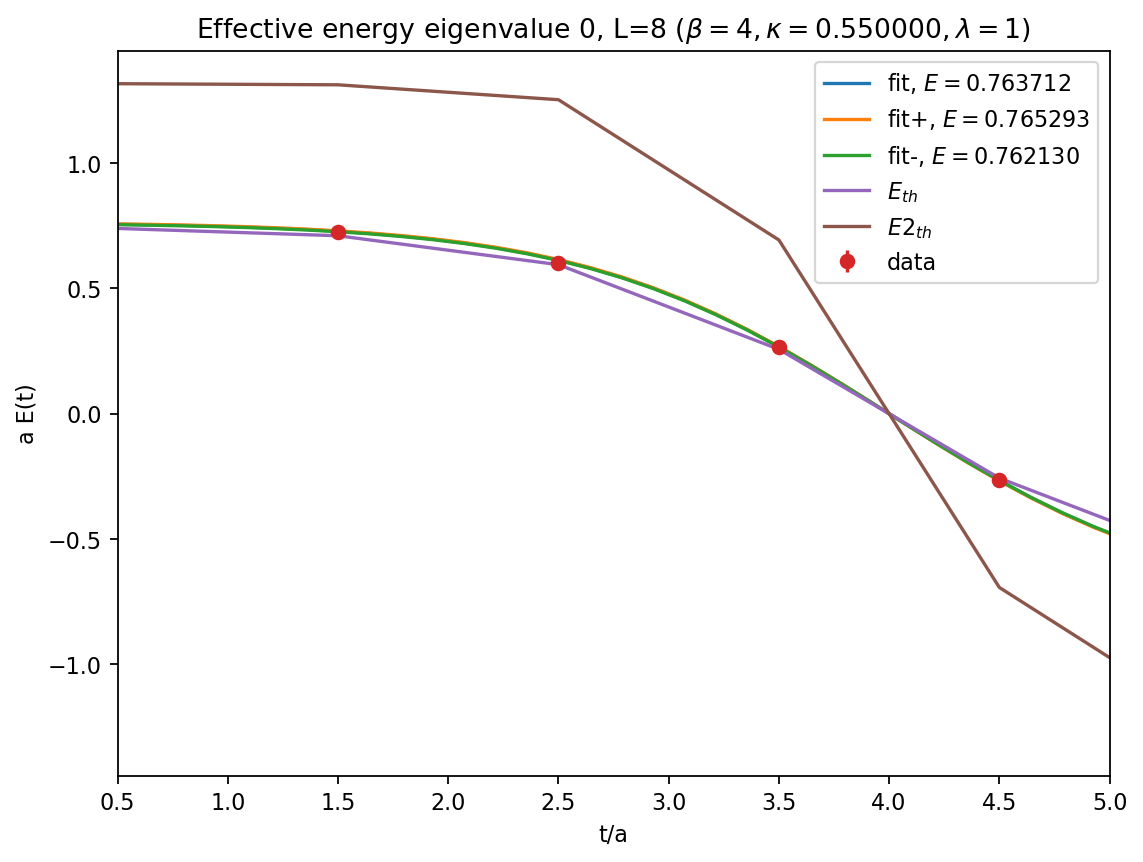

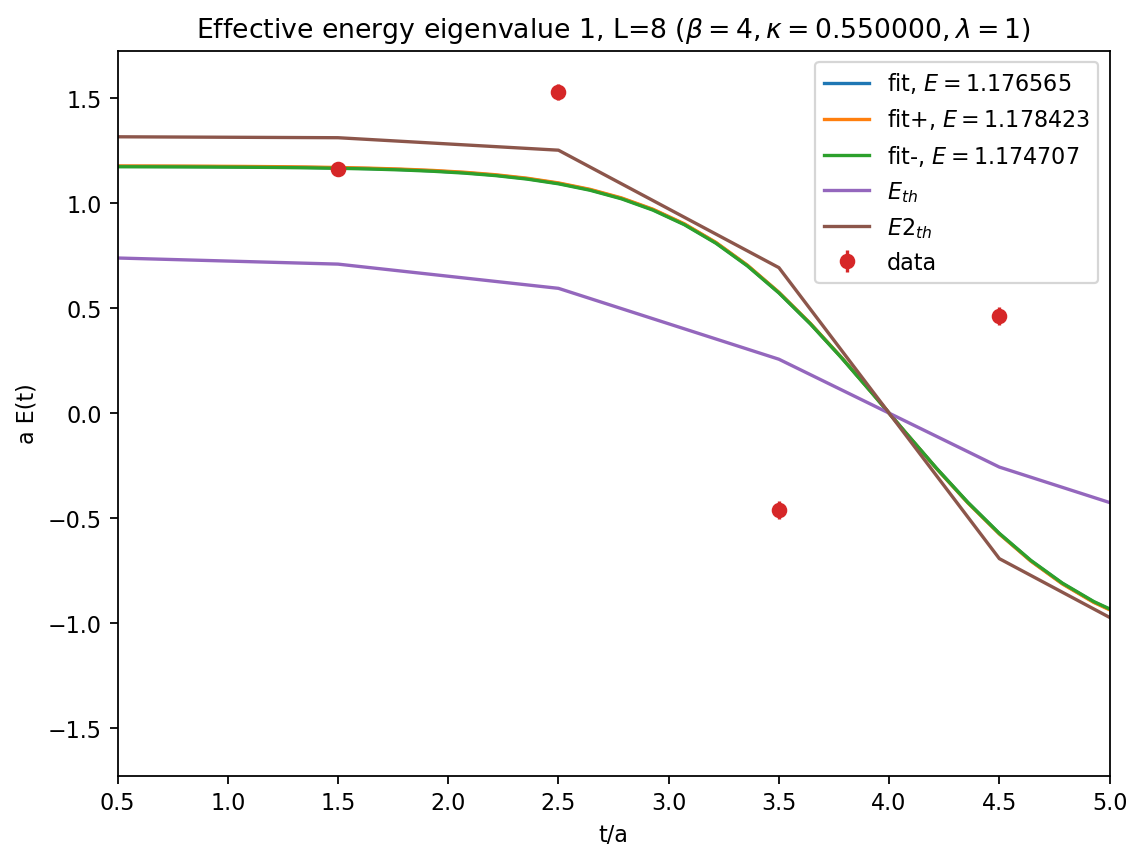

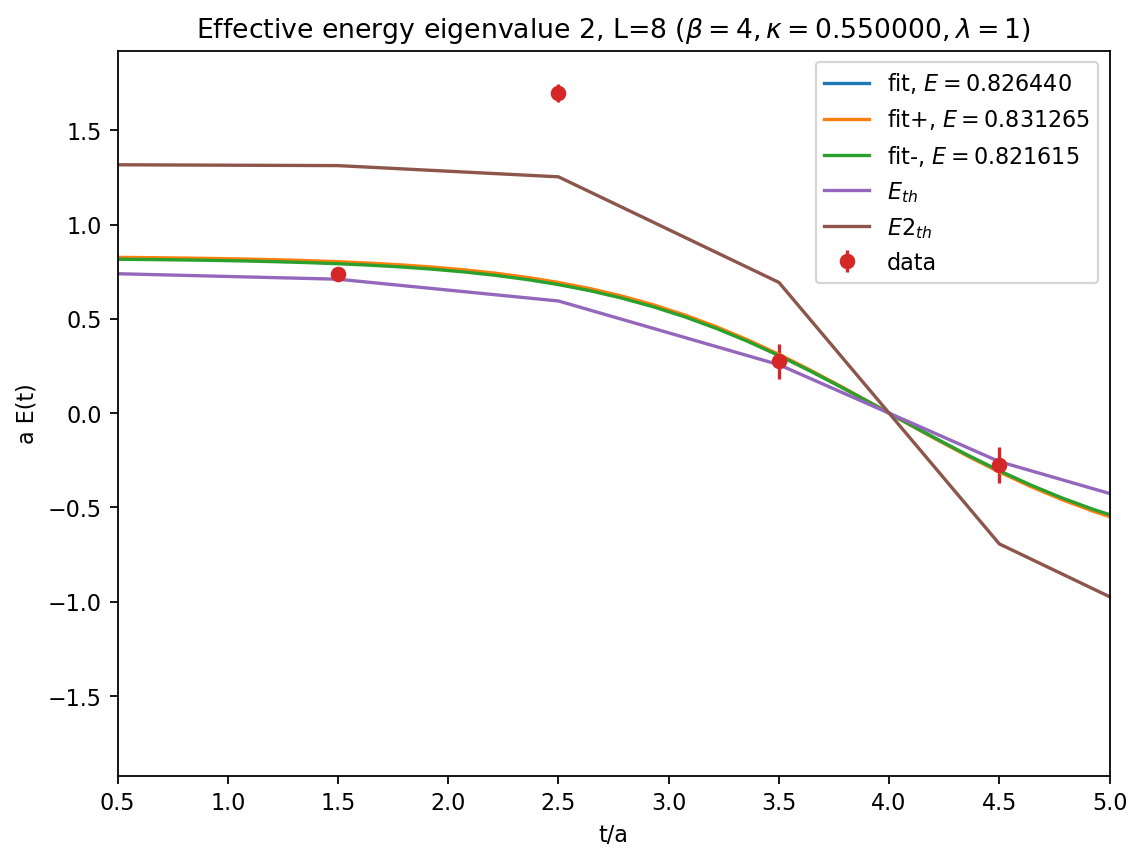

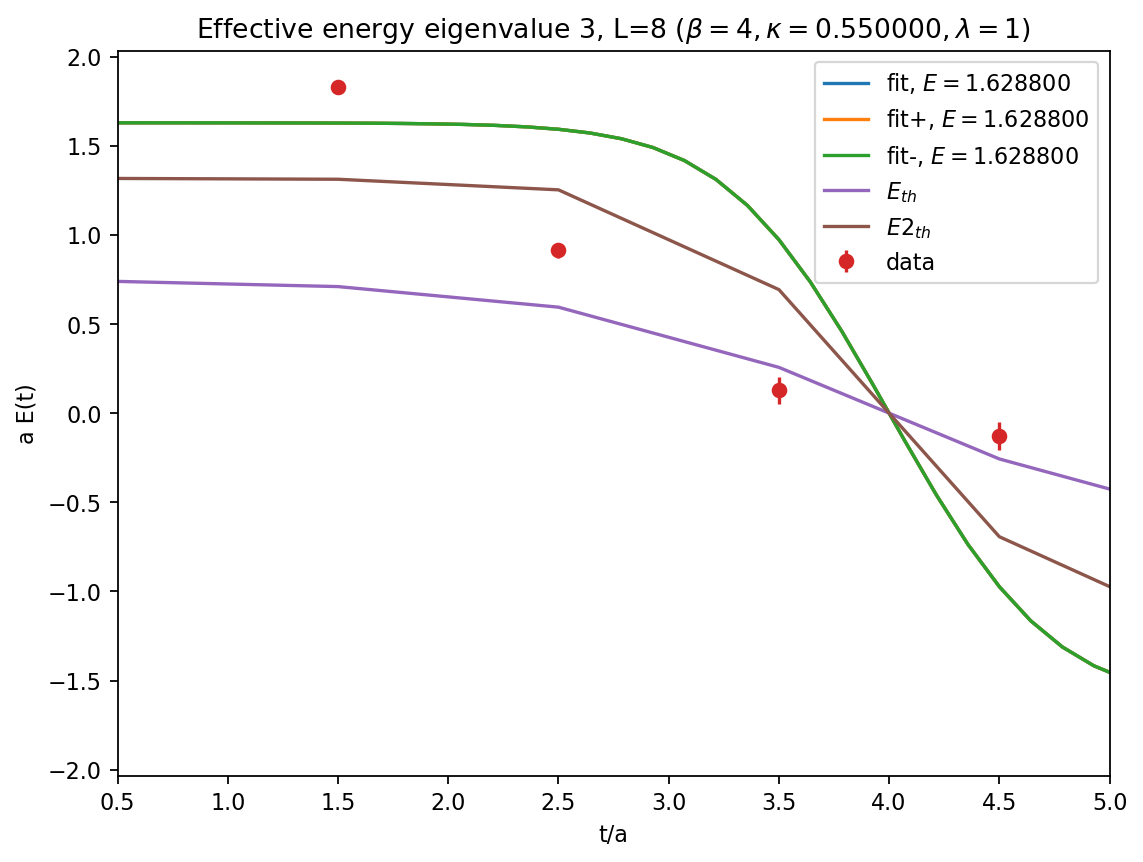

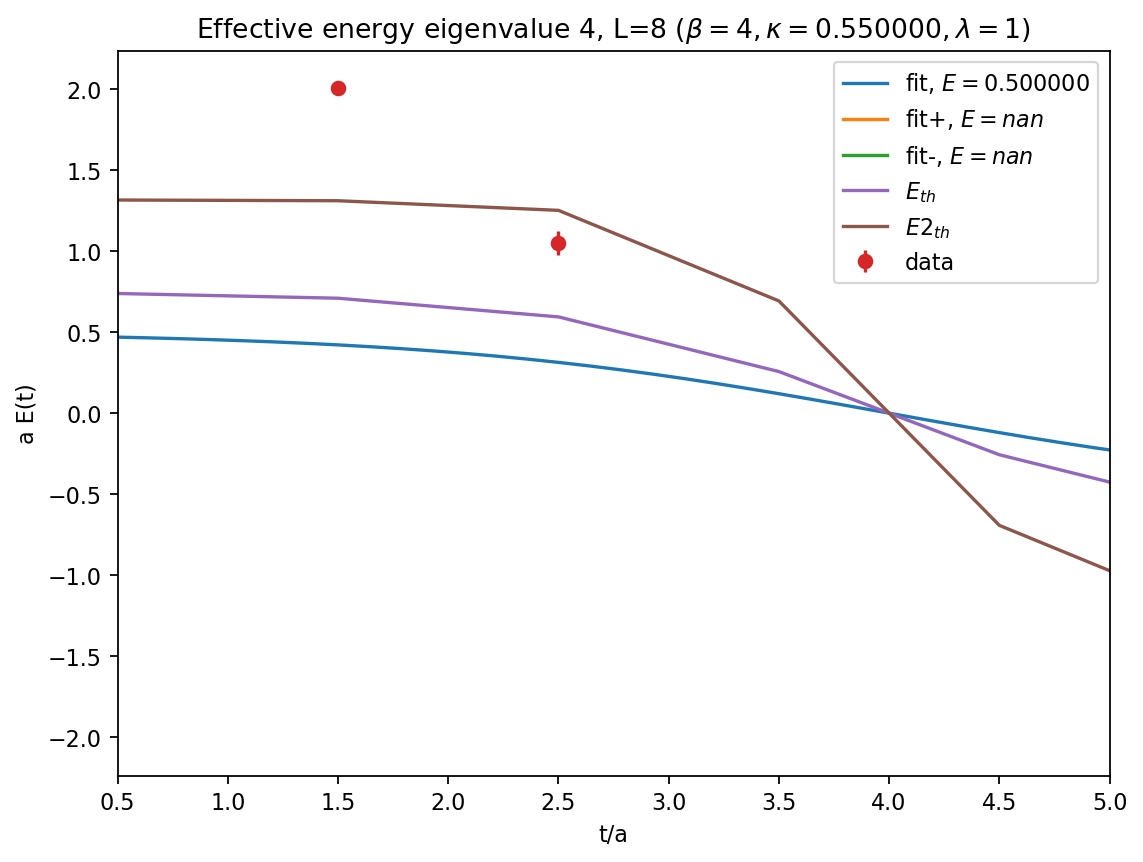

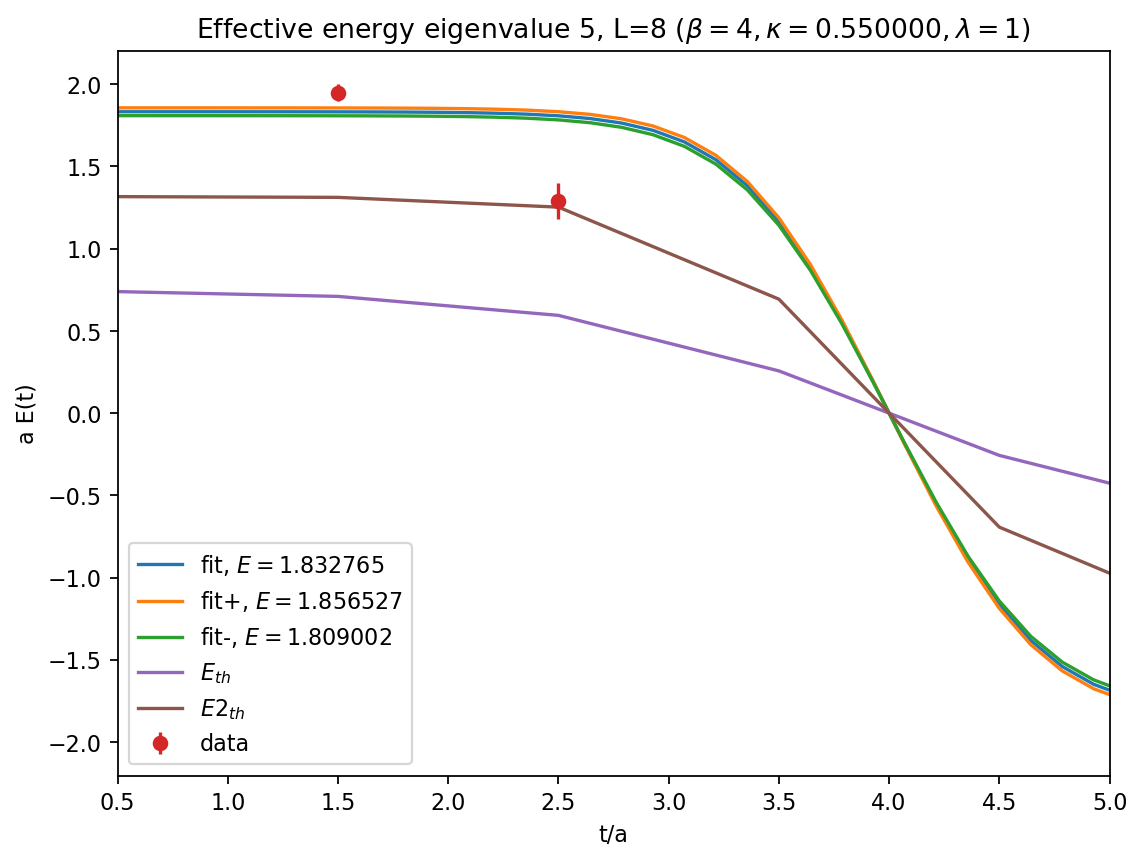

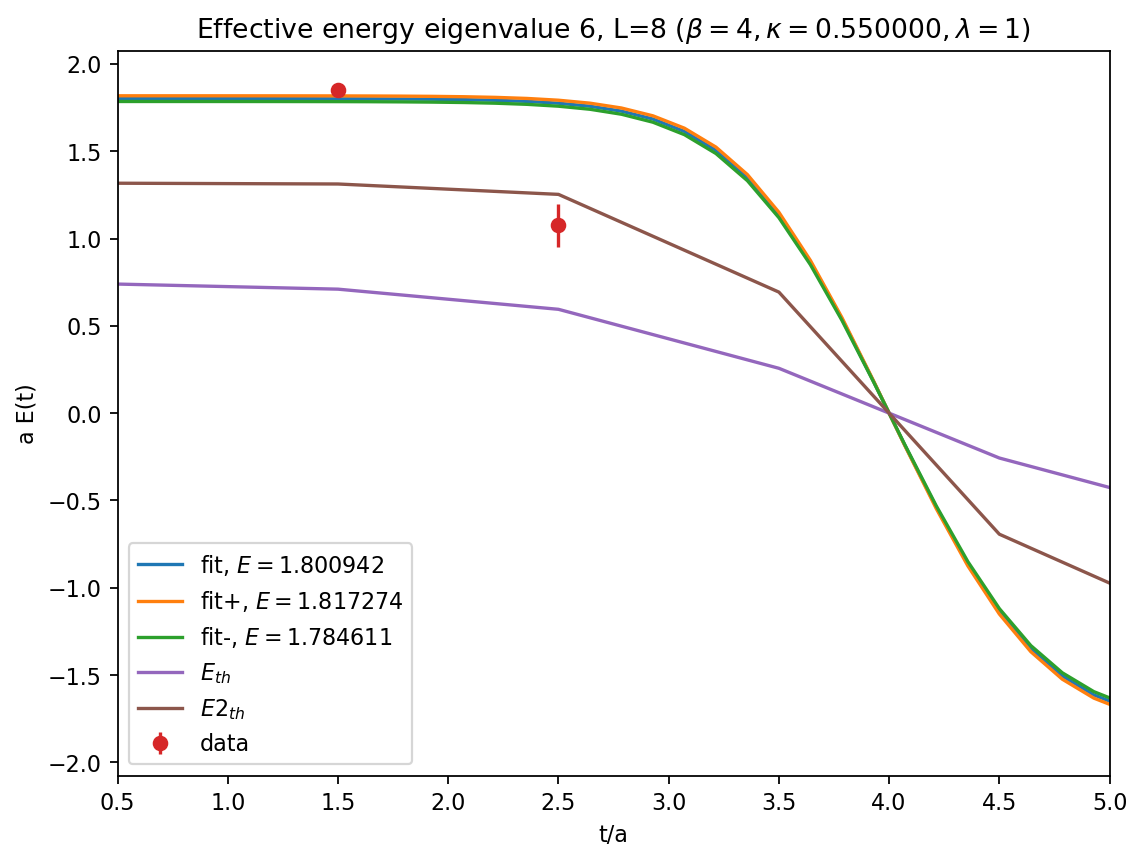

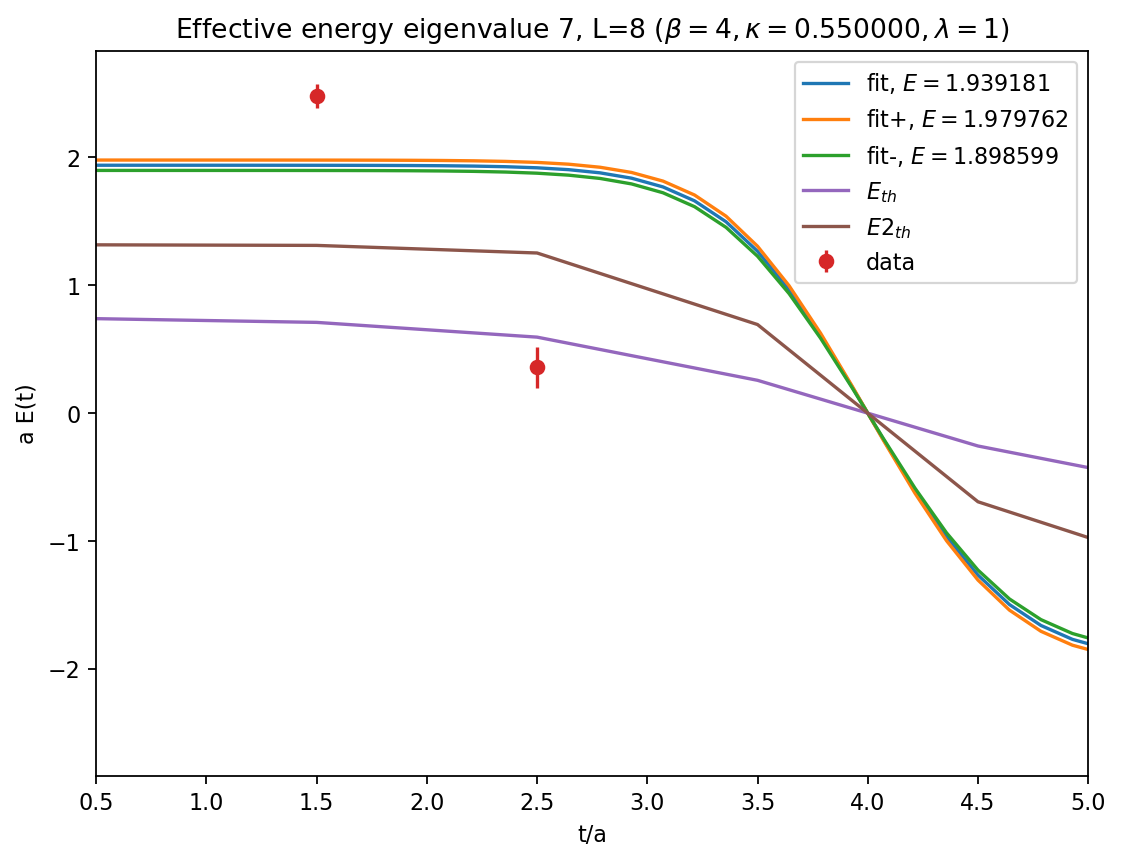

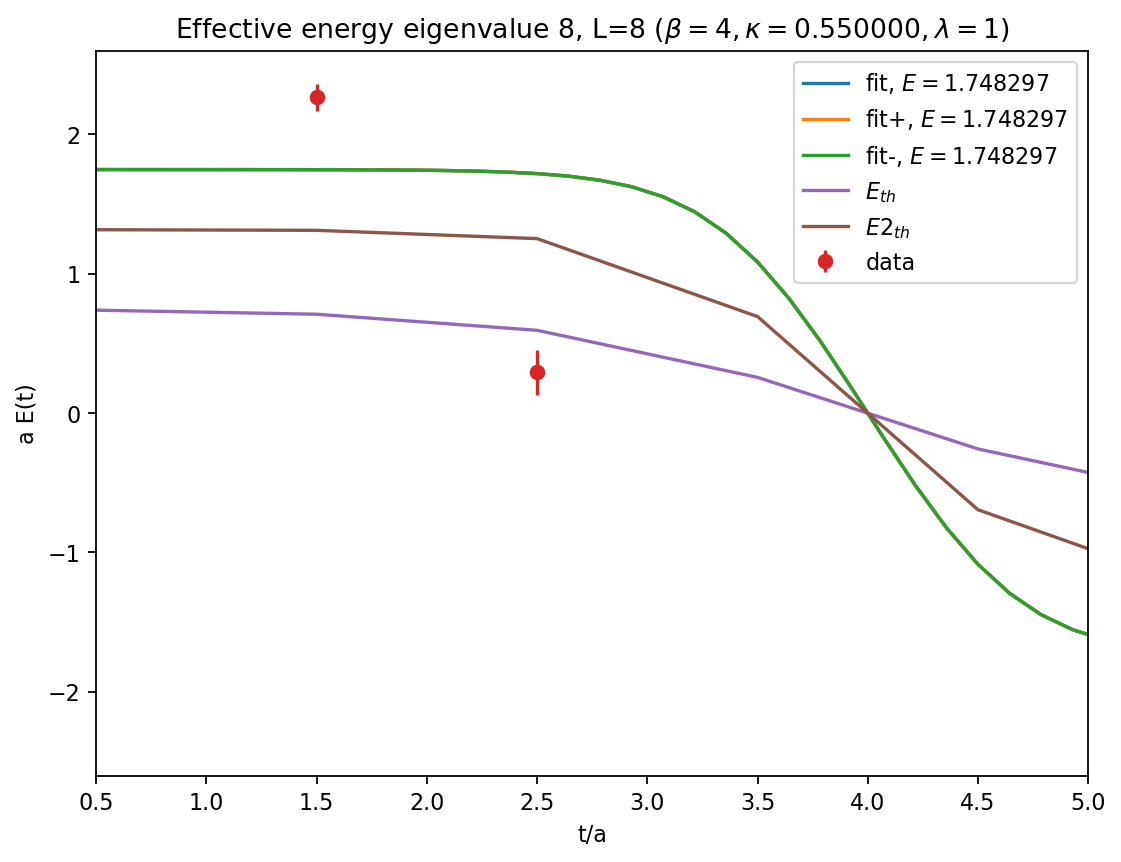

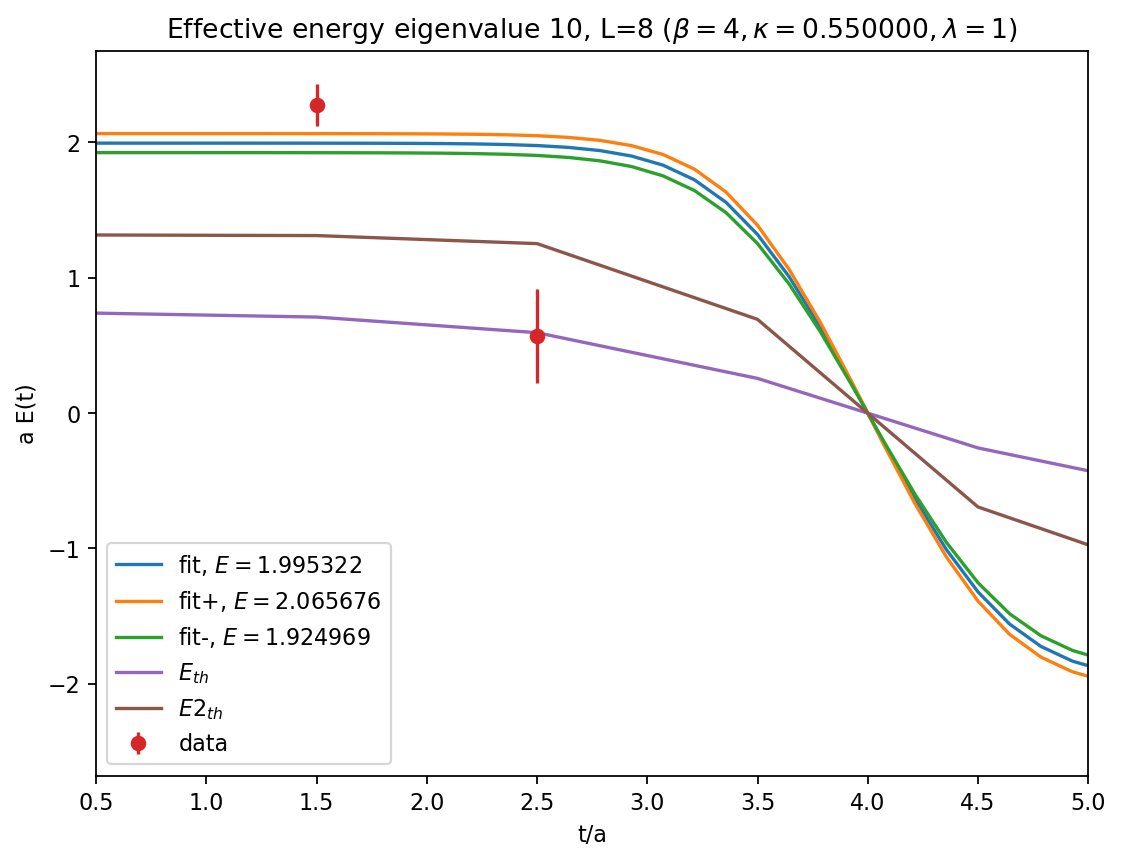

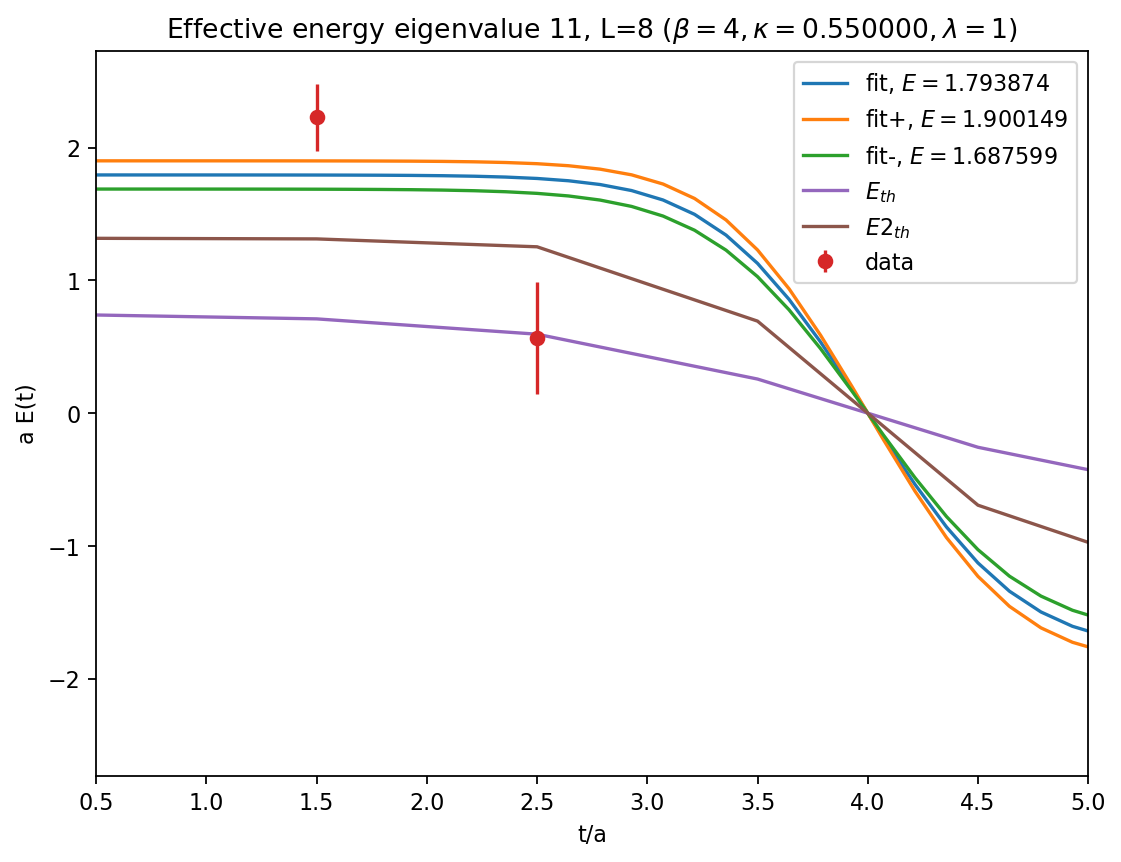

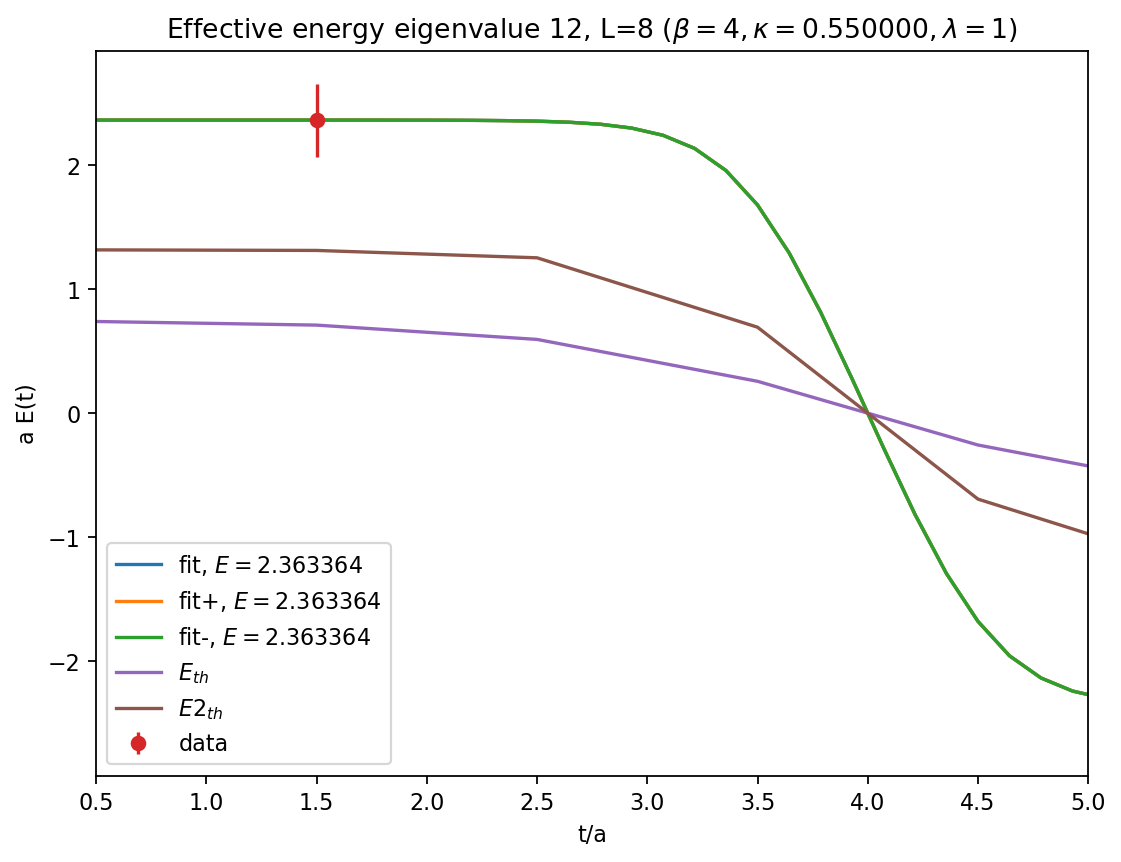

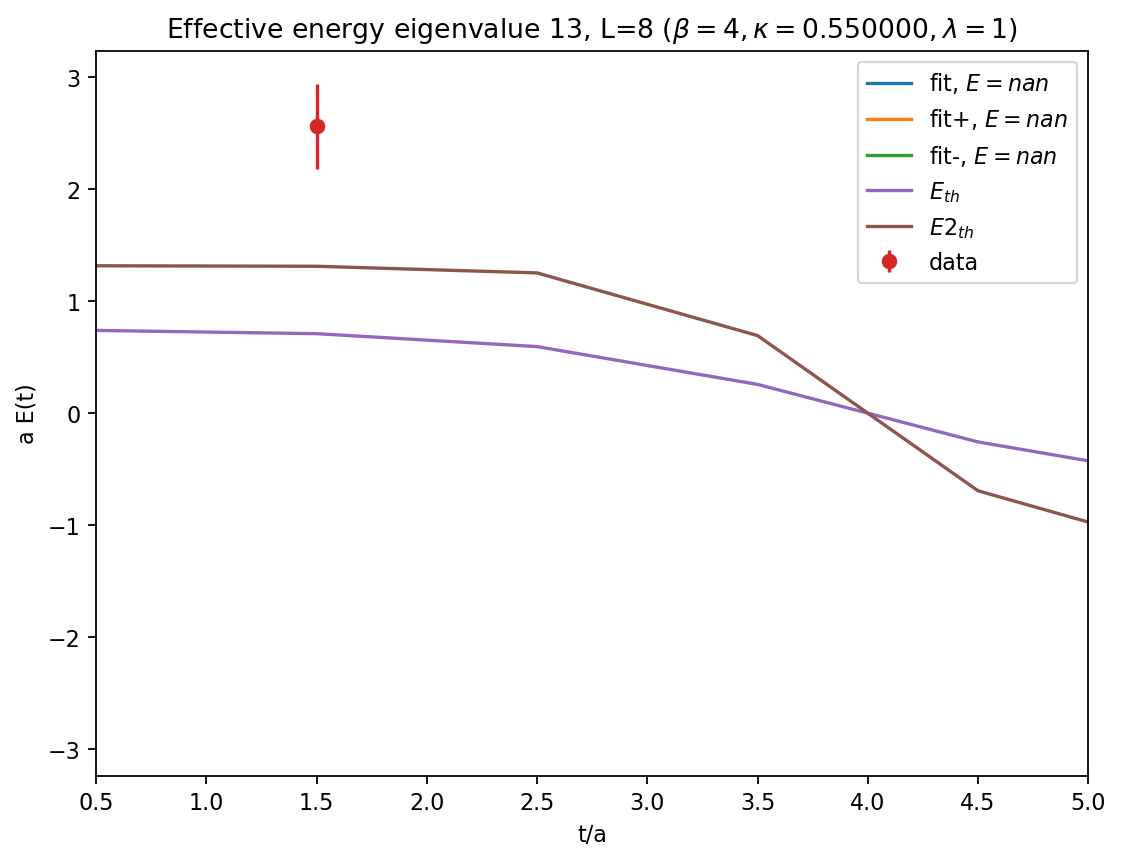

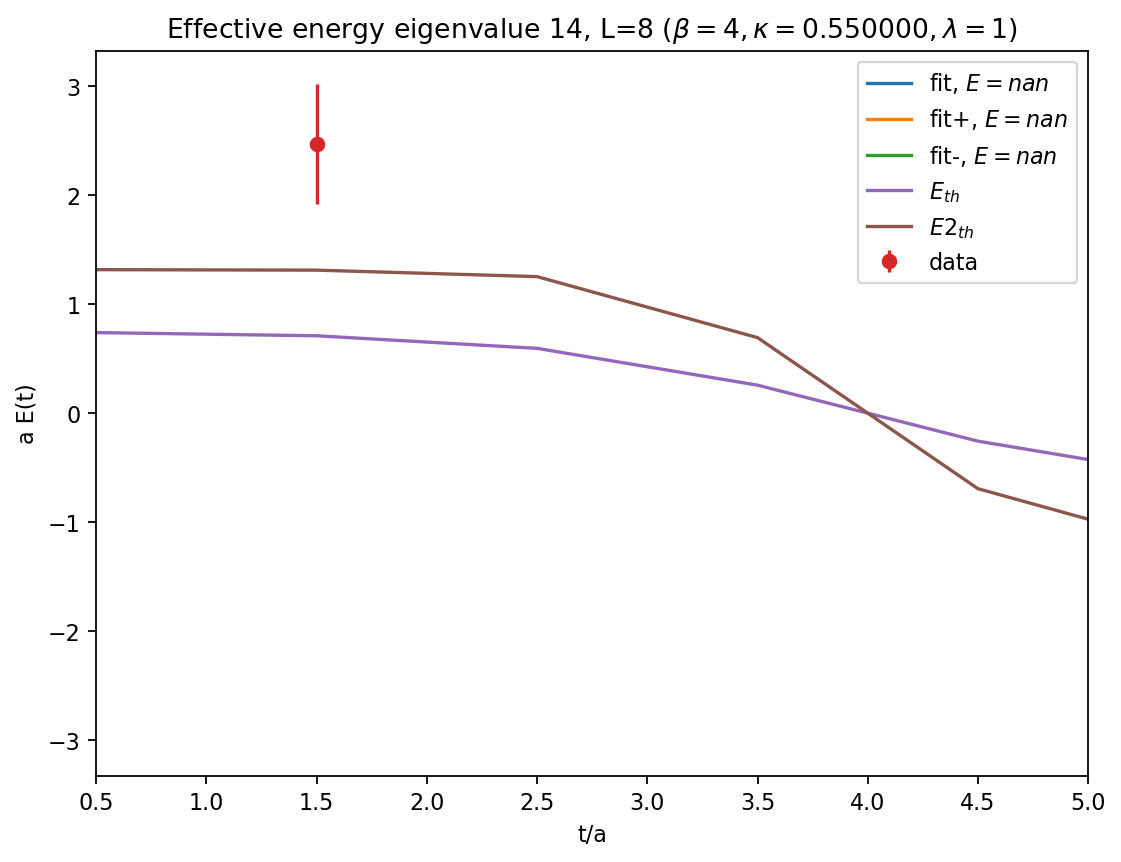

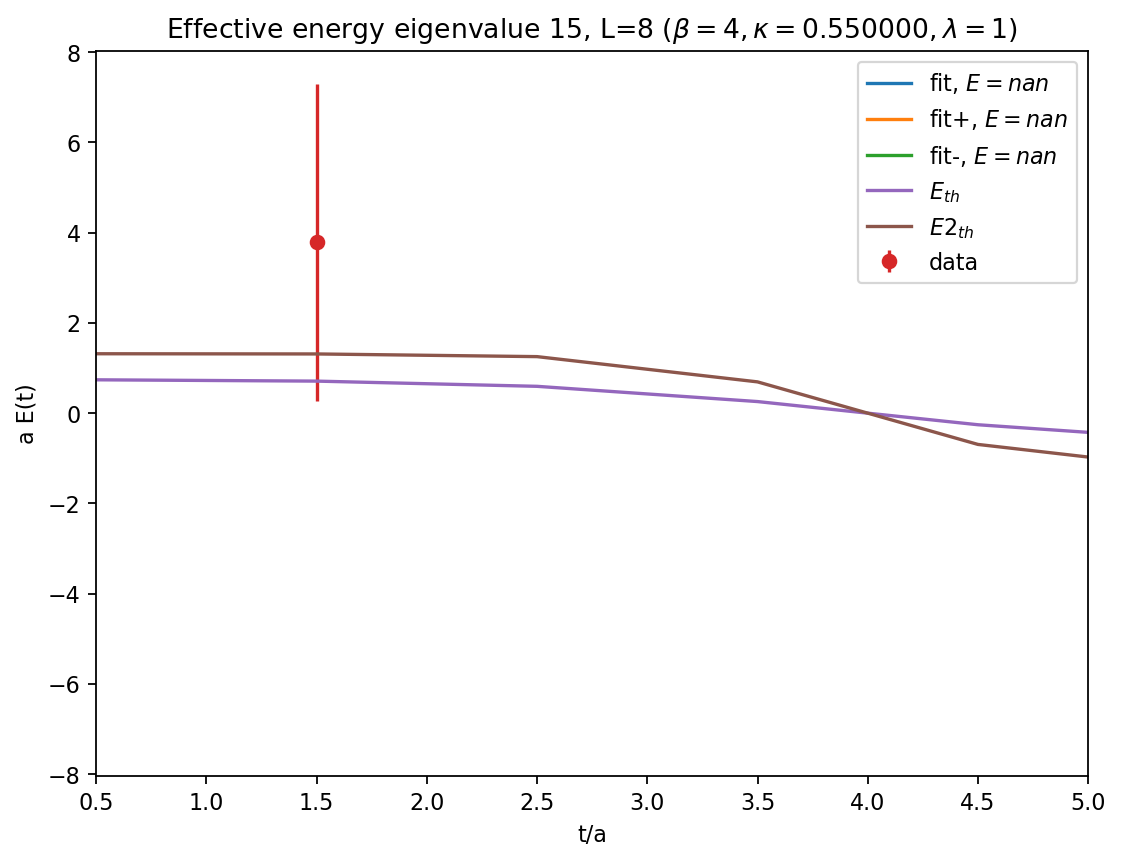

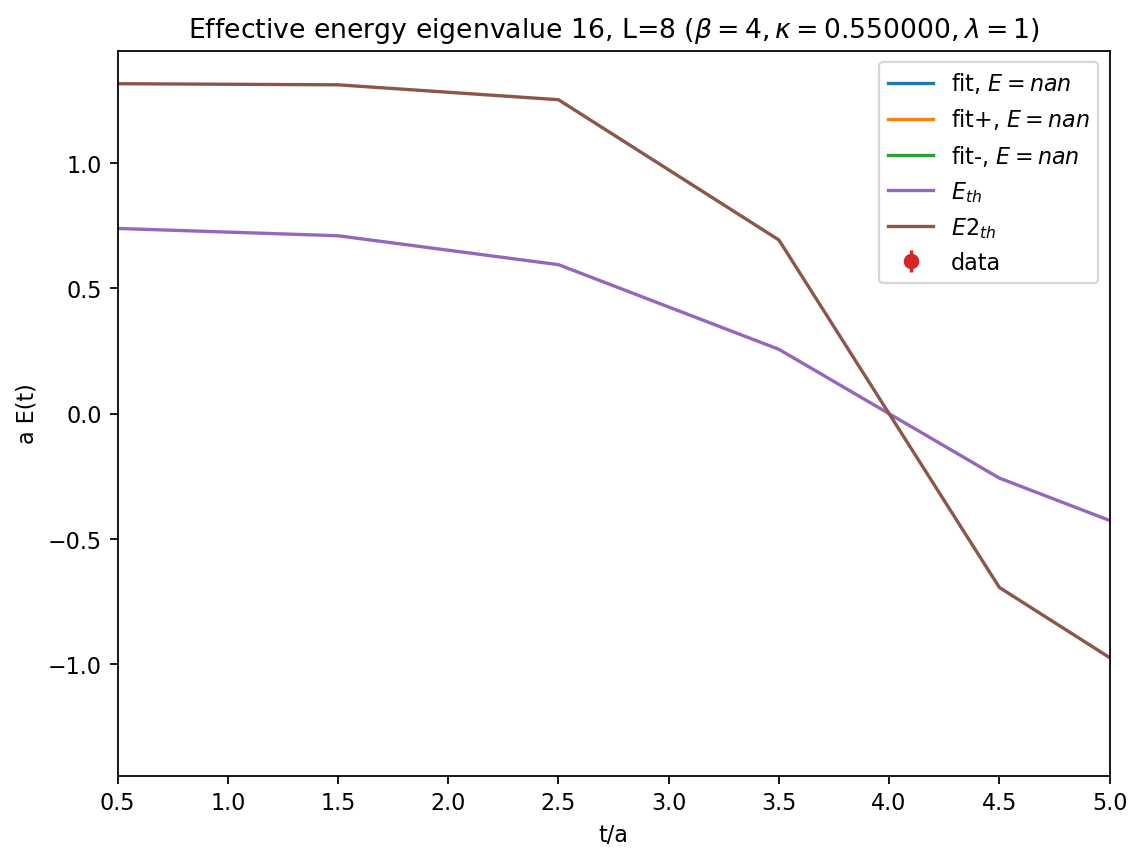

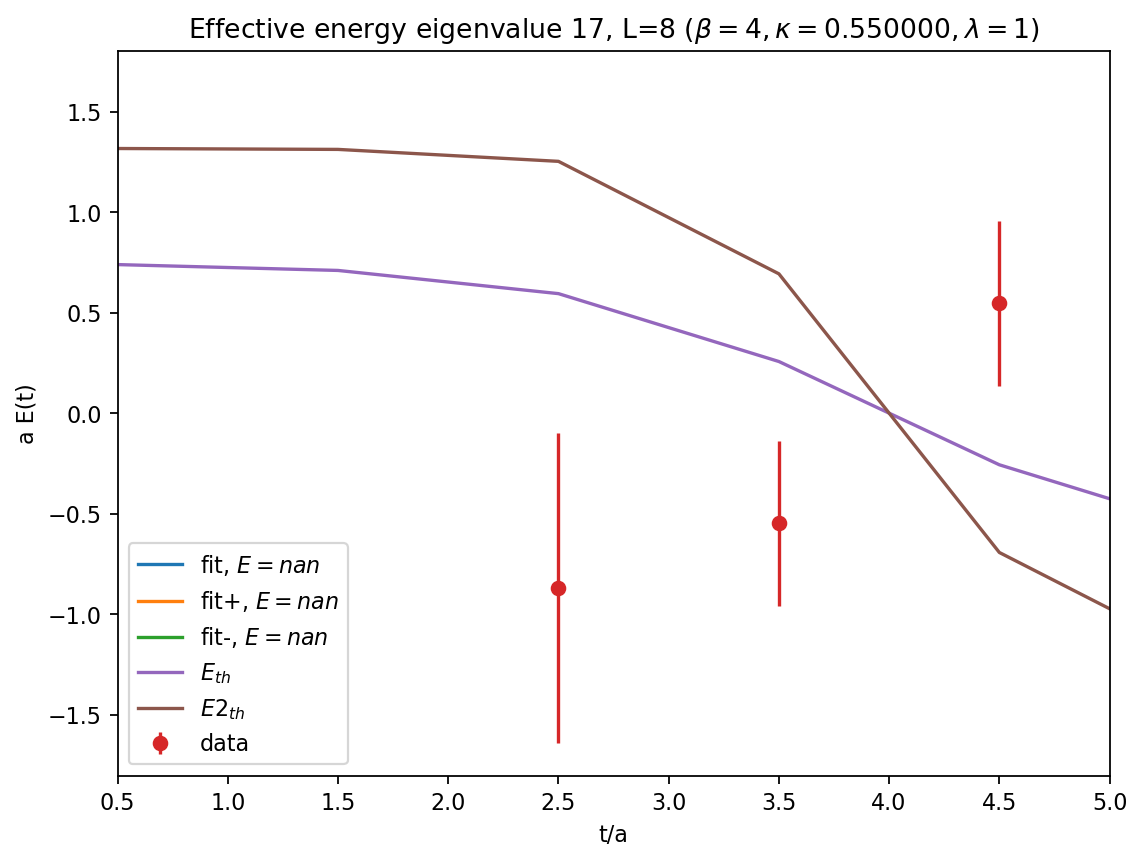

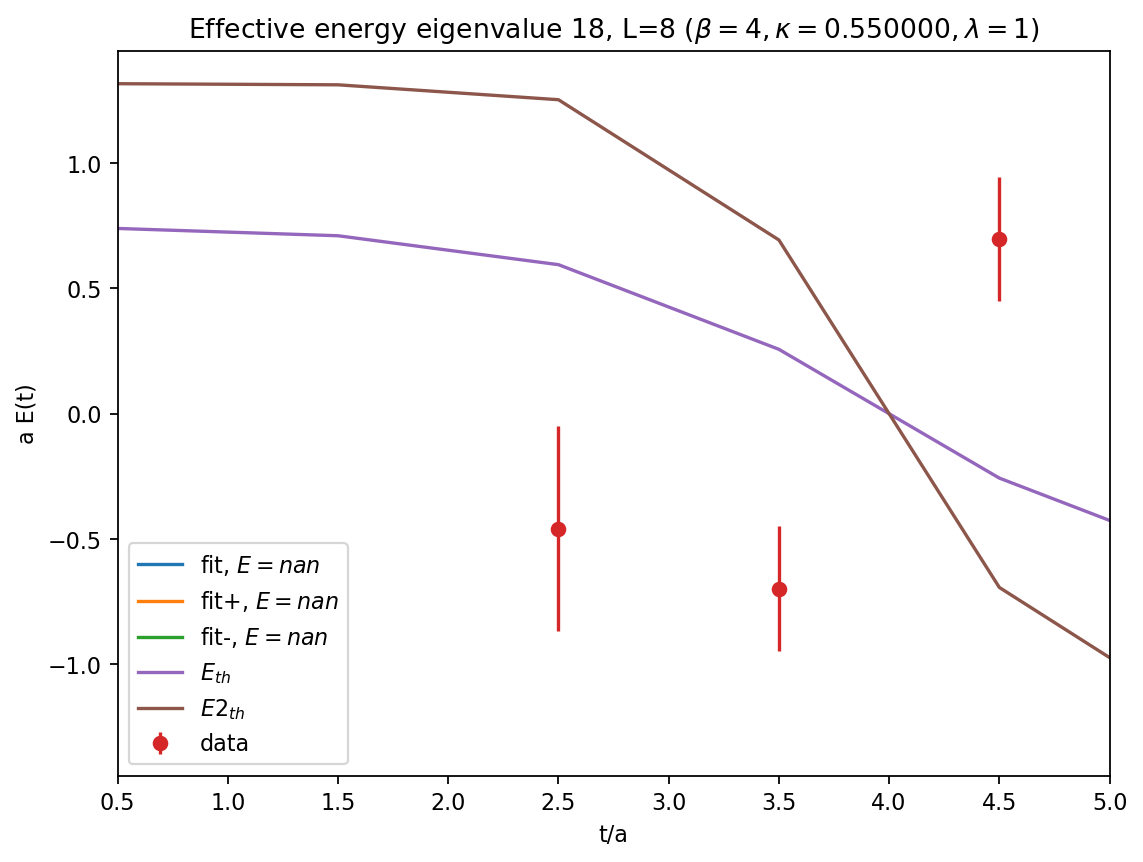

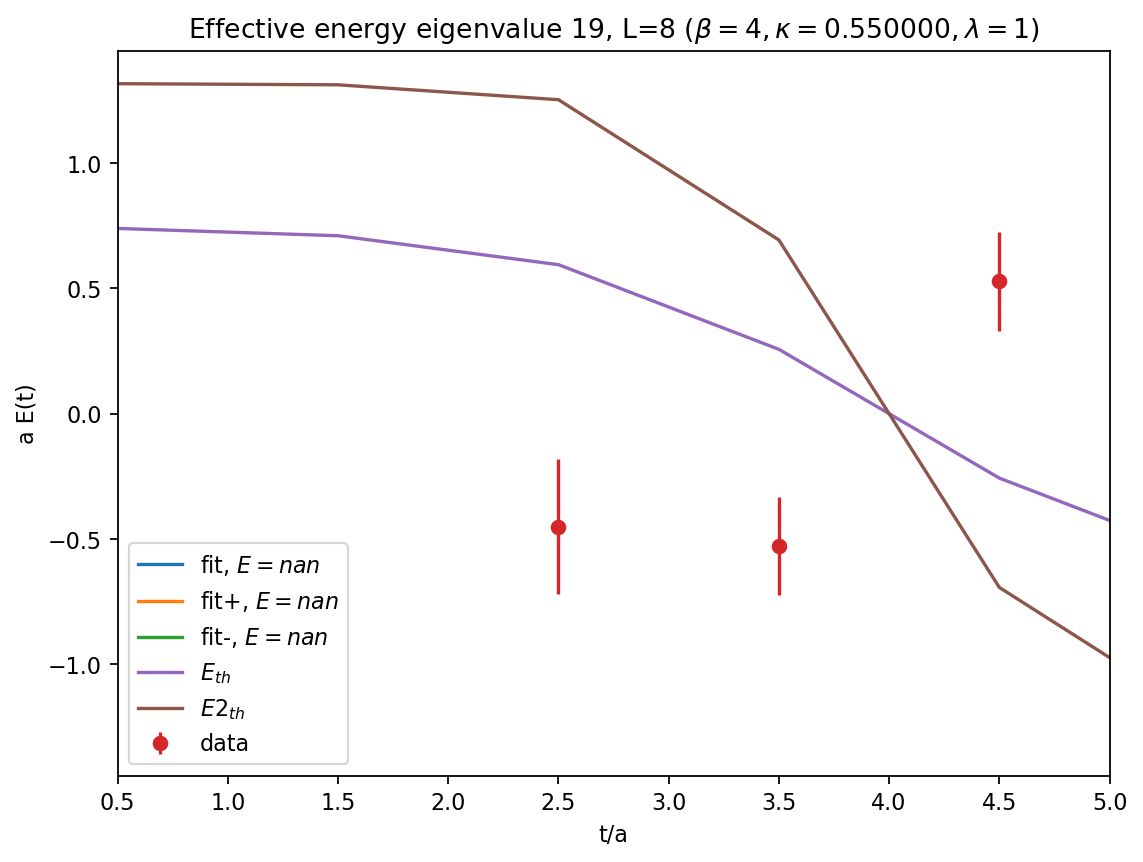

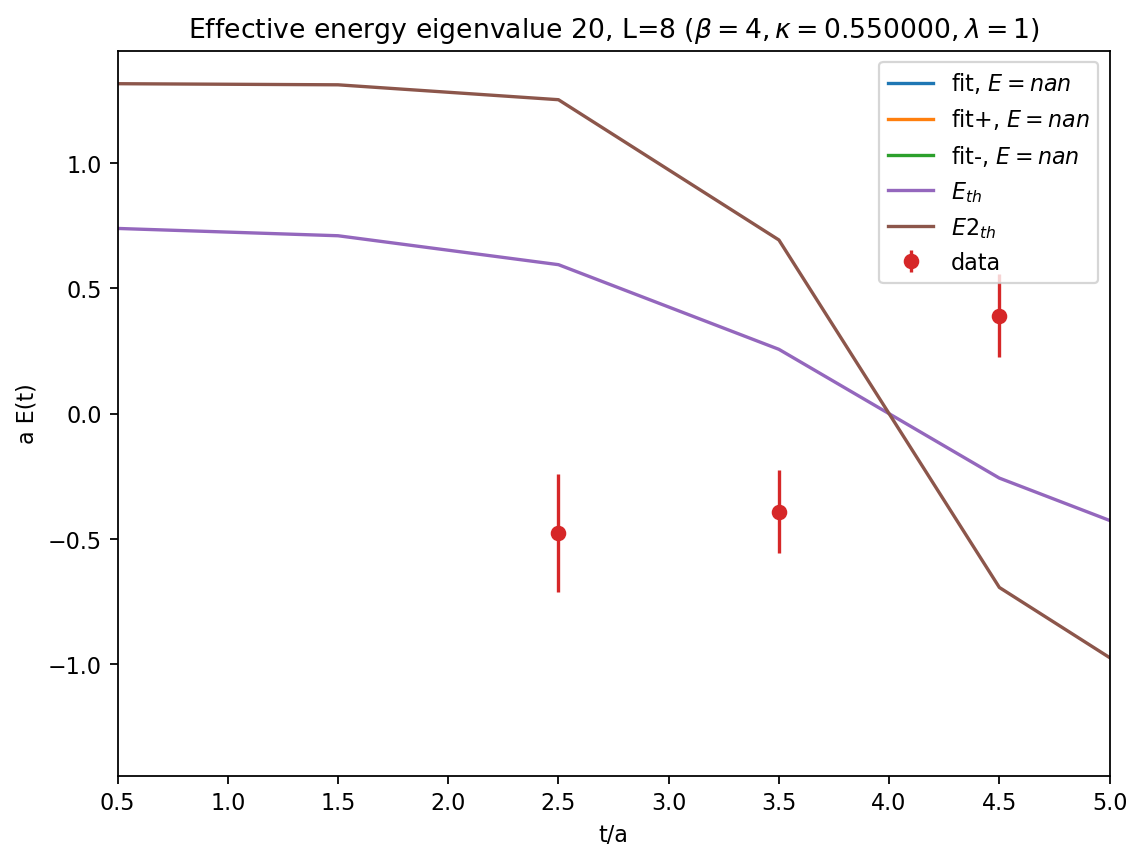

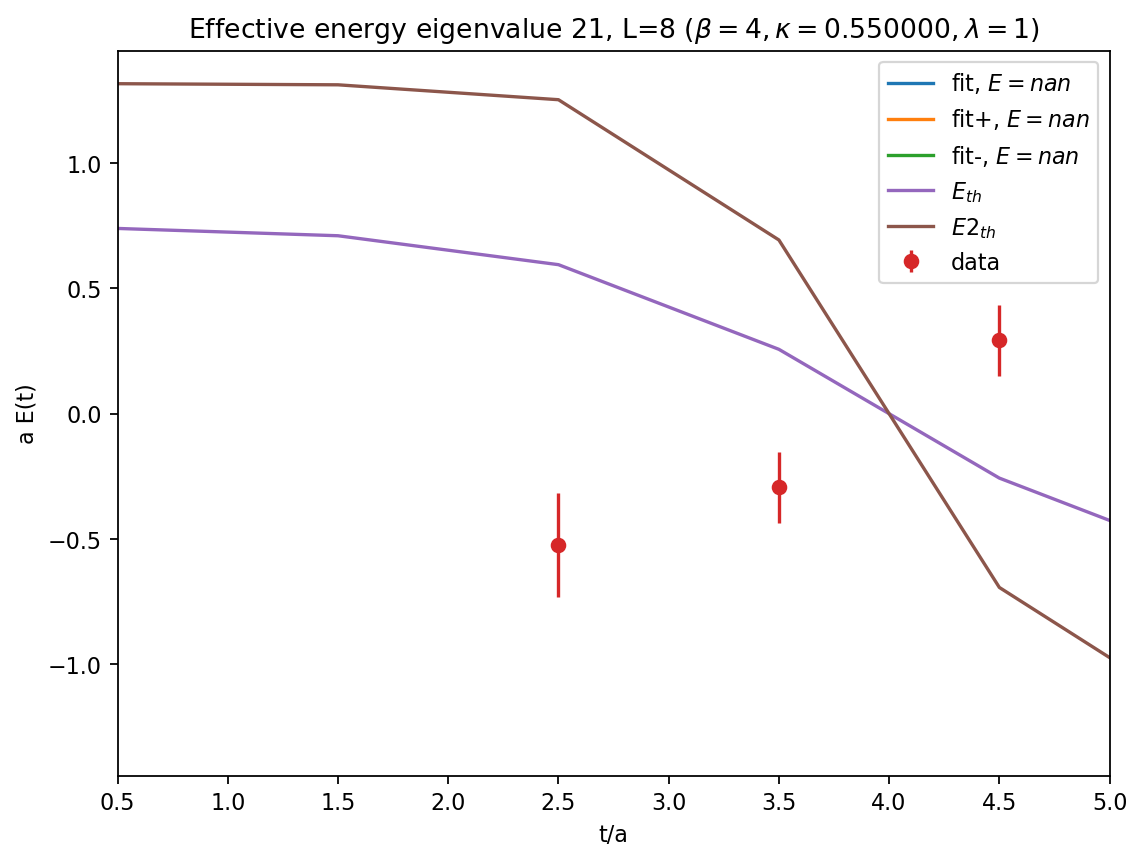

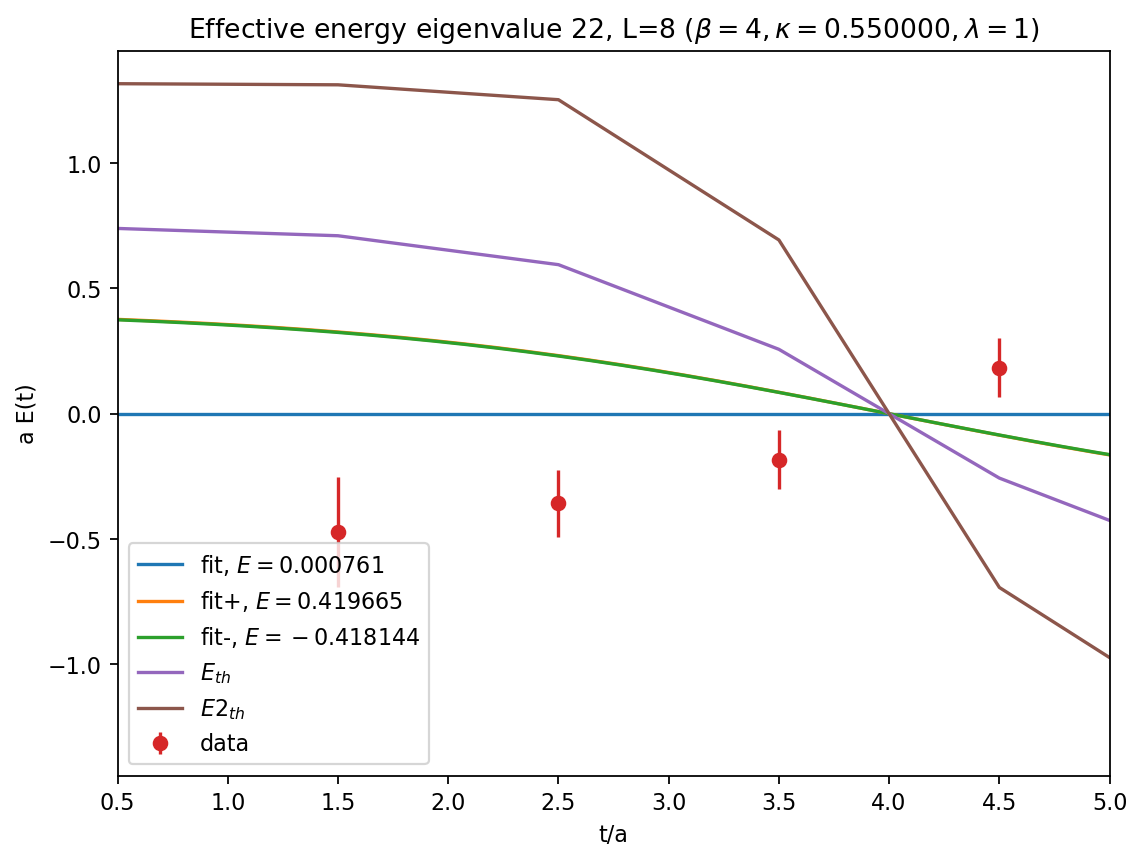

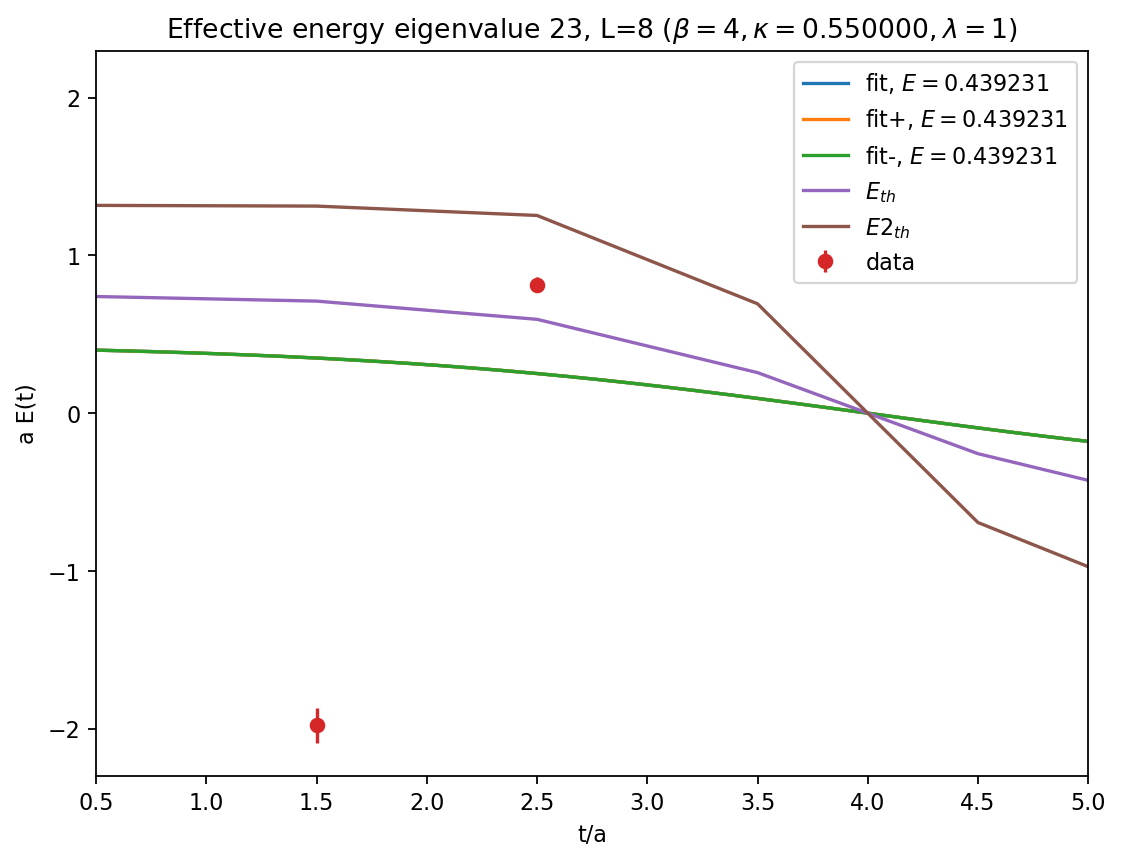

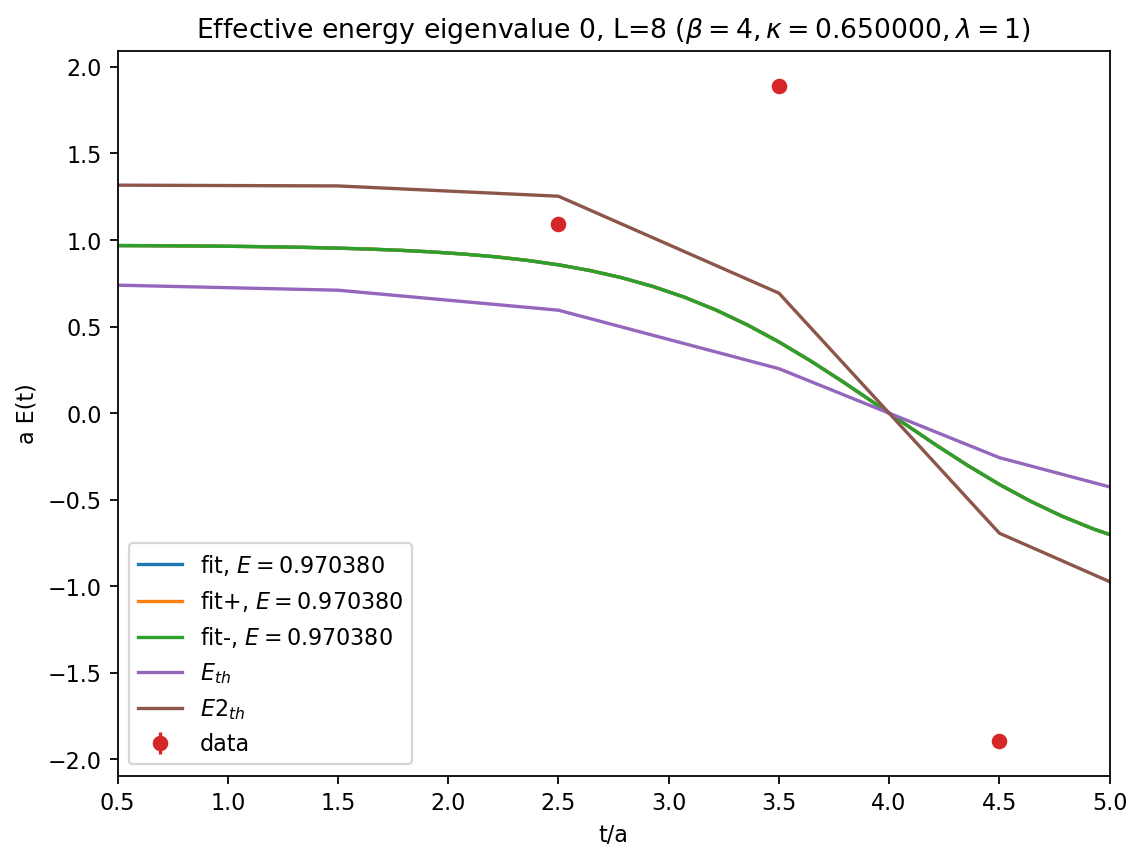

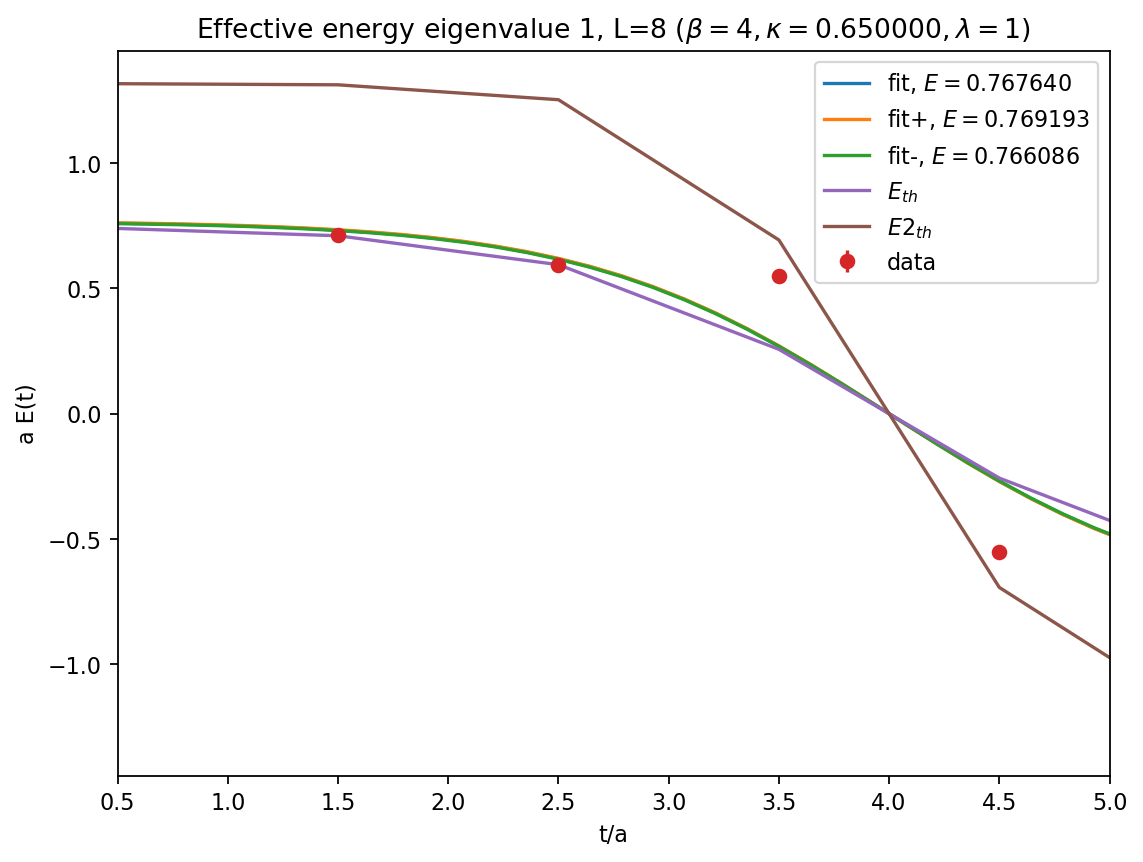

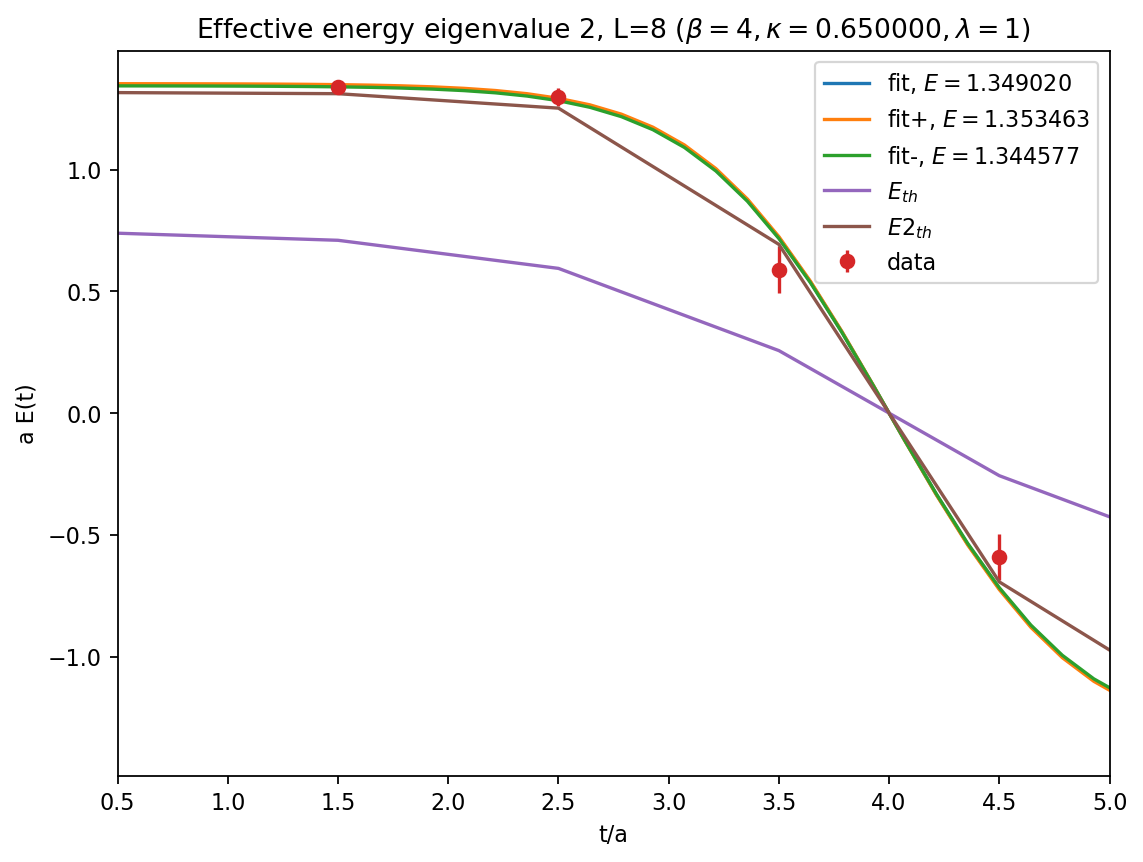

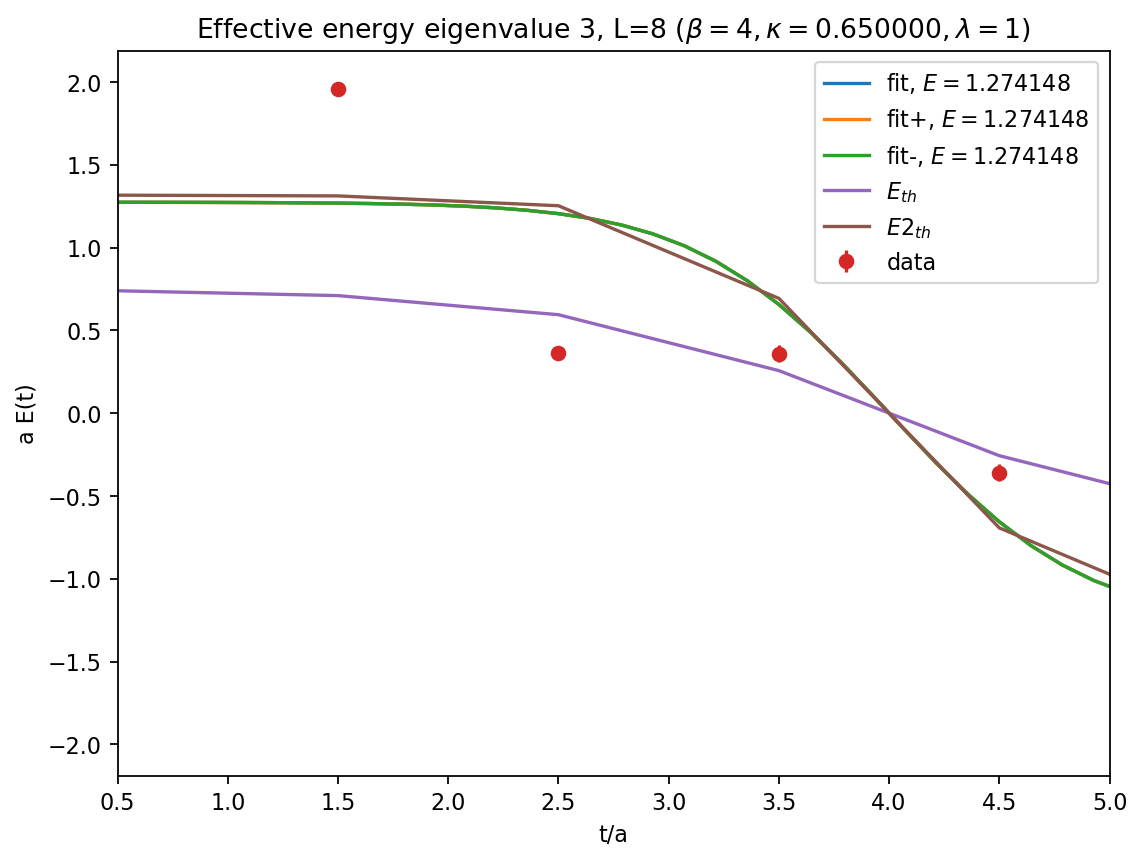

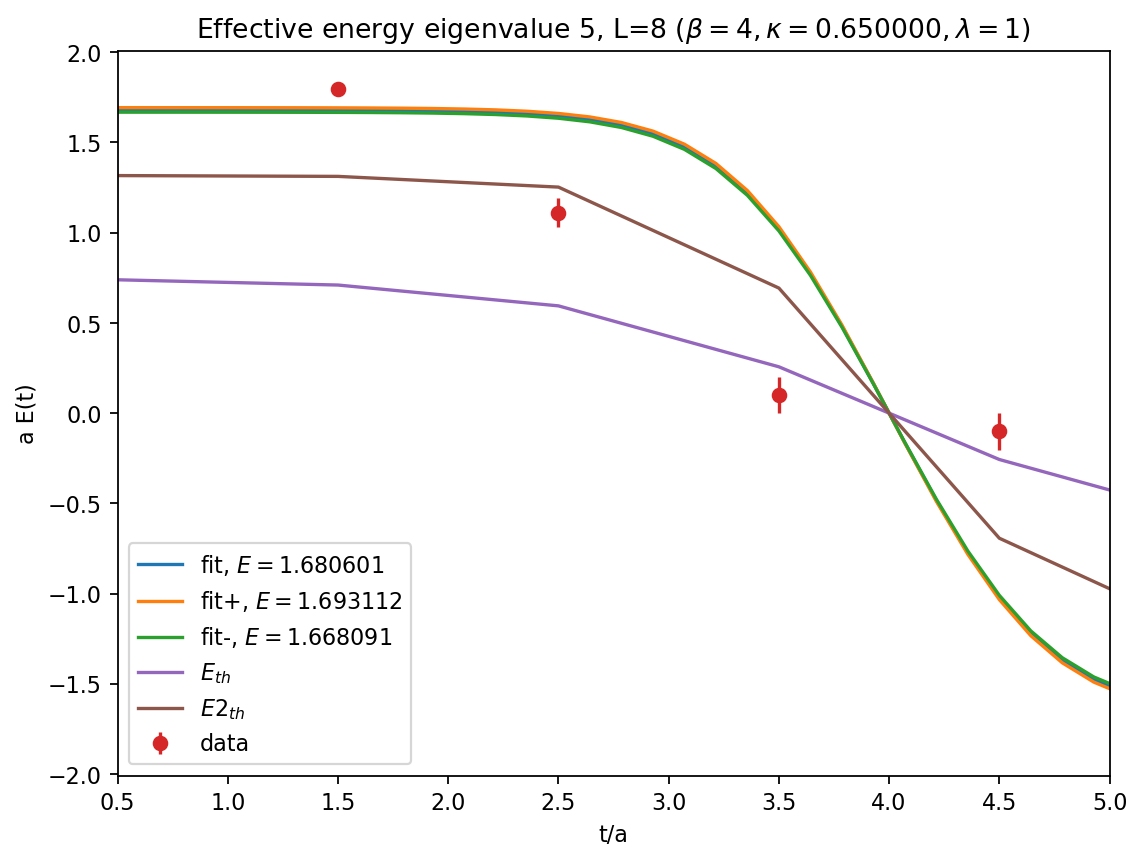

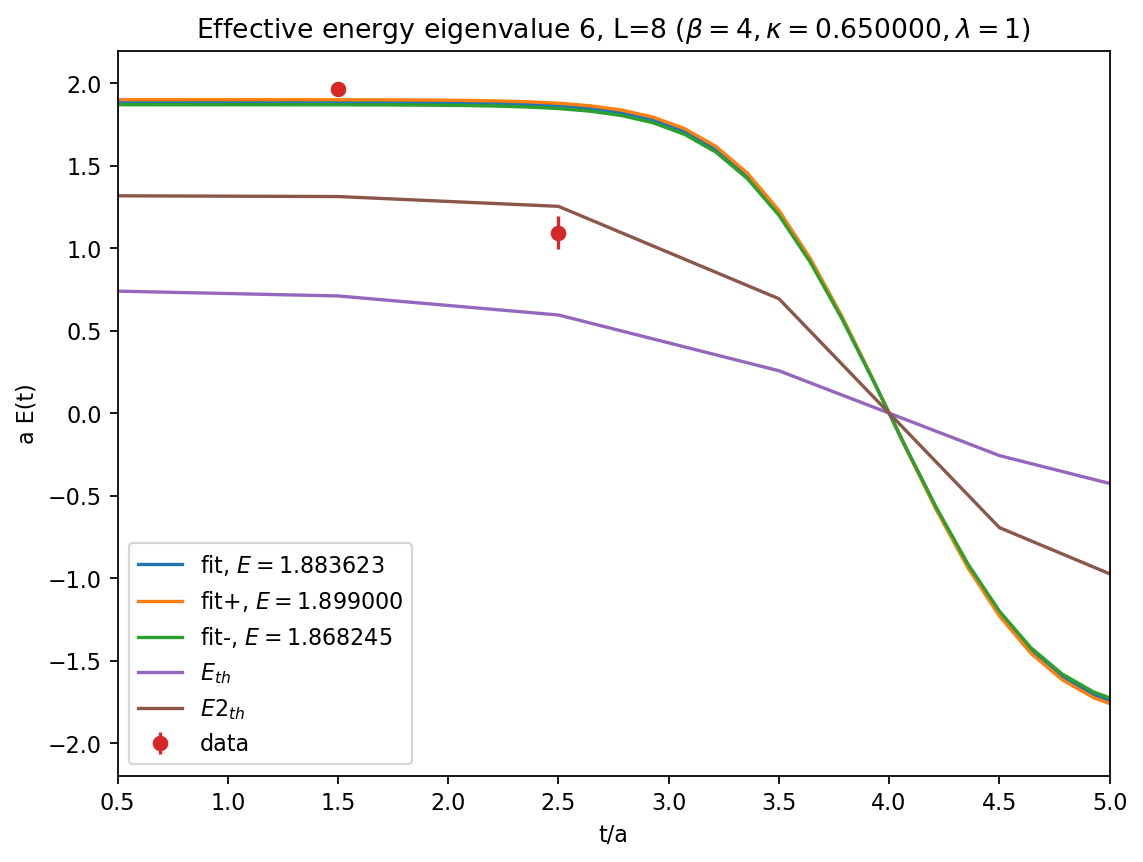

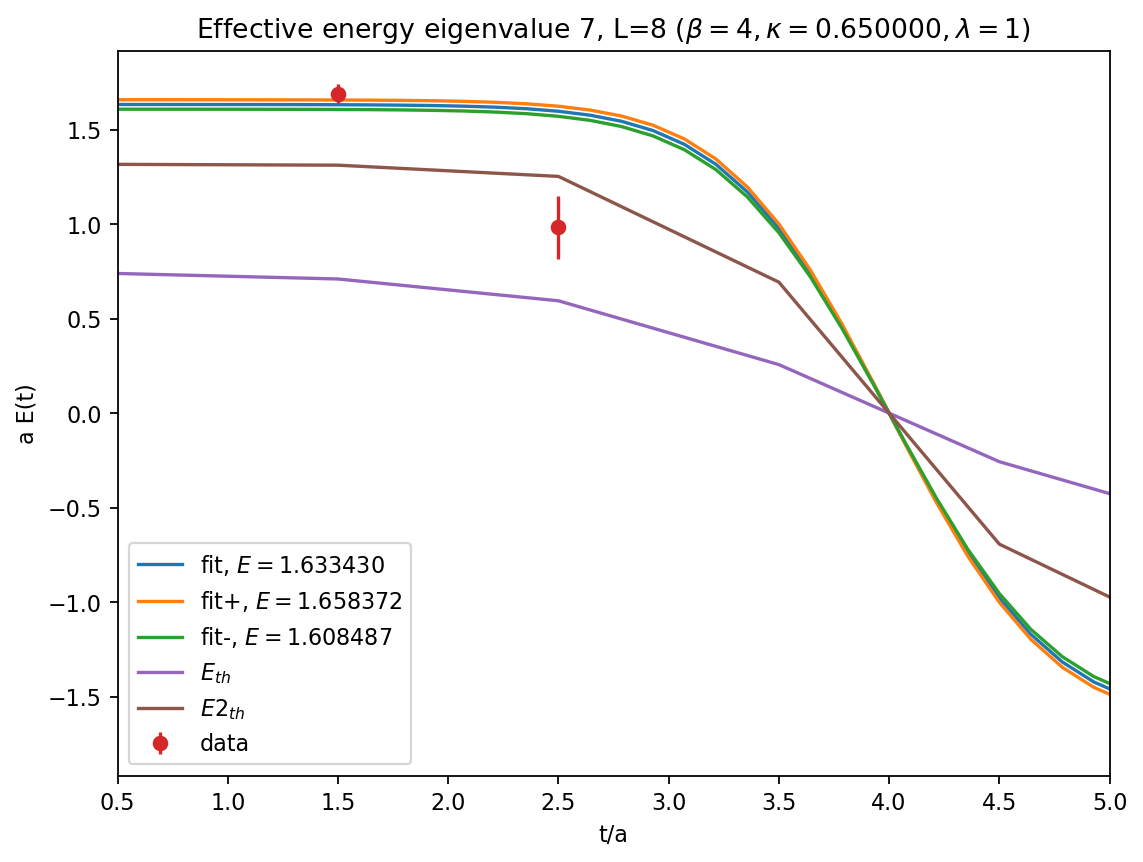

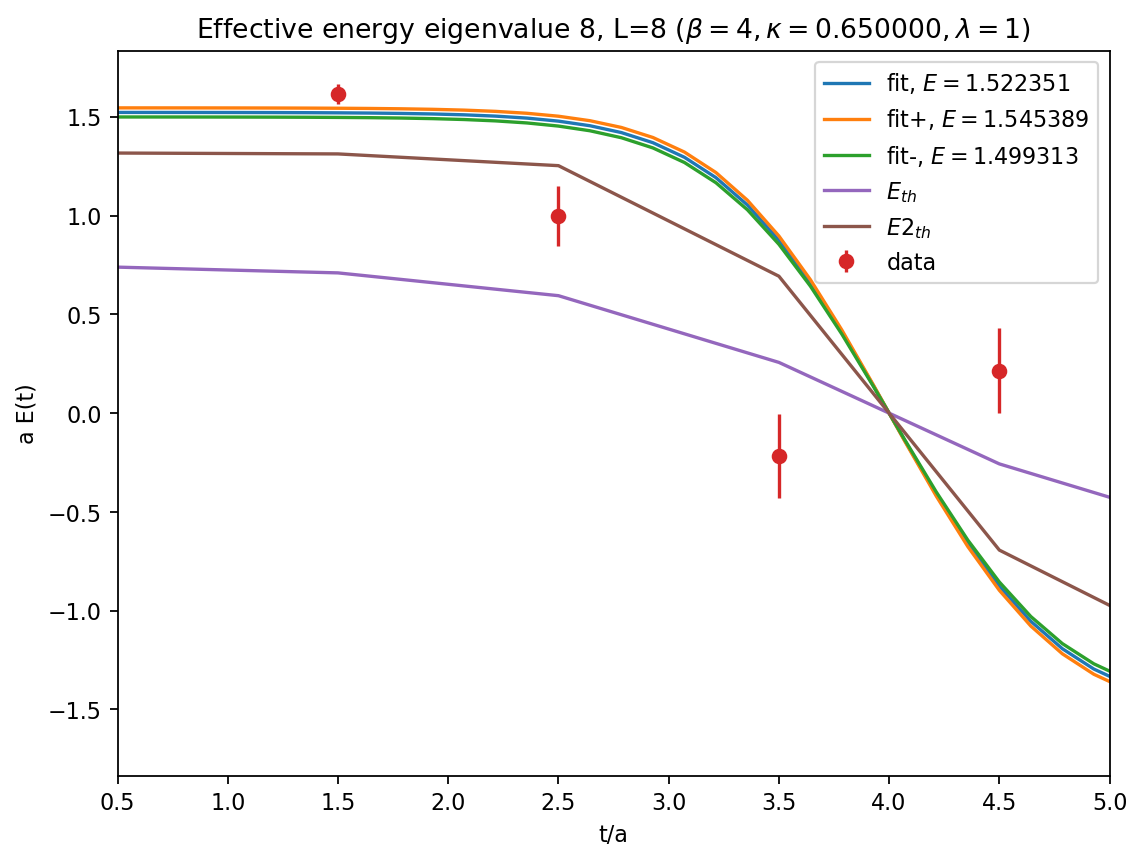

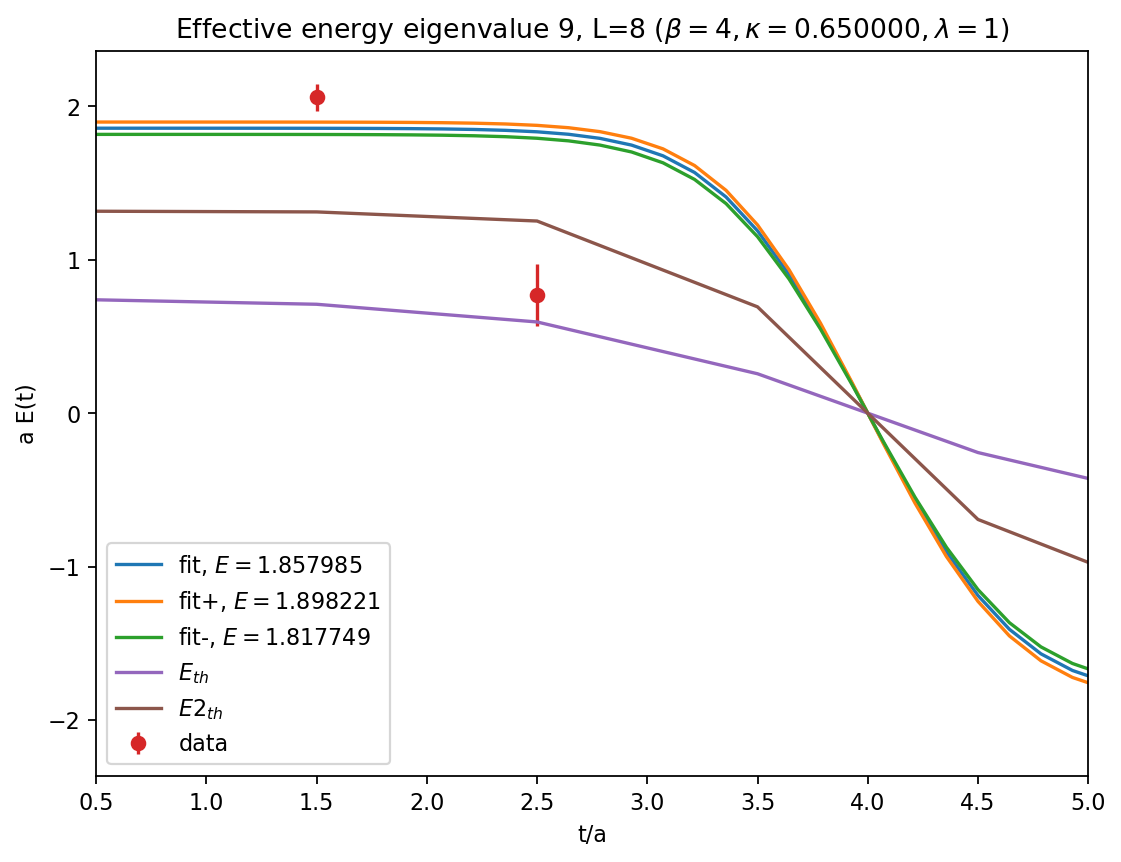

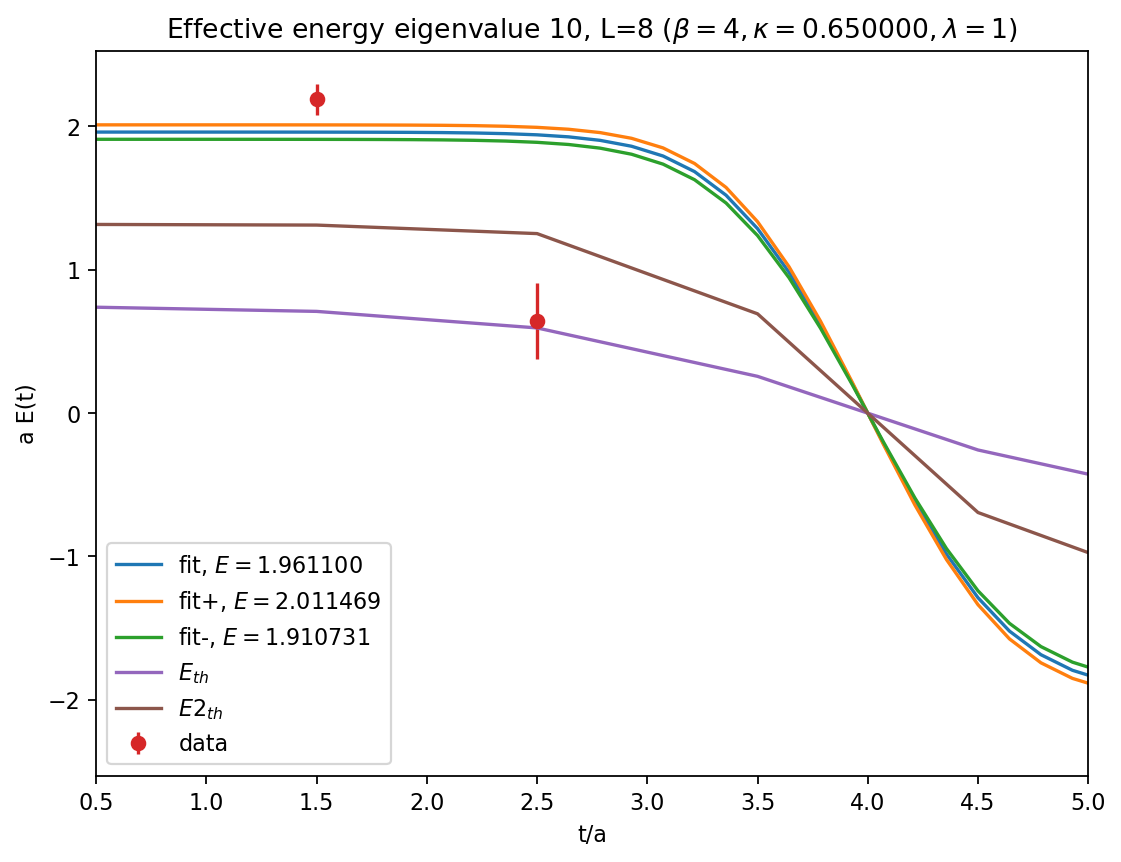

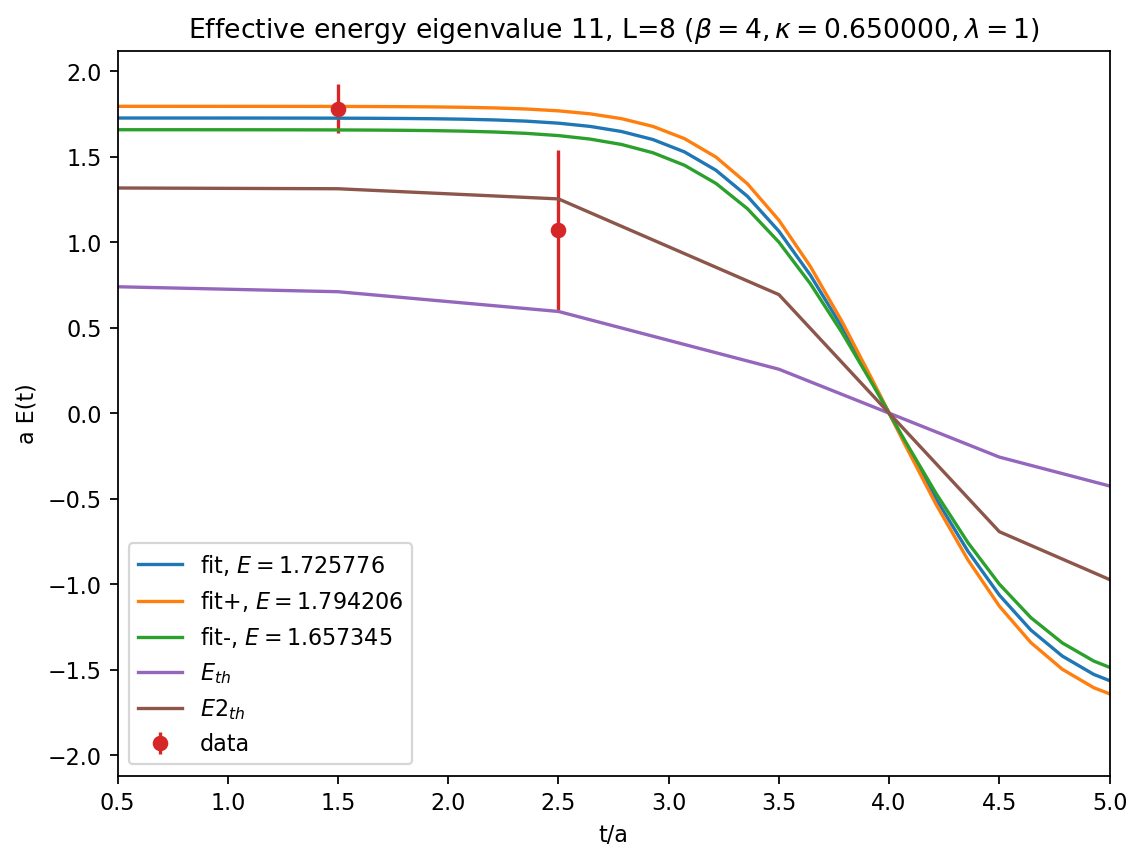

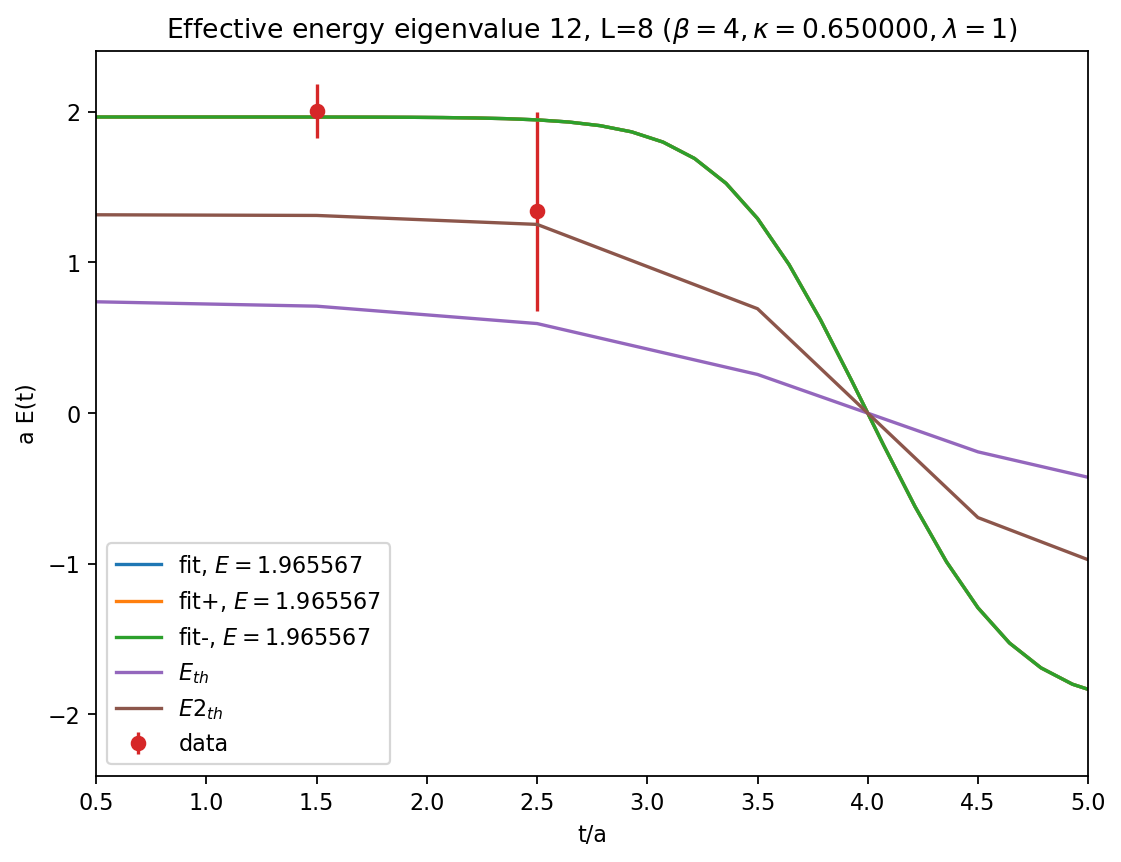

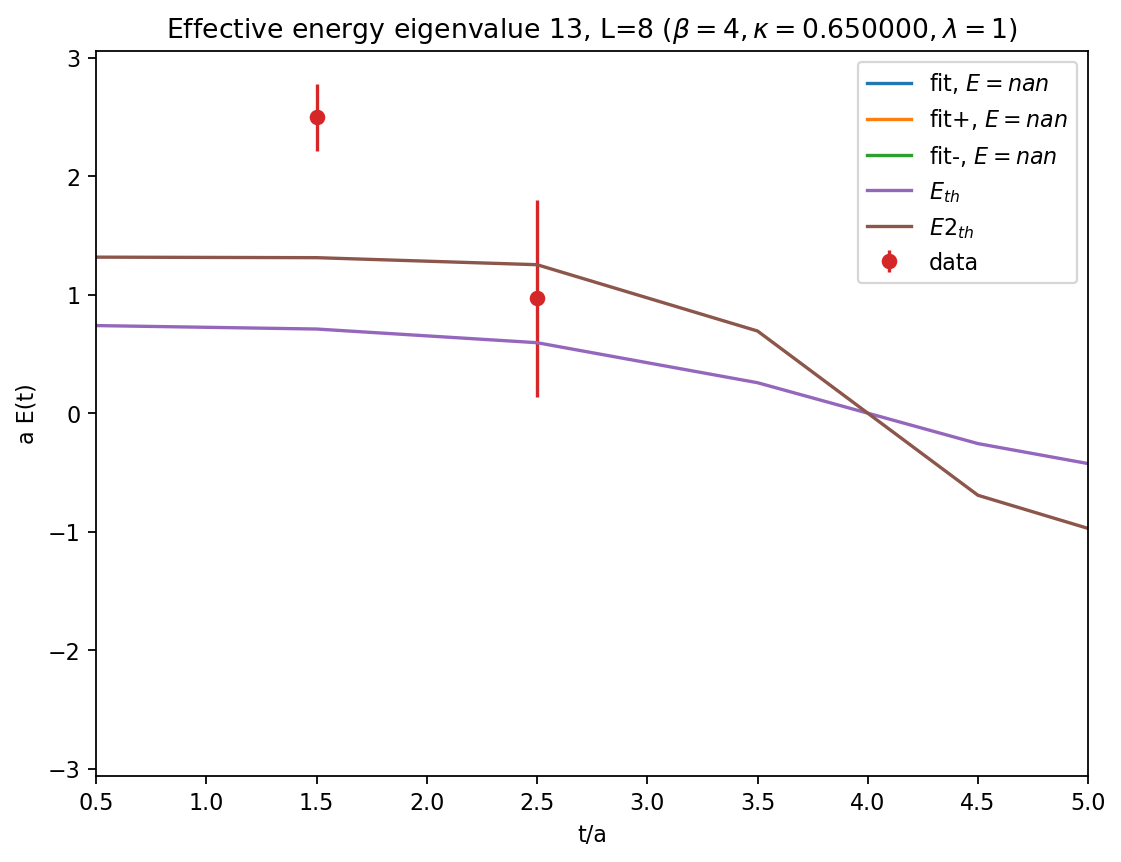

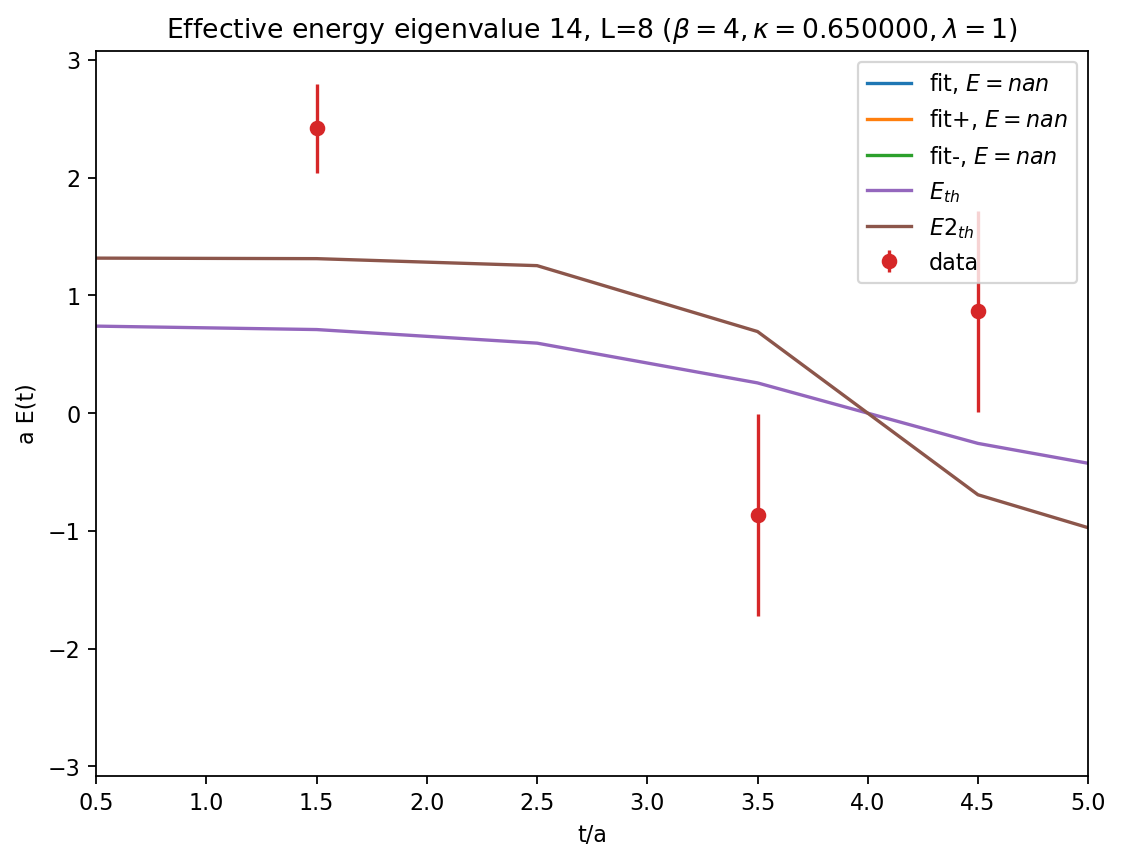

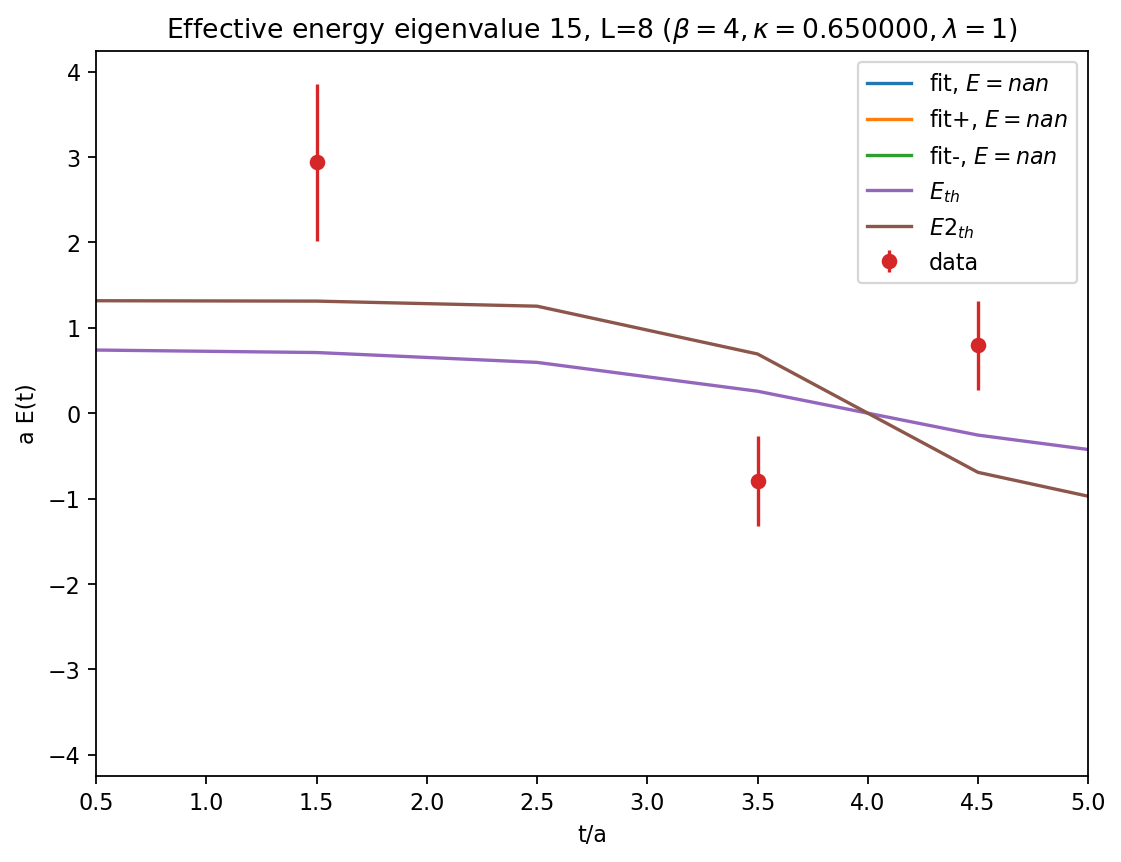

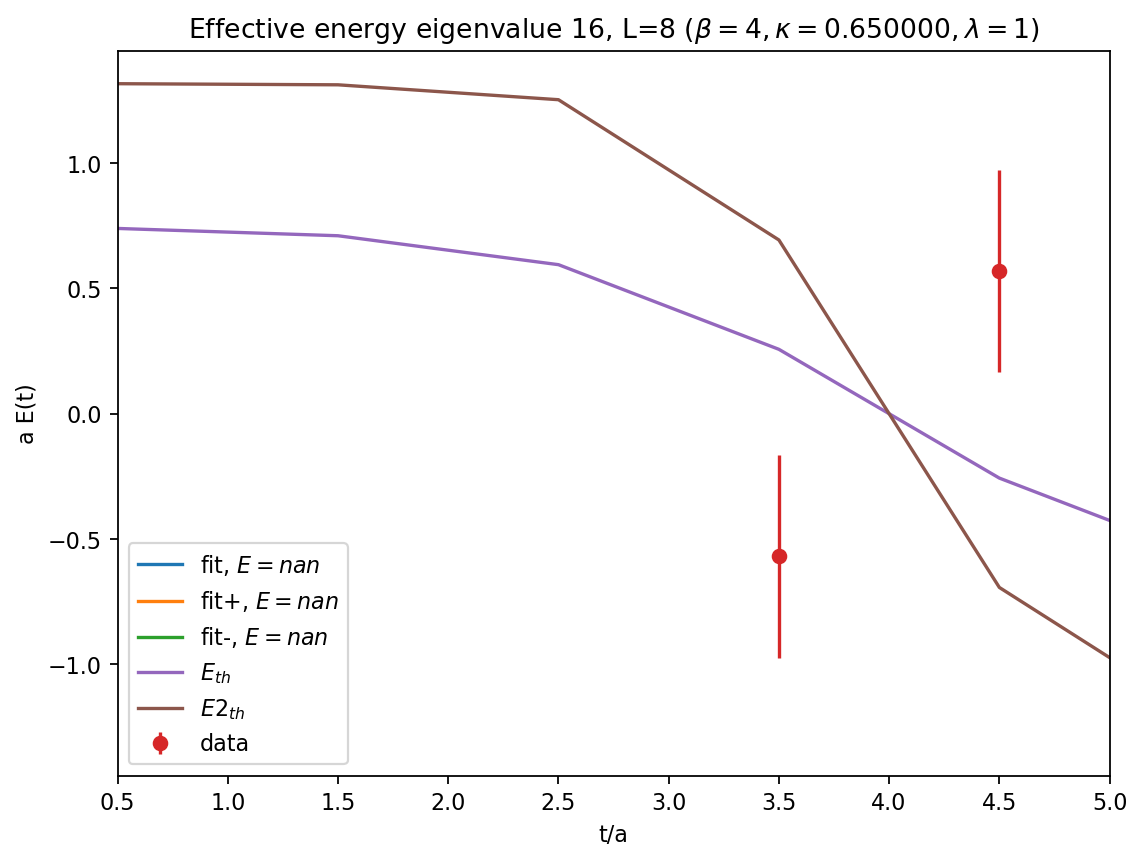

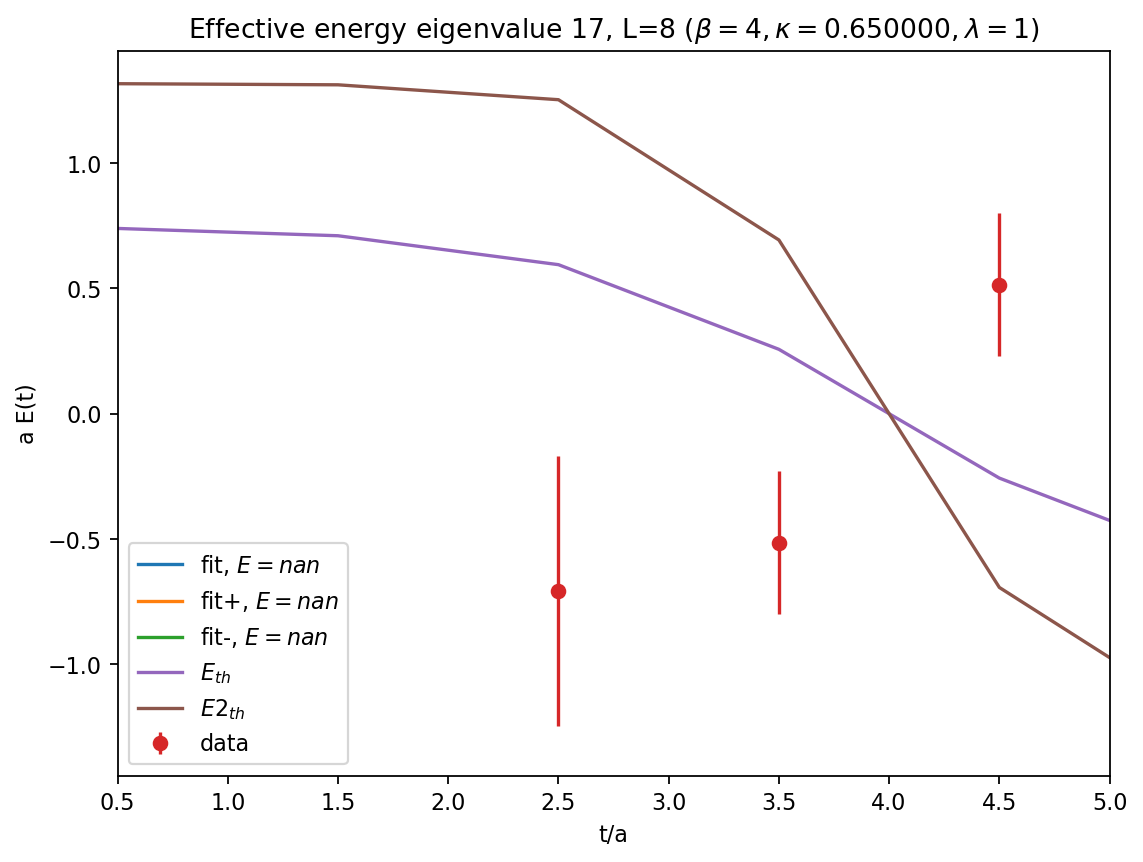

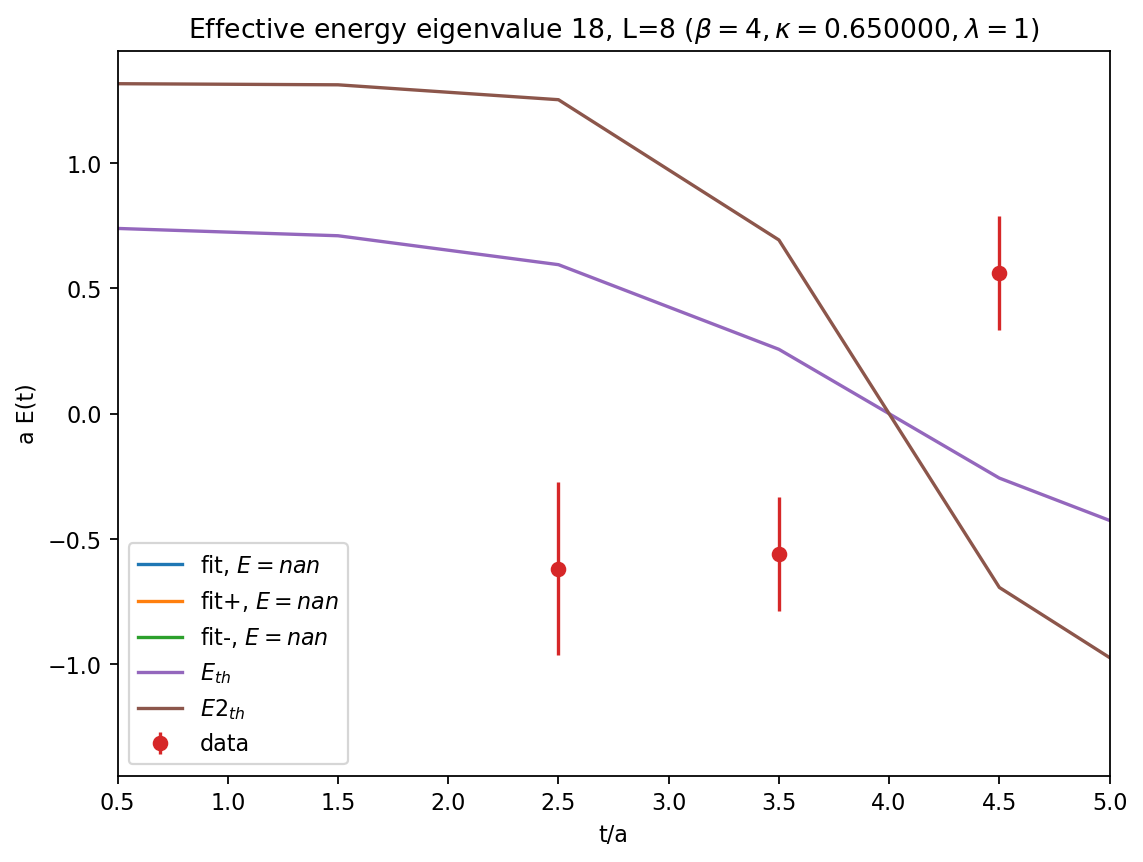

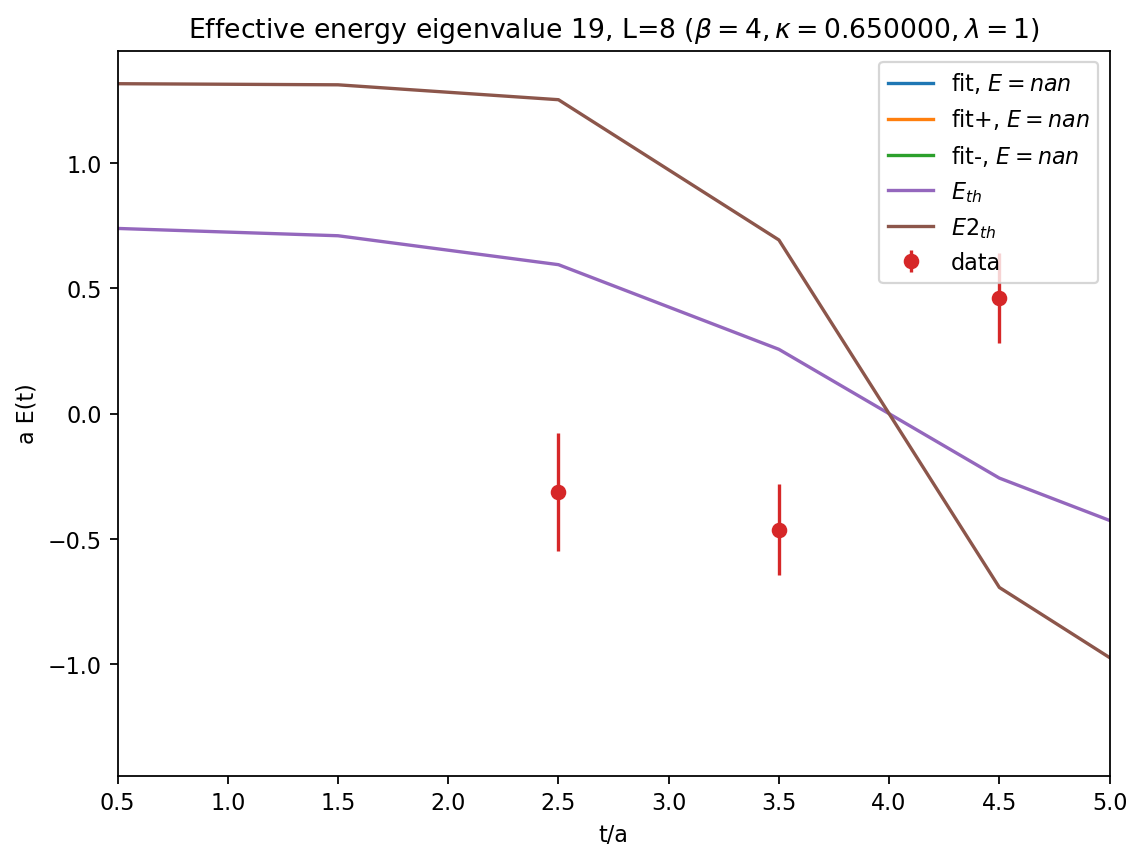

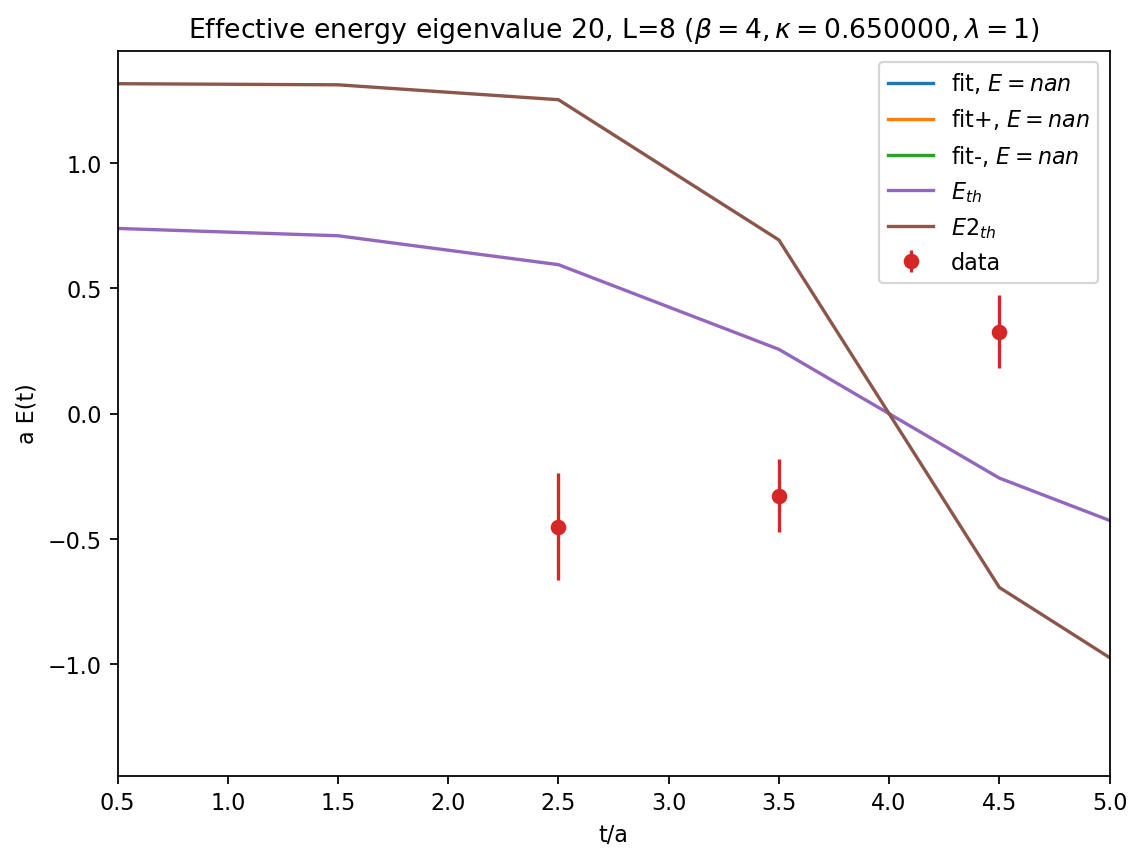

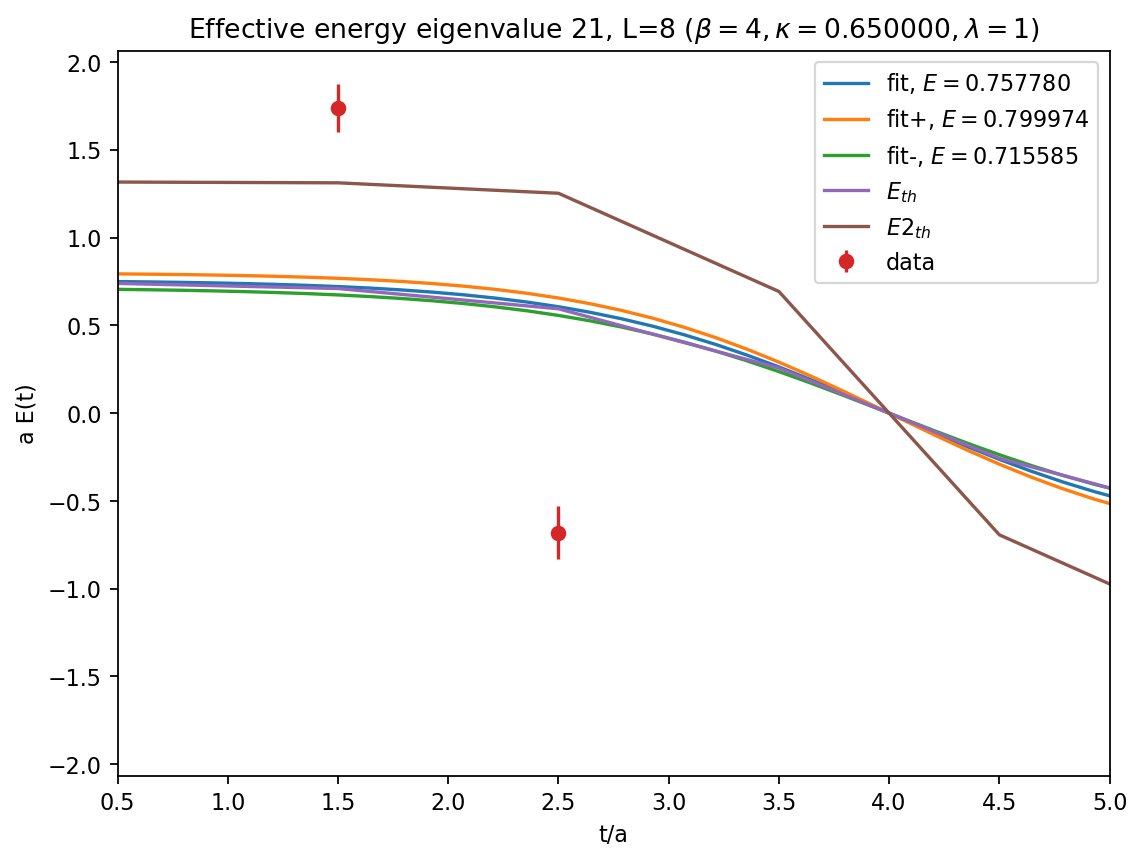

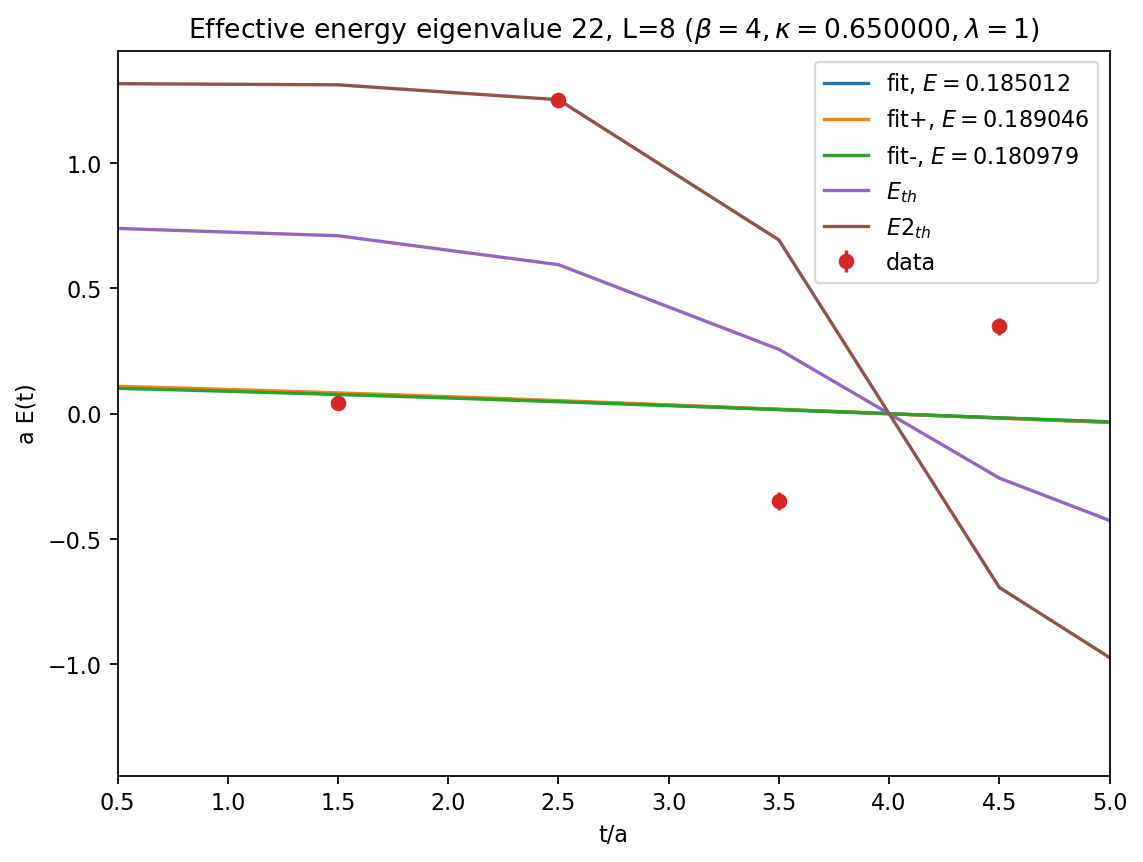

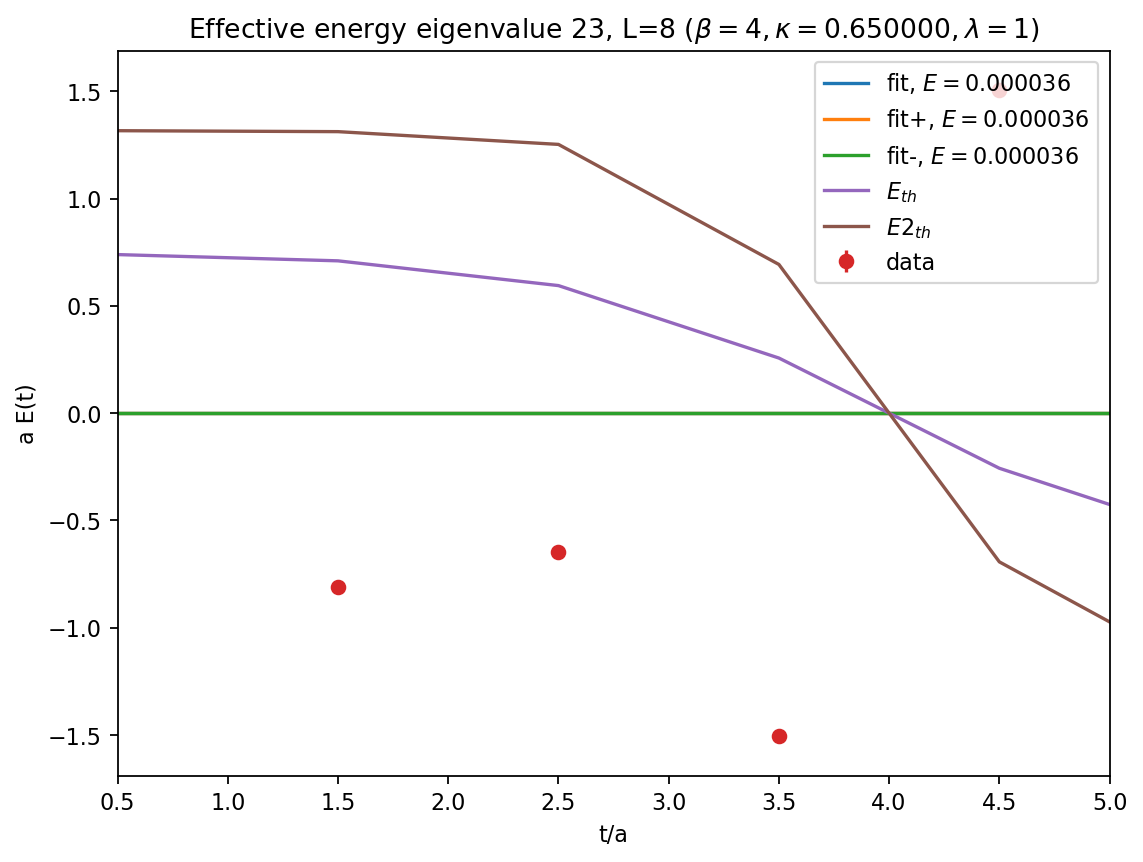

In [77]:
n_smear = 6
k_l=[0.55,0.65]
Nt_l= [8]
for Nt in Nt_l:
    for k in k_l:
        var_analysis_plot(k)

averages = 1.0100340362343385 0.42354359107476597
errors = [9.167175453271845, 0.013752215960089575]
[1.01003404 0.42354359]
averages = nan nan
errors = [nan, nan]
[nan nan]


/hosts/nashome/vaf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:283: RuntimeWarning: invalid value encountered in log


averages = nan nan
errors = [nan, nan]
[nan nan]
averages = nan nan
errors = [nan, nan]
[nan nan]
averages = 1.000000000009974 0.2715157452974338
errors = [5.206461228457396, 0.0037147928166881006]
[1.         0.27151575]
averages = nan nan
errors = [nan, nan]
[nan nan]
averages = nan nan
errors = [nan, nan]
[nan nan]
averages = nan nan
errors = [nan, nan]
[nan nan]
averages = 1.0000000000016556 0.23615203535049994
errors = [5.2064612284663845, 0.0026492603821537397]
[1.         0.23615204]
averages = nan nan
errors = [nan, nan]
[nan nan]
averages = nan nan
errors = [nan, nan]
[nan nan]
averages = nan nan
errors = [nan, nan]
[nan nan]
averages = 1.2547345492970363 0.21819328787318376
errors = [9.059409650752363, 0.00249817064609803]
[1.25473455 0.21819329]
averages = 1.0003700400082267 0.4093808463080877
errors = [5.6867134288952315, 0.00306537259934872]
[1.00037004 0.40938085]
averages = nan nan
errors = [nan, nan]
[nan nan]
averages = nan nan
errors = [nan, nan]
[nan nan]
averages = 

/hosts/nashome/vaf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:370: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


averages = 1.057927684767559 0.2102228372301383
errors = [5.1446163537817045, 0.0023877624766600603]
[1.05792768 0.21022284]
averages = 0.9830342675488479 0.3993492783082849
errors = [5.417242673512284, 0.0029192132683564798]
[0.98303427 0.39934928]
averages = nan nan
errors = [nan, nan]
[nan nan]
averages = nan nan
errors = [nan, nan]
[nan nan]
averages = 0.9998548581435895 0.208039084143317
errors = [8.139680196416224, 0.0023656154239114213]
[0.99985486 0.20803908]
averages = 0.9136121857461554 0.39666820203057623
errors = [5.30158215485496, 0.002888585493575624]
[0.91361219 0.3966682 ]
averages = nan nan
errors = [nan, nan]
[nan nan]
averages = nan nan
errors = [nan, nan]
[nan nan]
averages = 0.9771185876647148 0.30614142498398733
errors = [5.231306408966337, 0.004788813697971711]
[0.97711859 0.30614142]
averages = 0.9816436867205525 0.3193325247667044
errors = [5.331791953329296, 0.005680256147631596]
[0.98164369 0.31933252]
averages = nan nan
errors = [nan, nan]
[nan nan]
averages

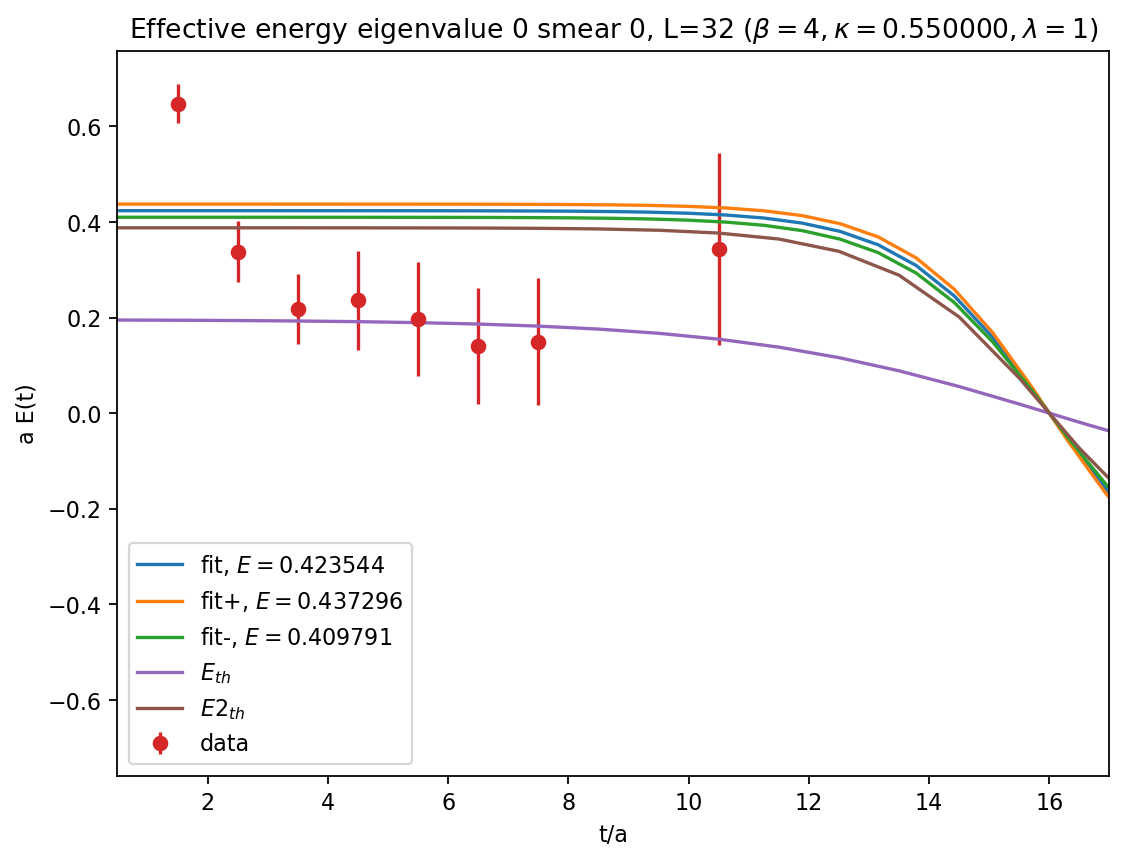

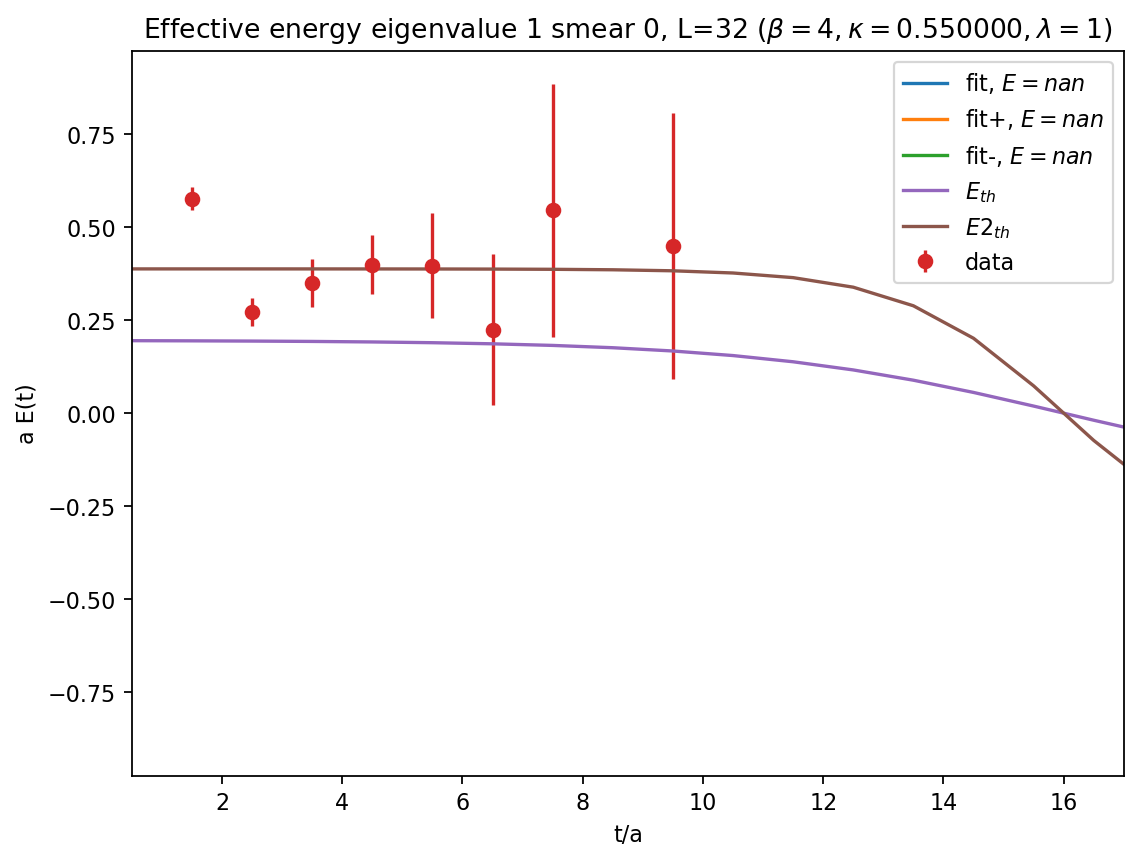

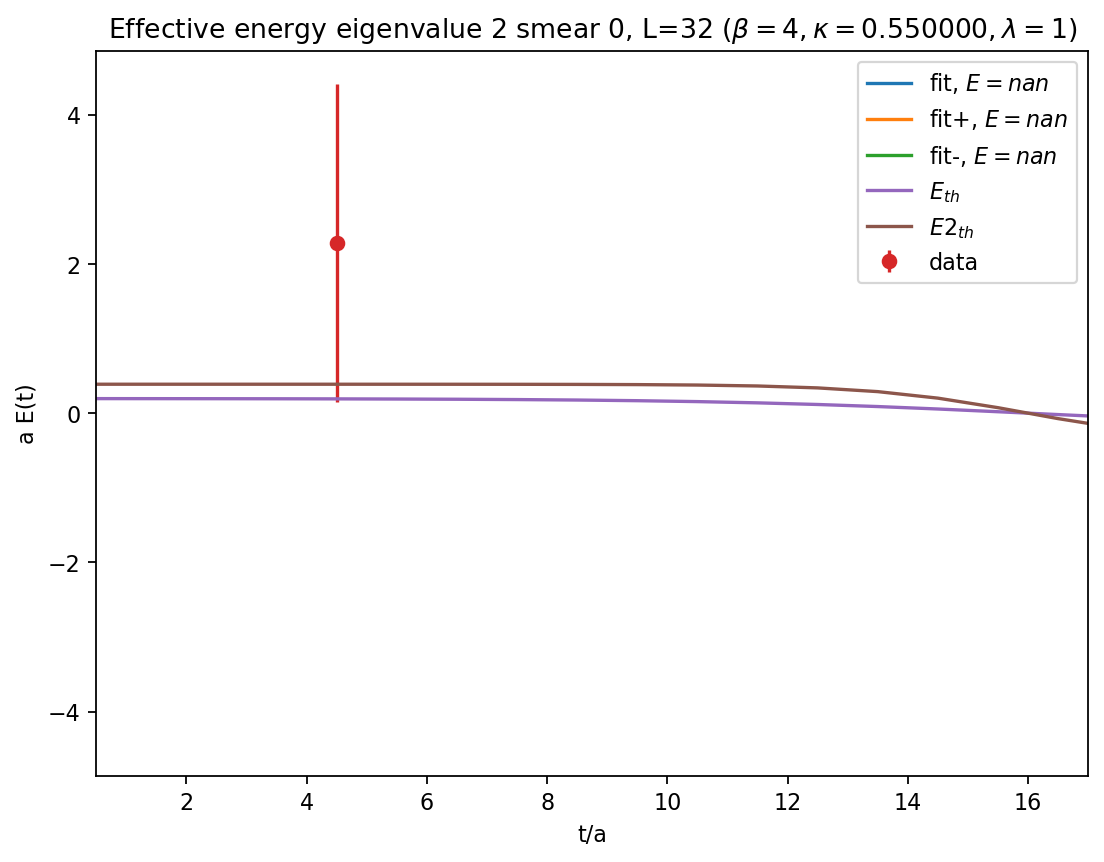

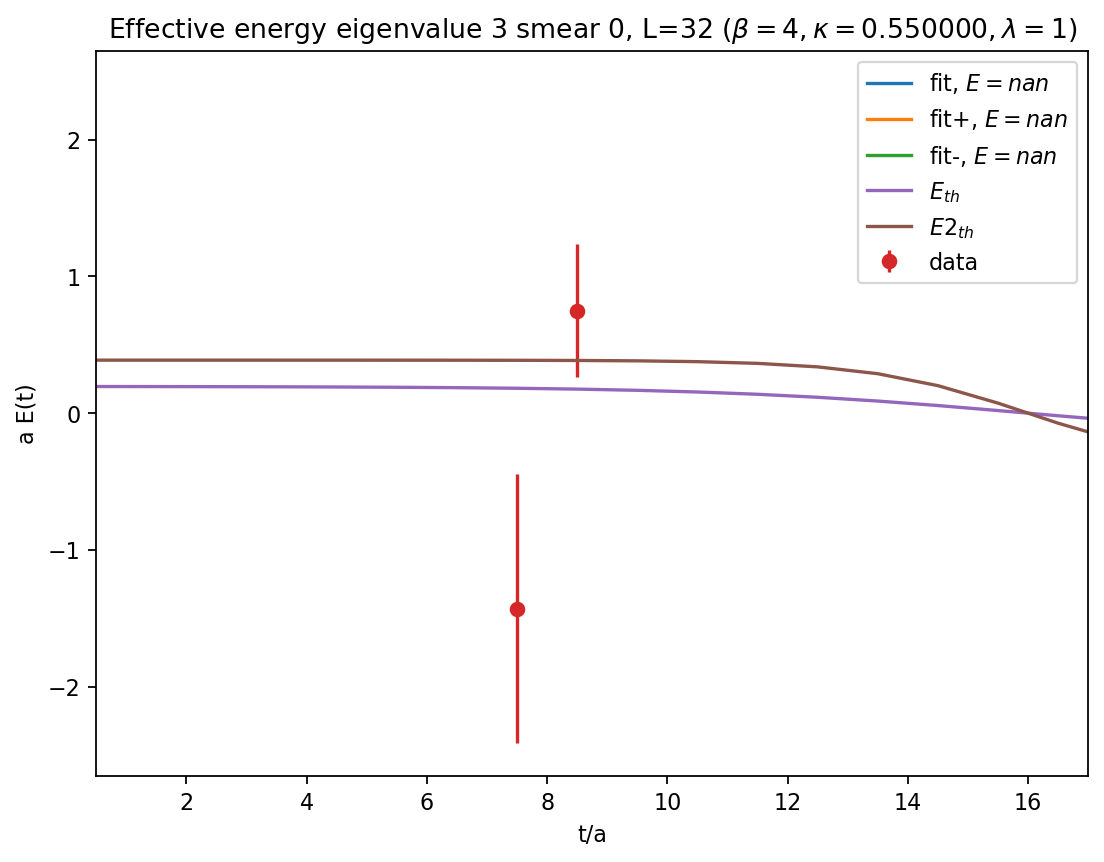

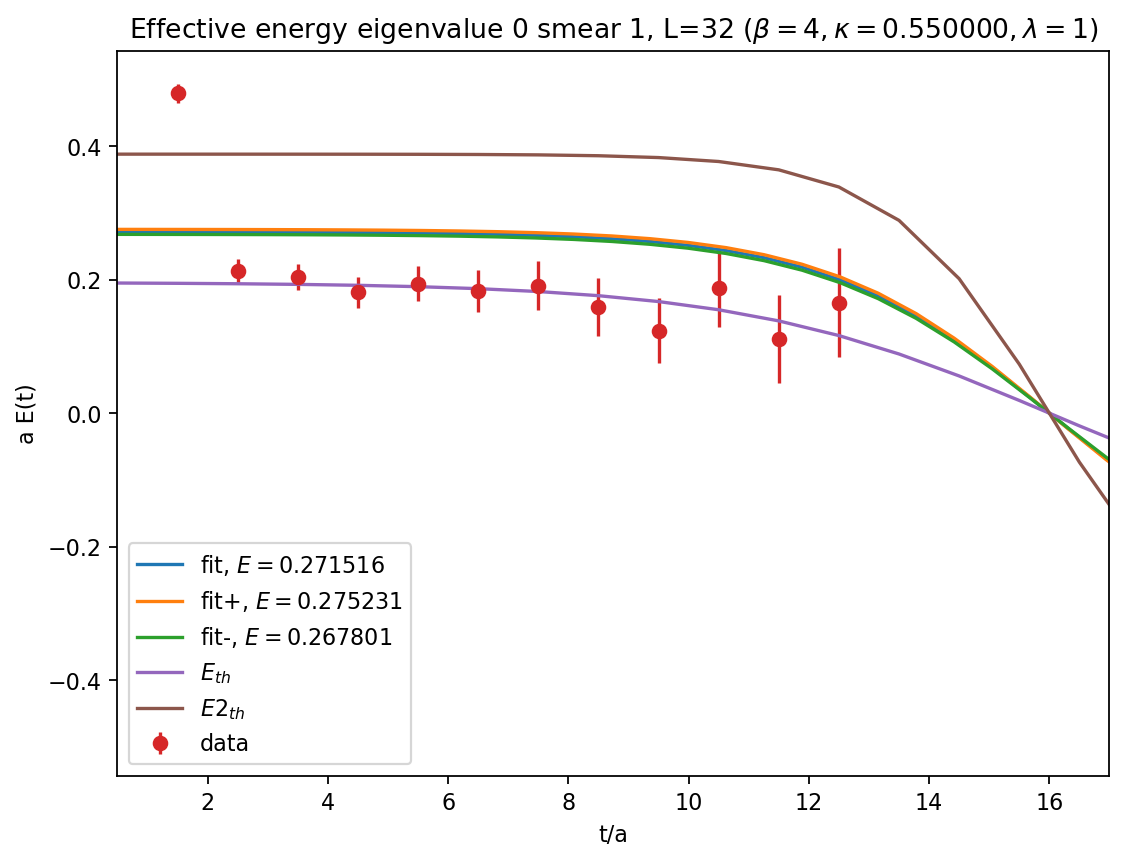

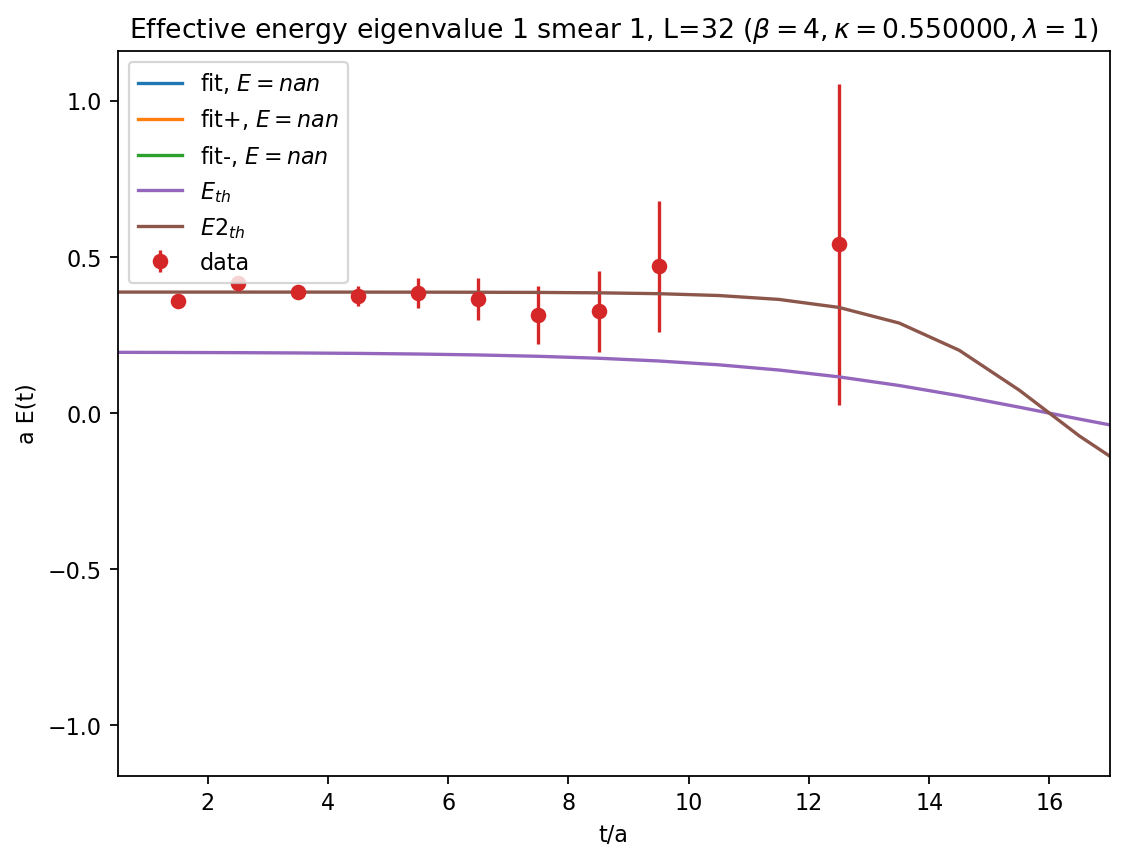

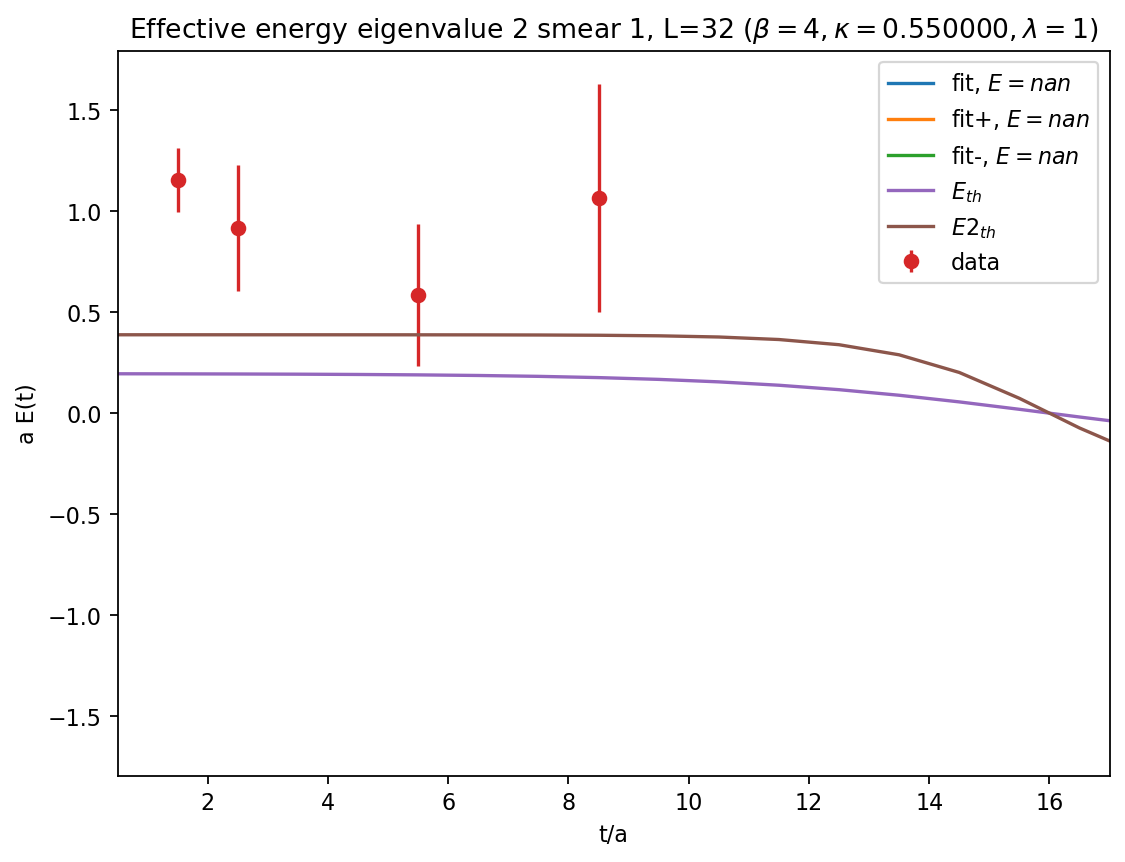

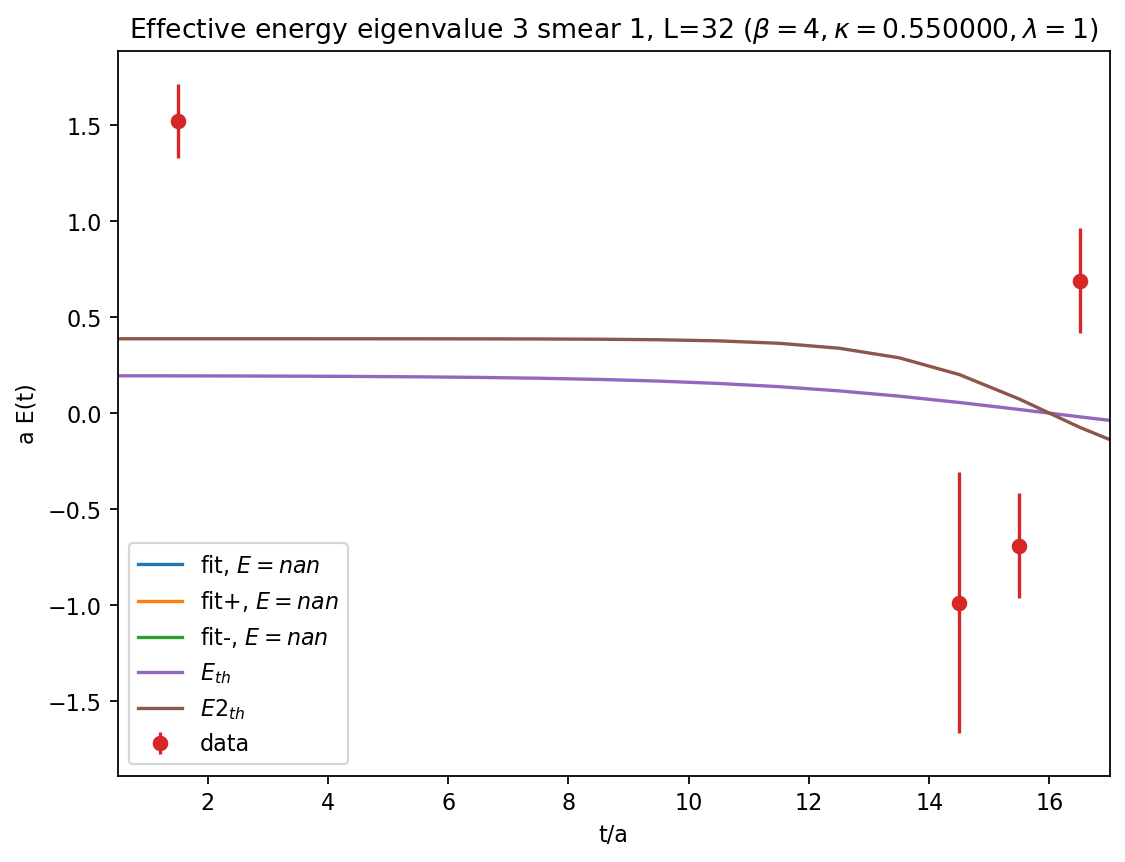

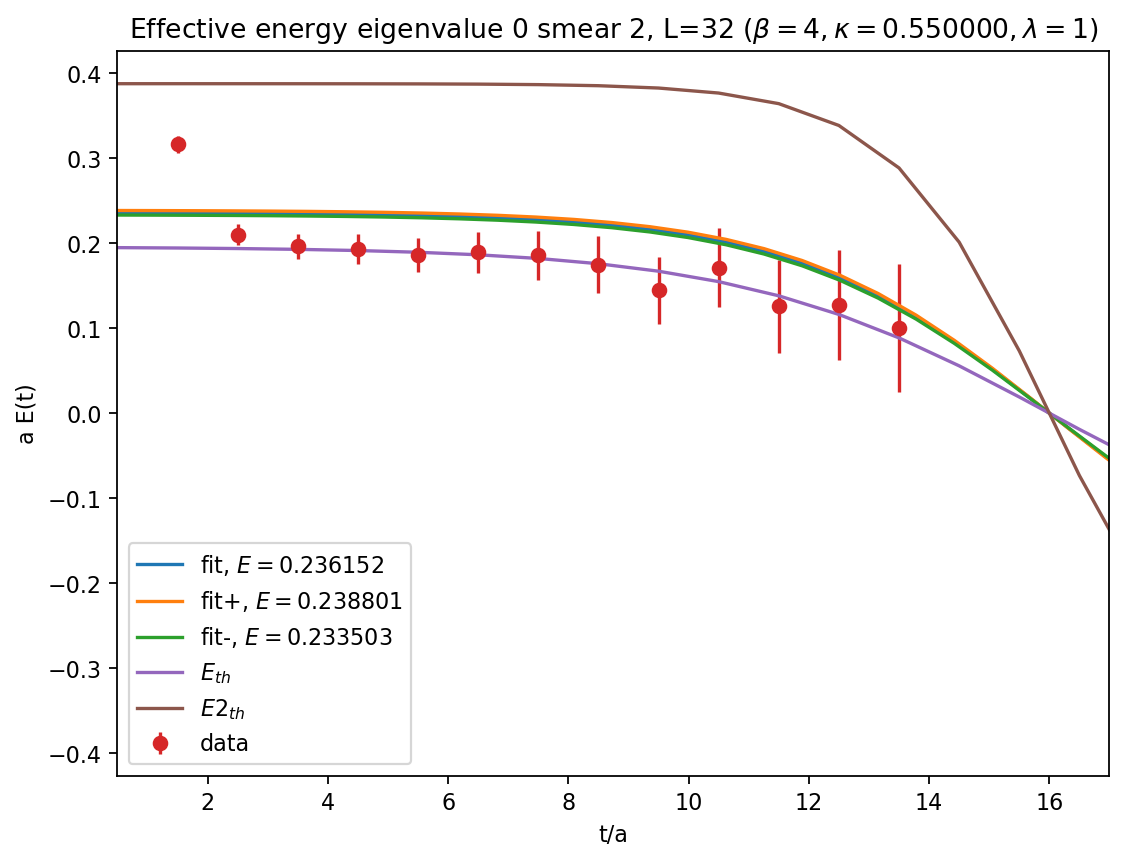

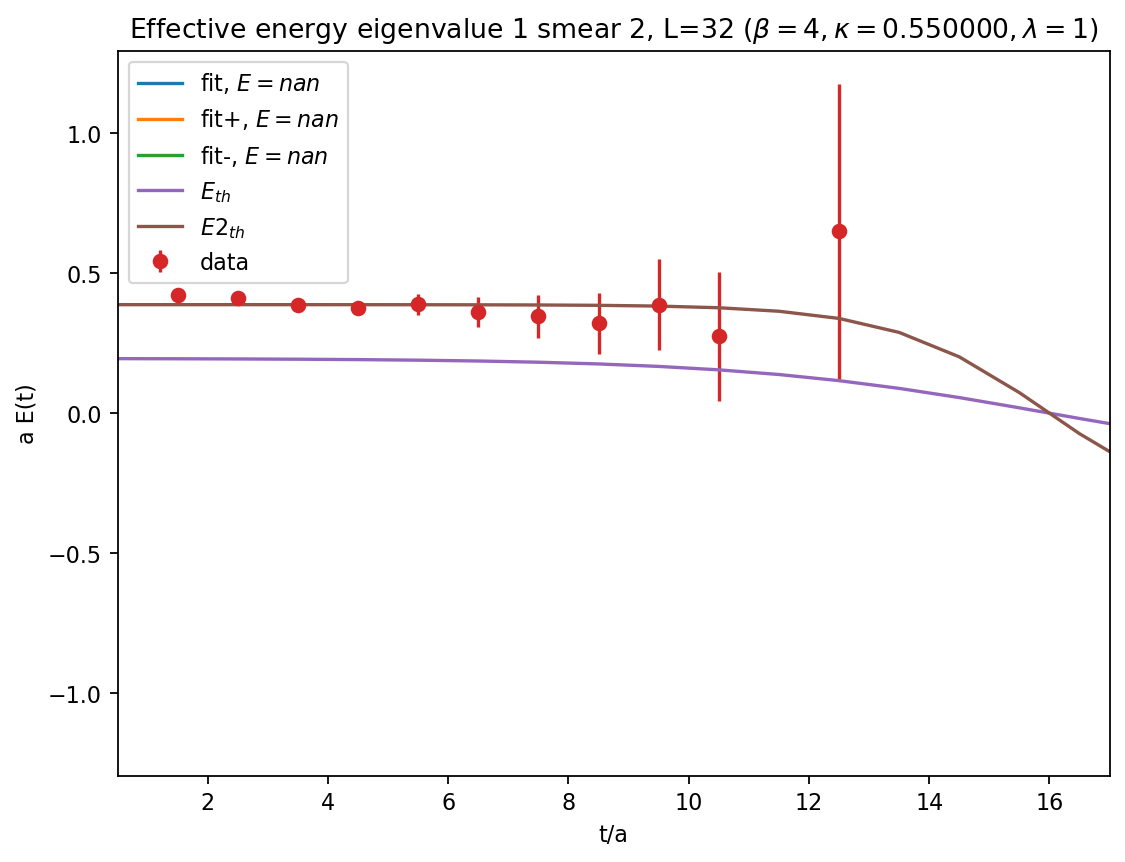

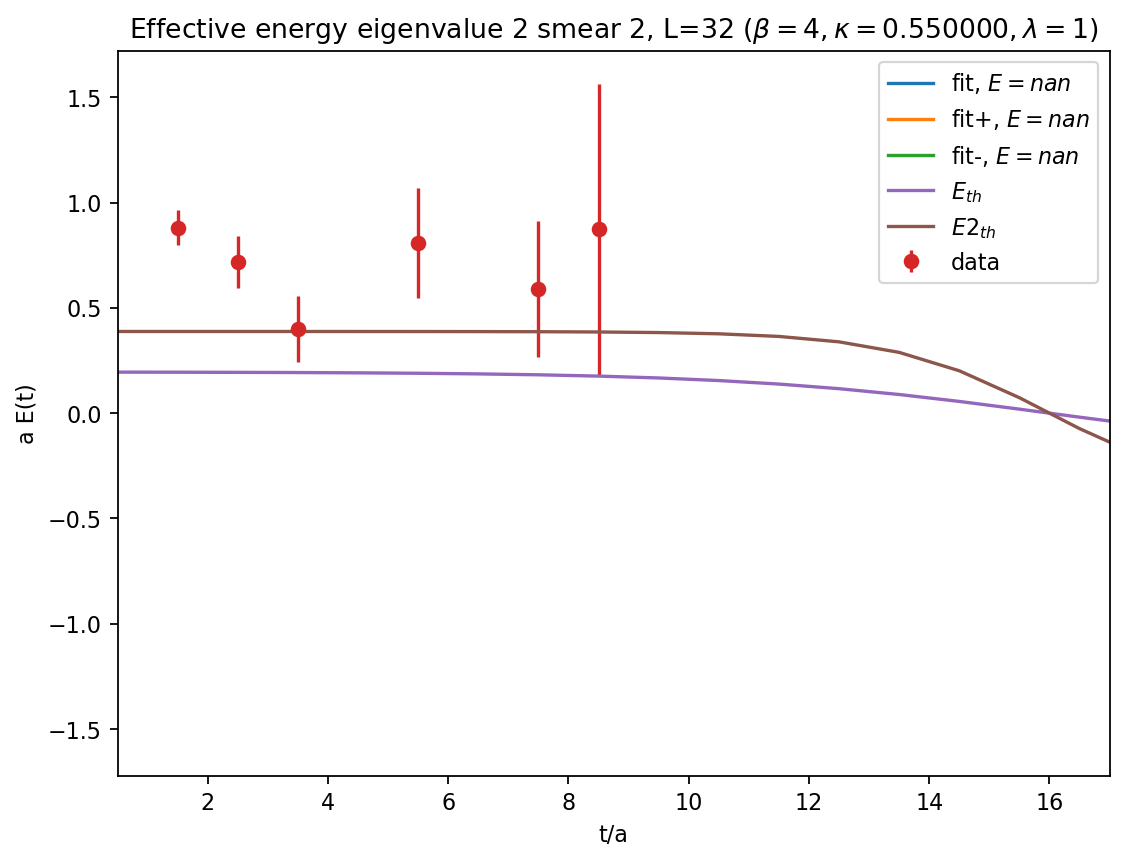

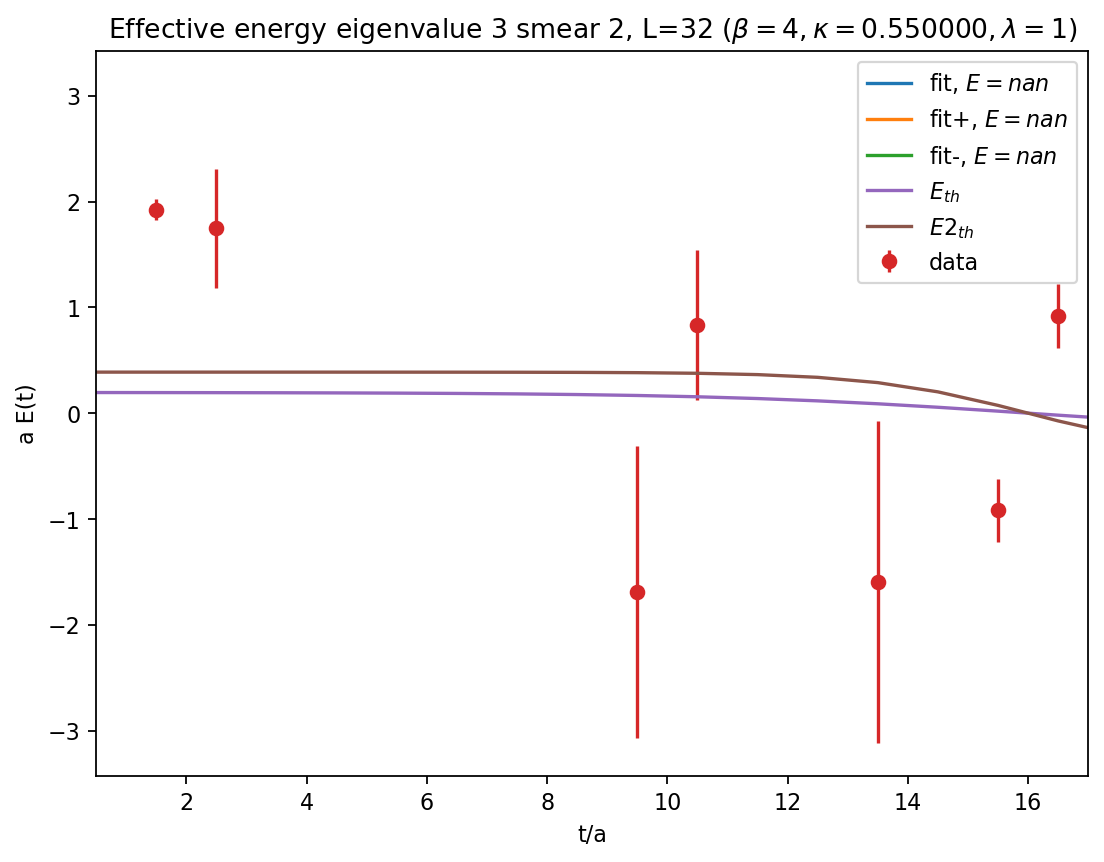

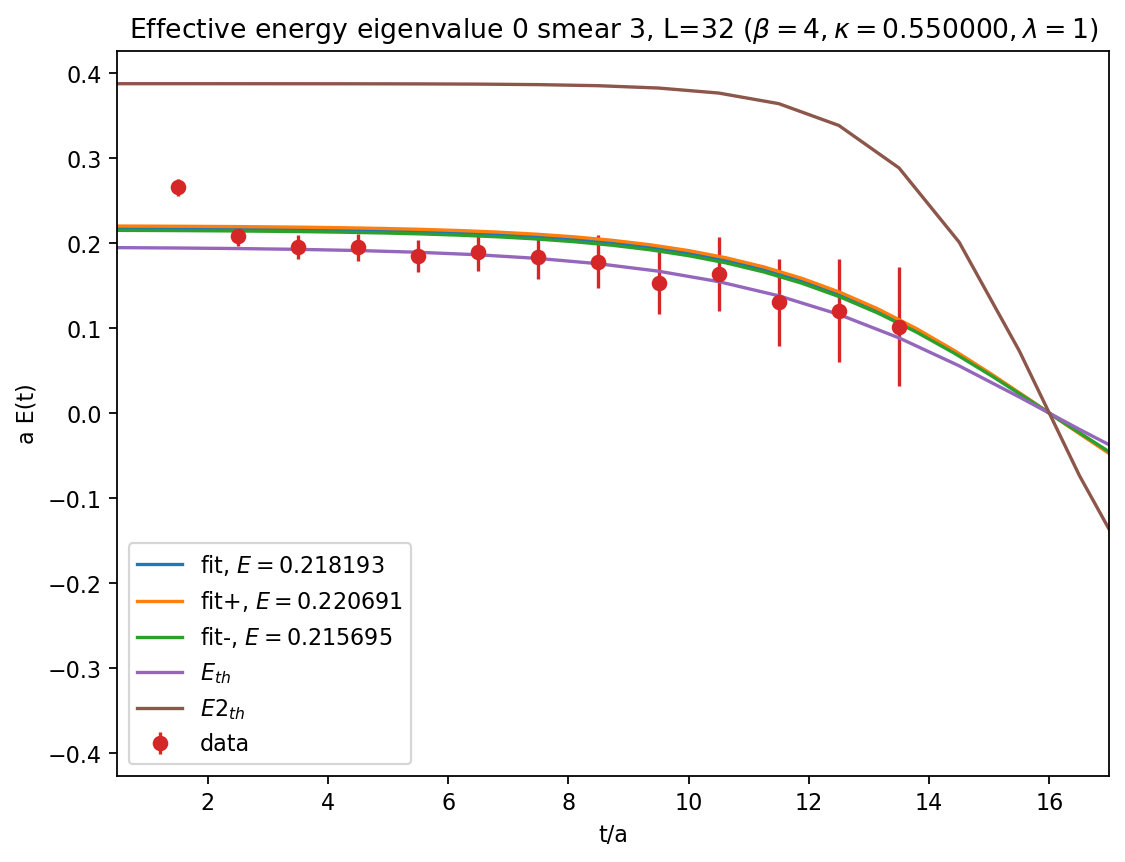

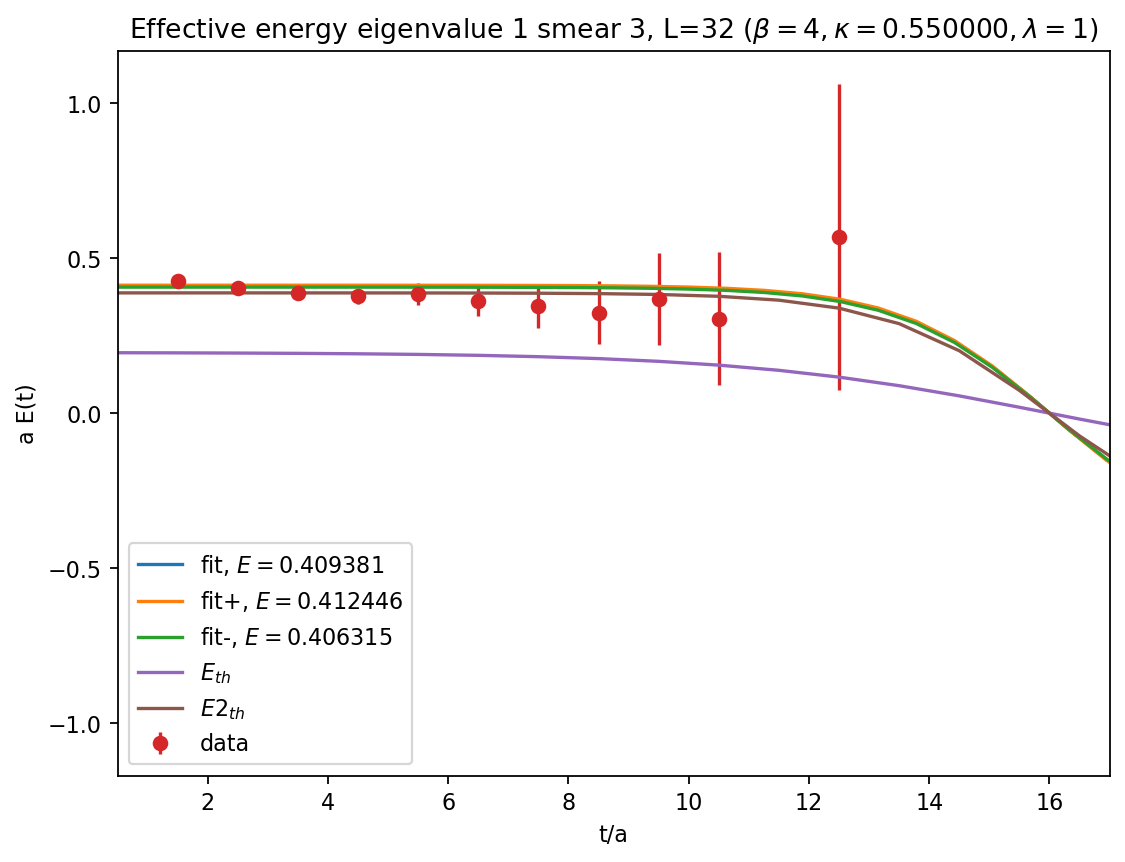

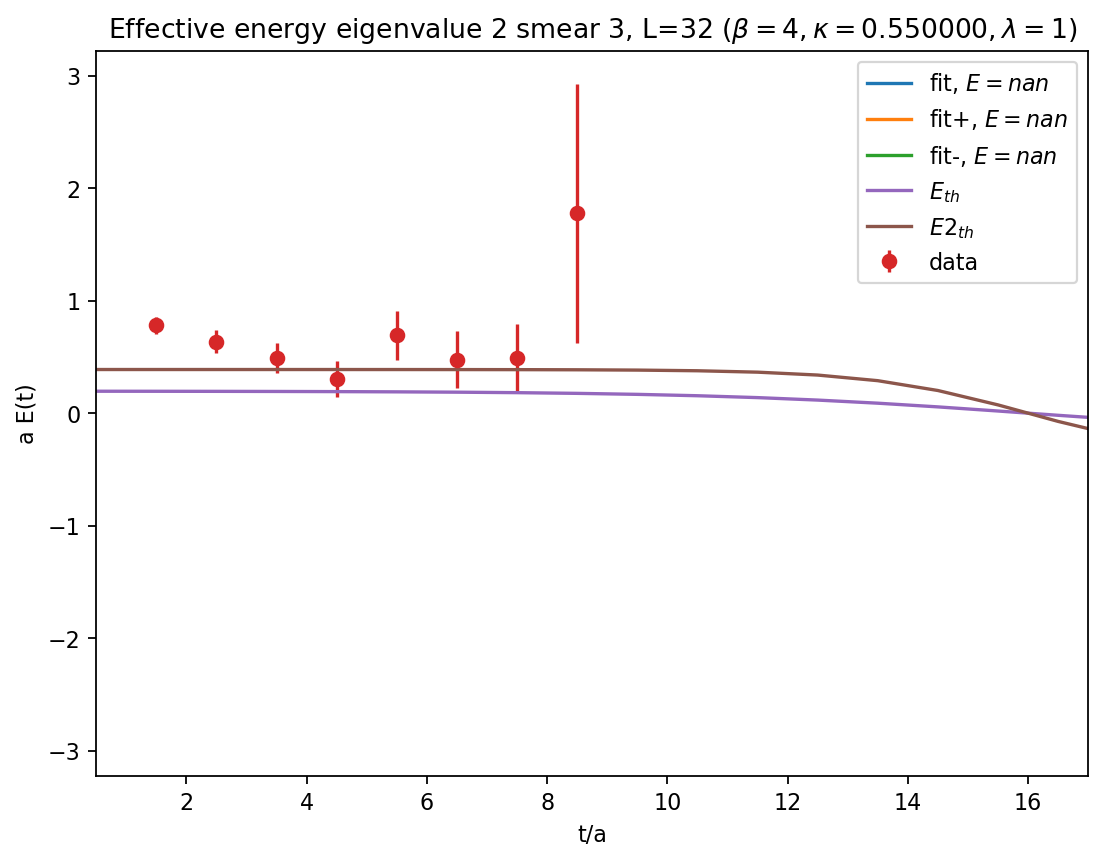

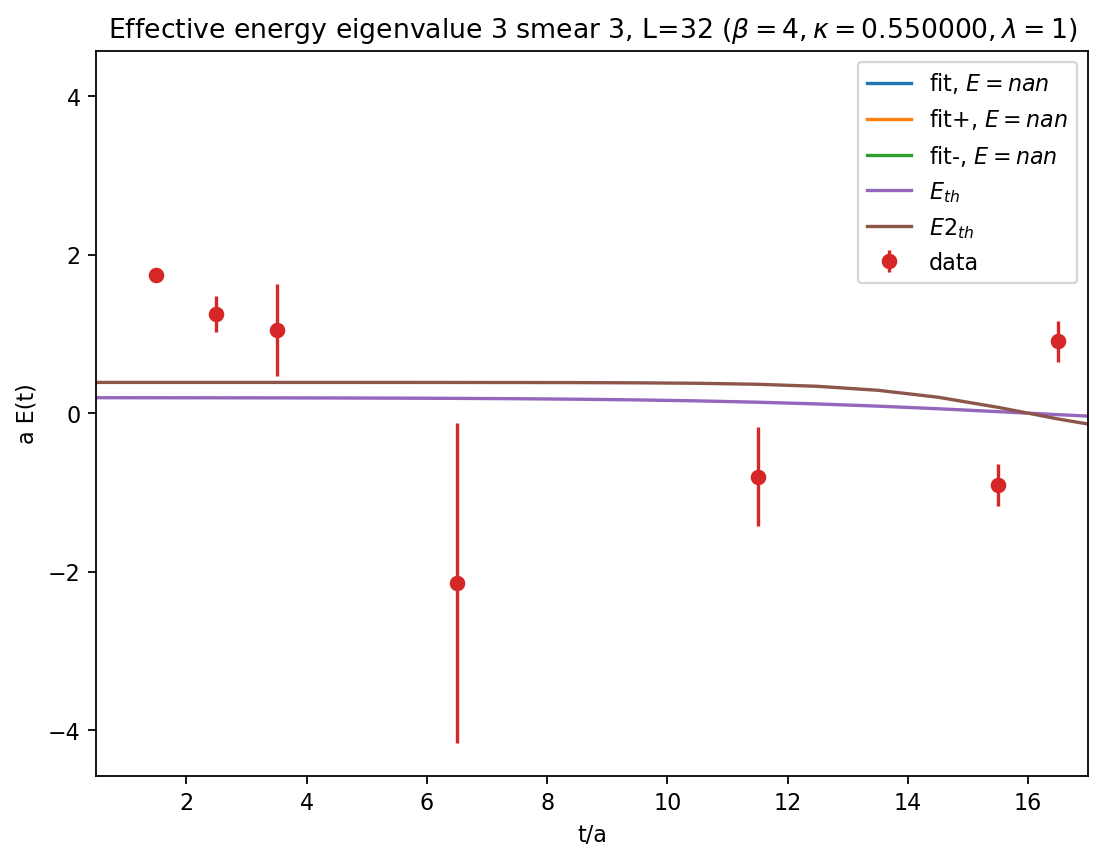

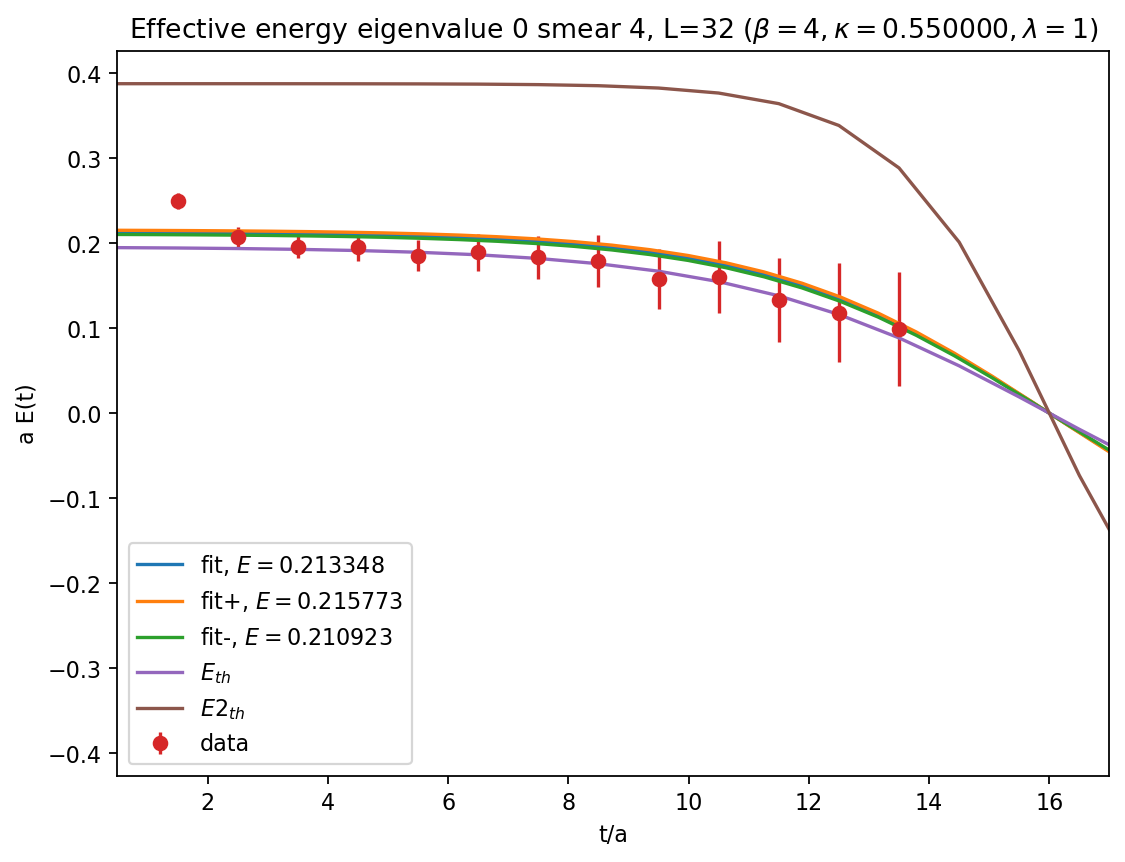

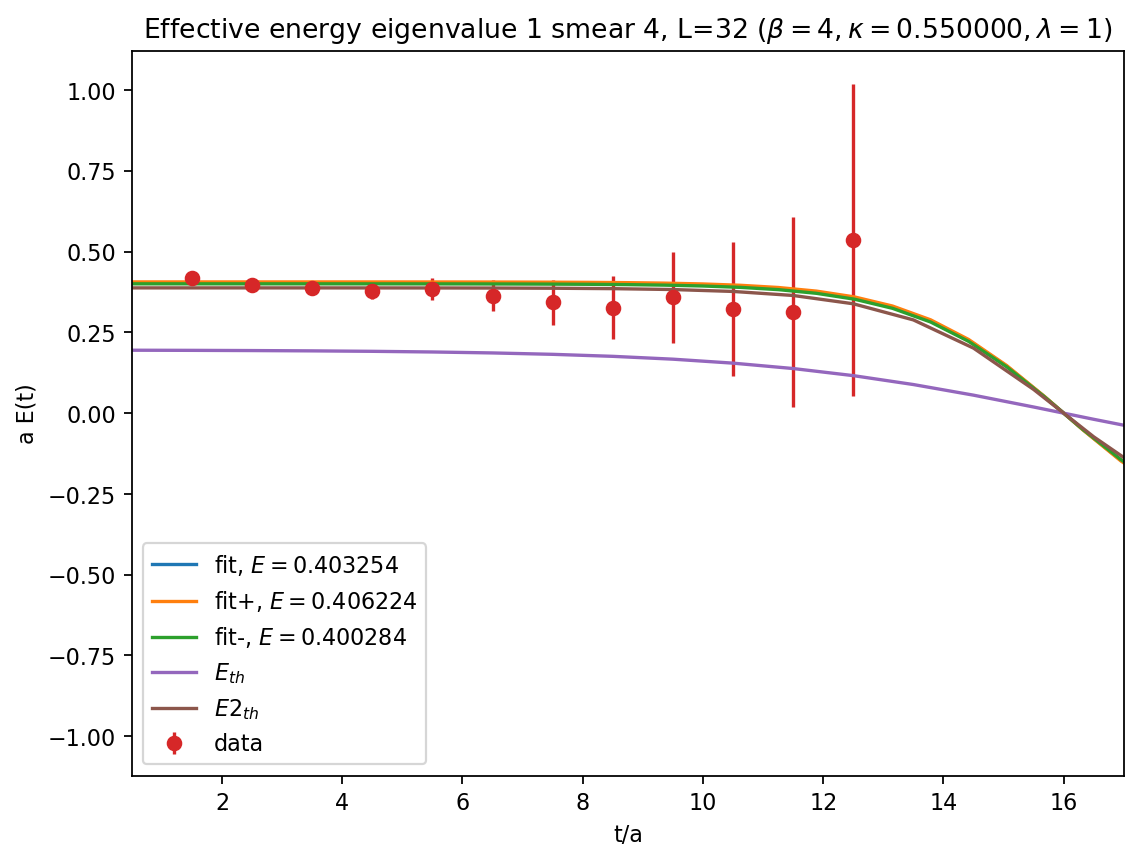

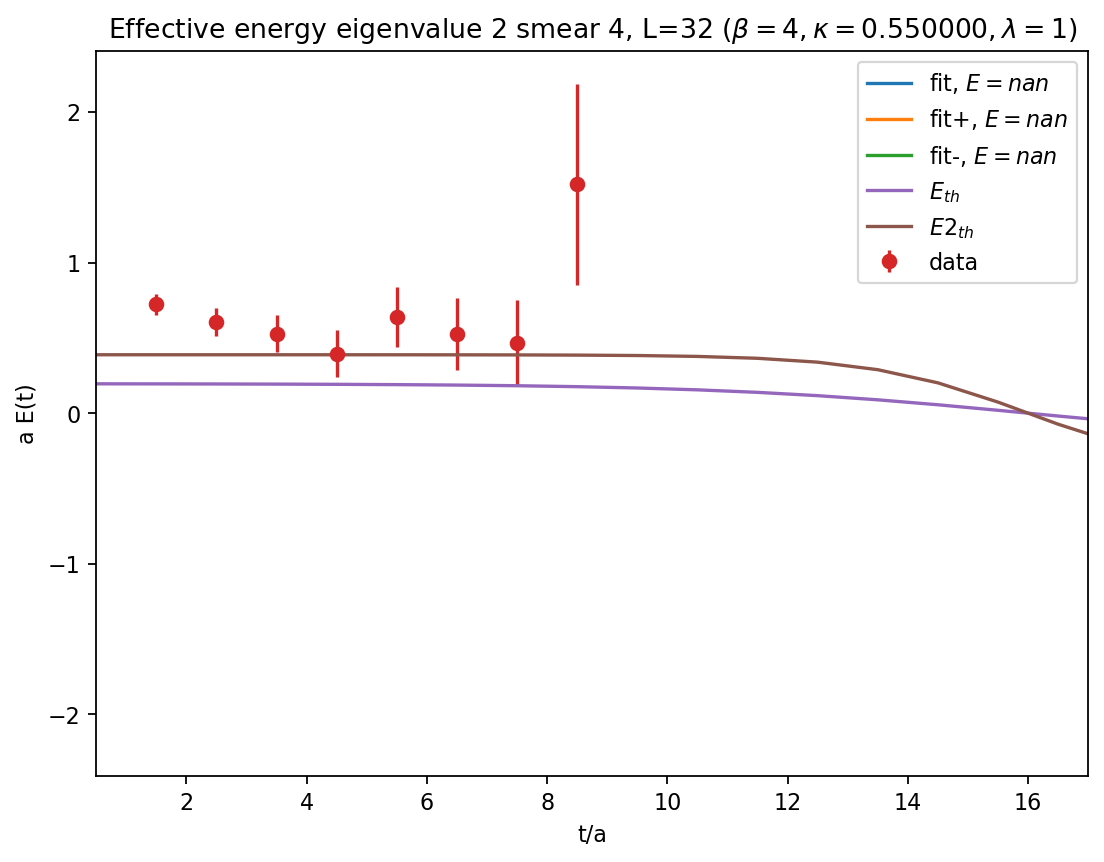

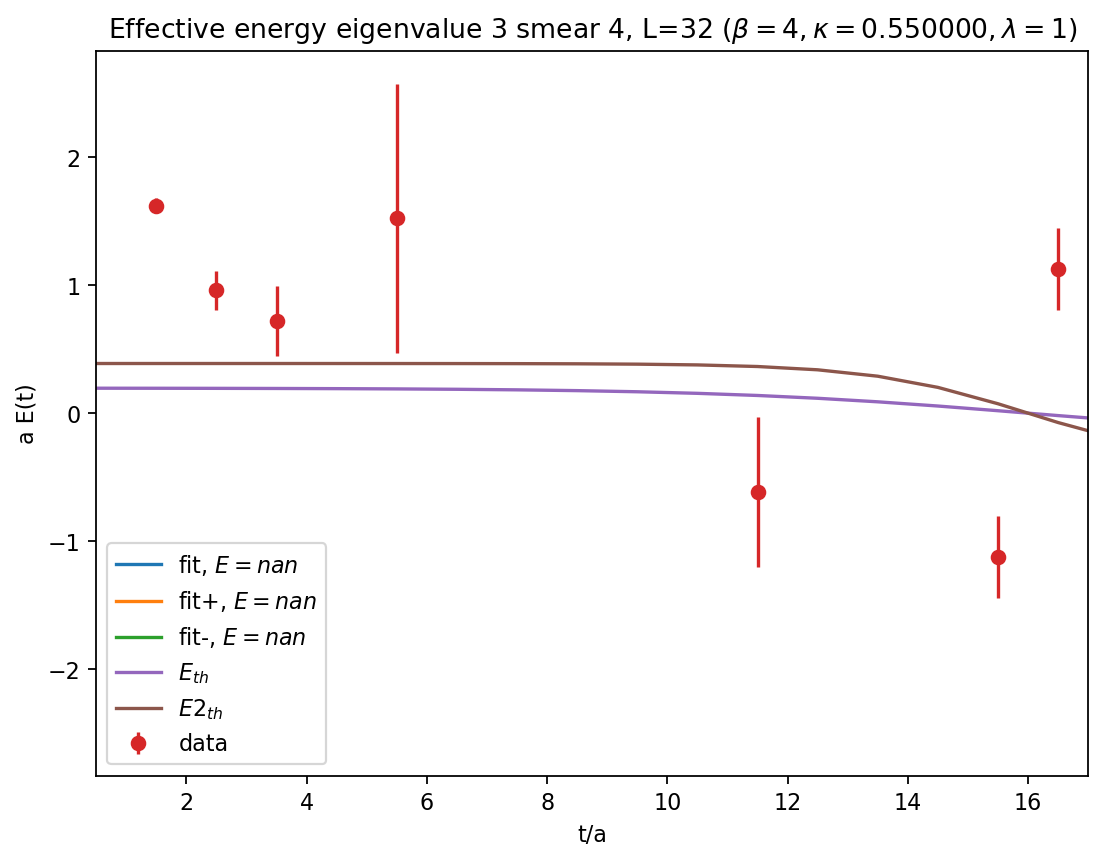

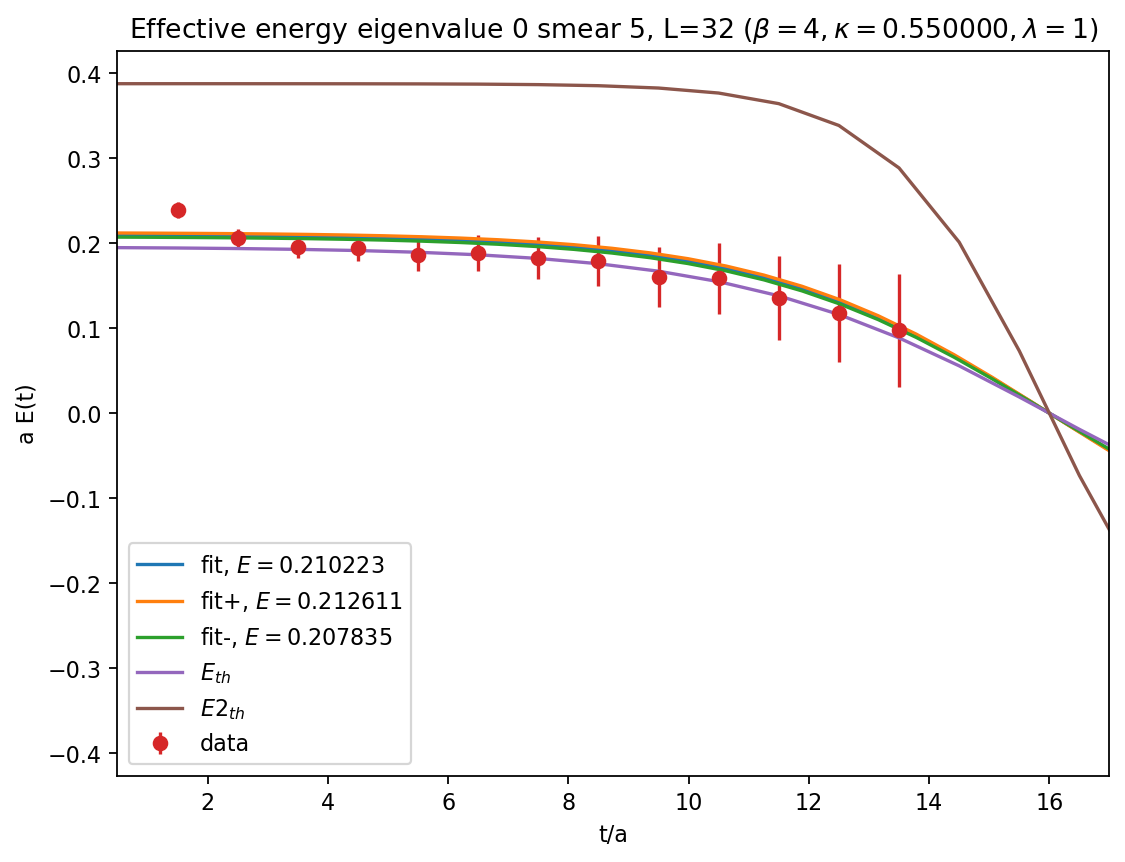

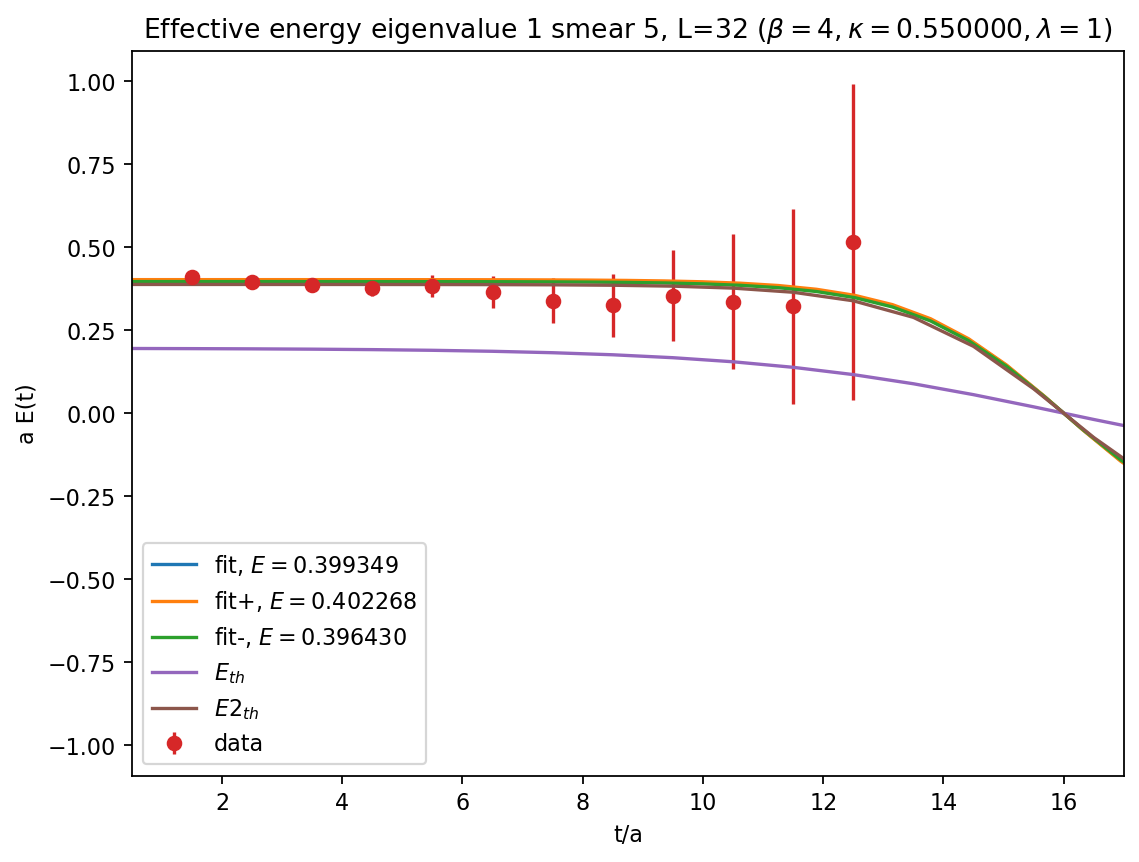

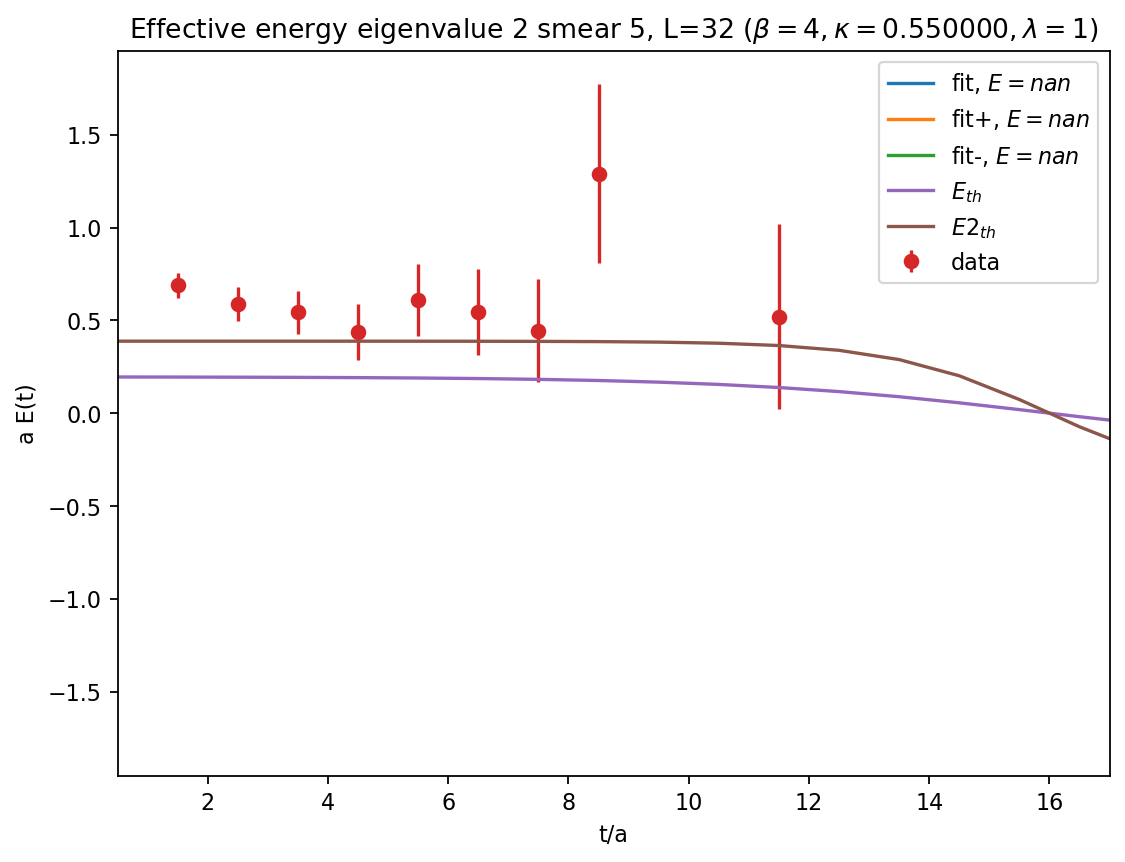

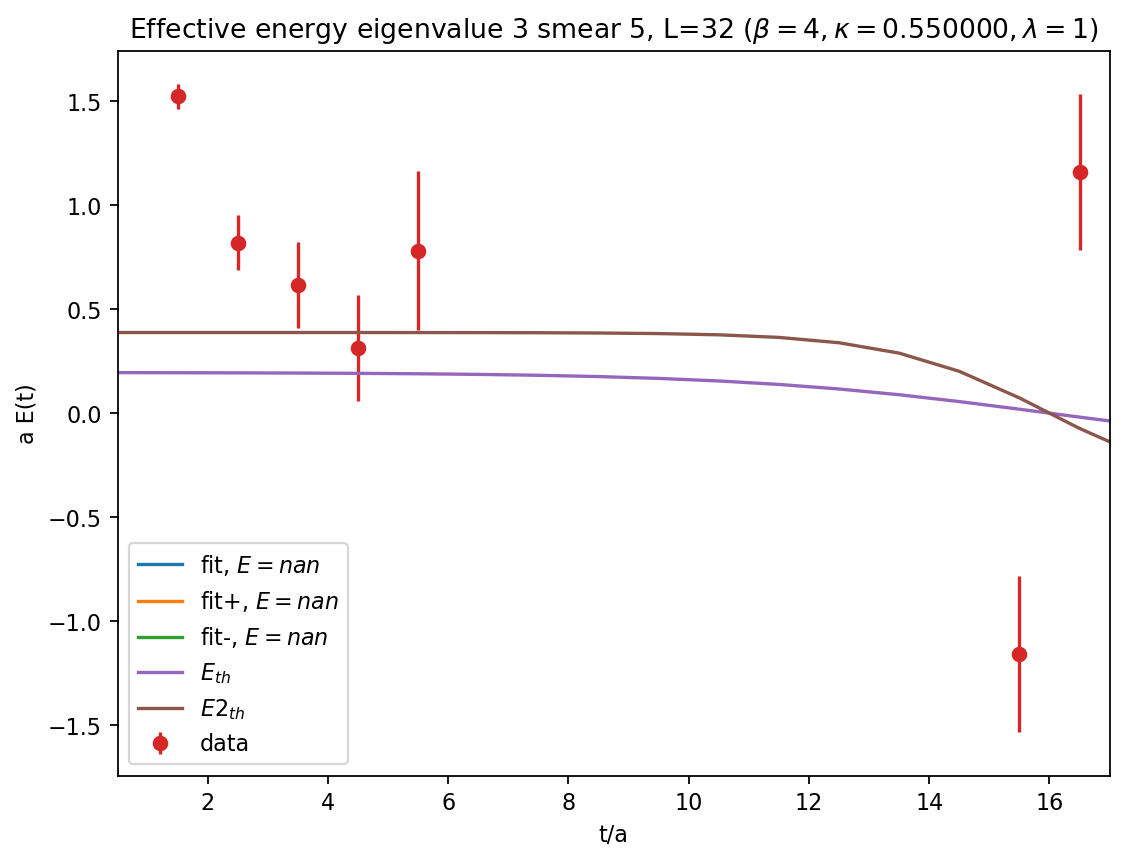

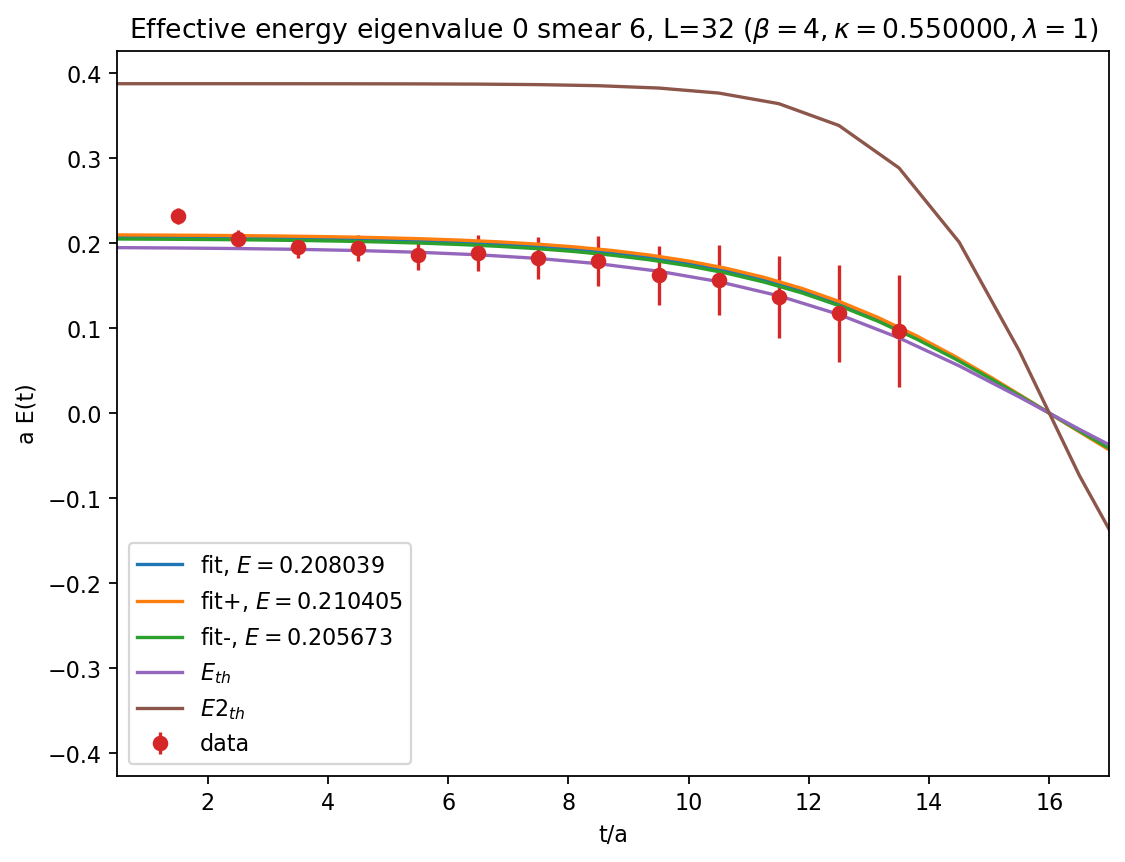

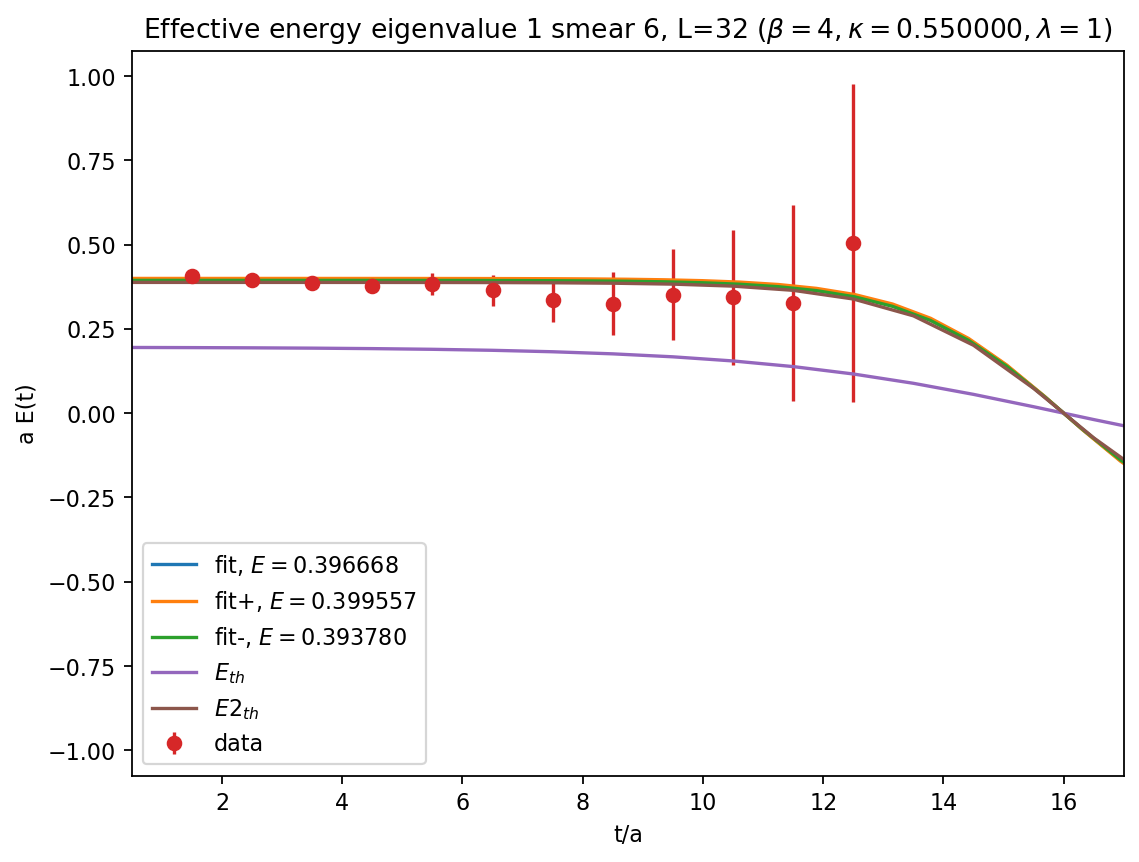

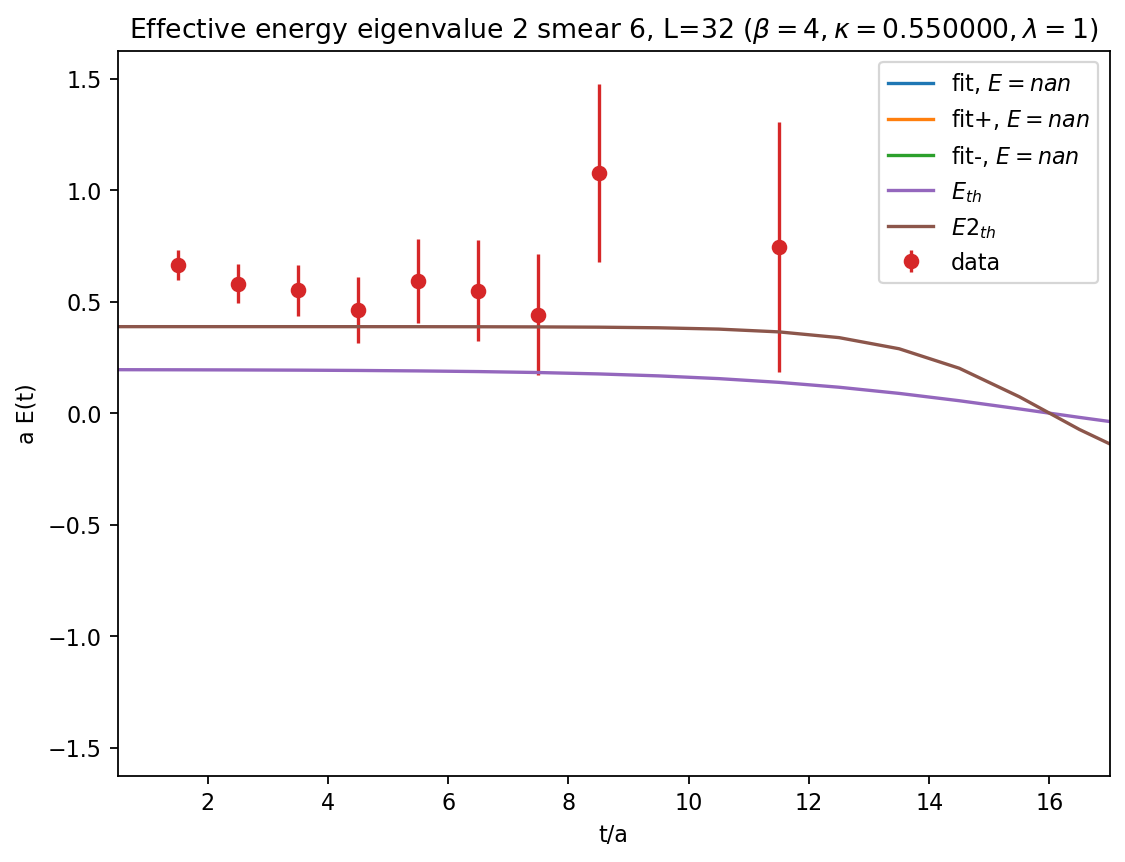

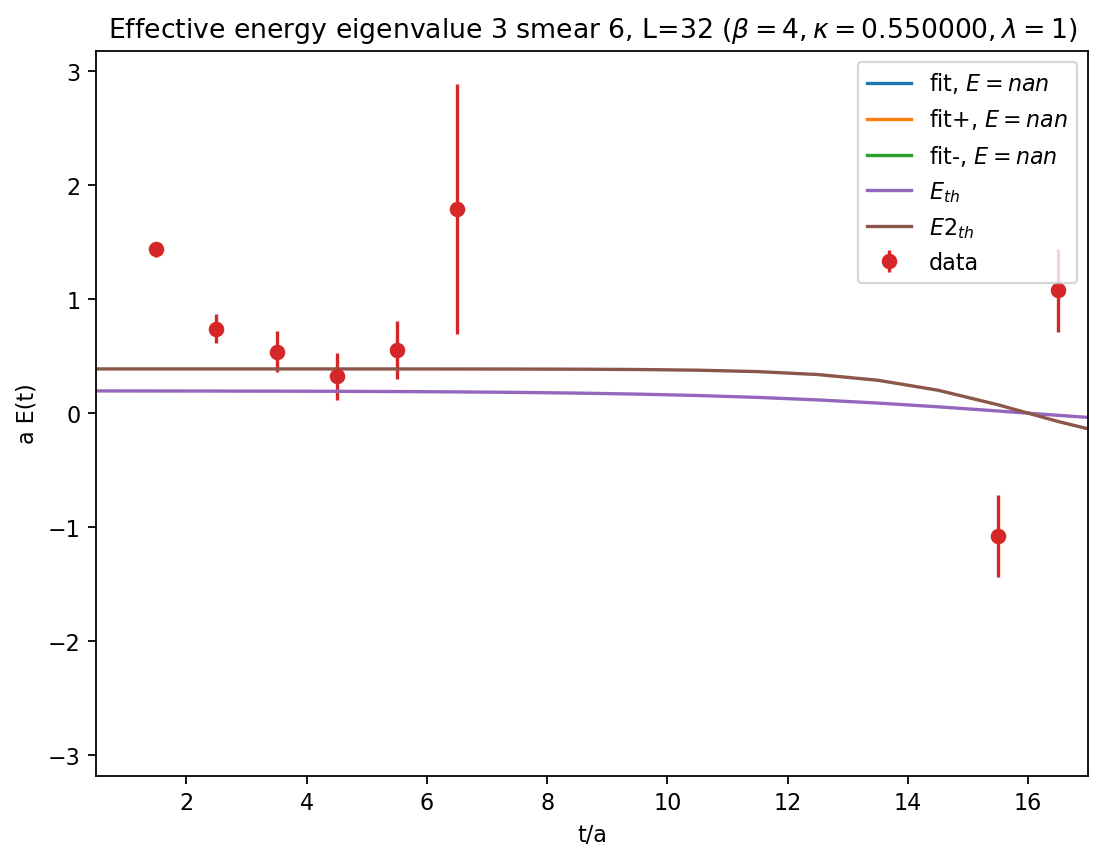

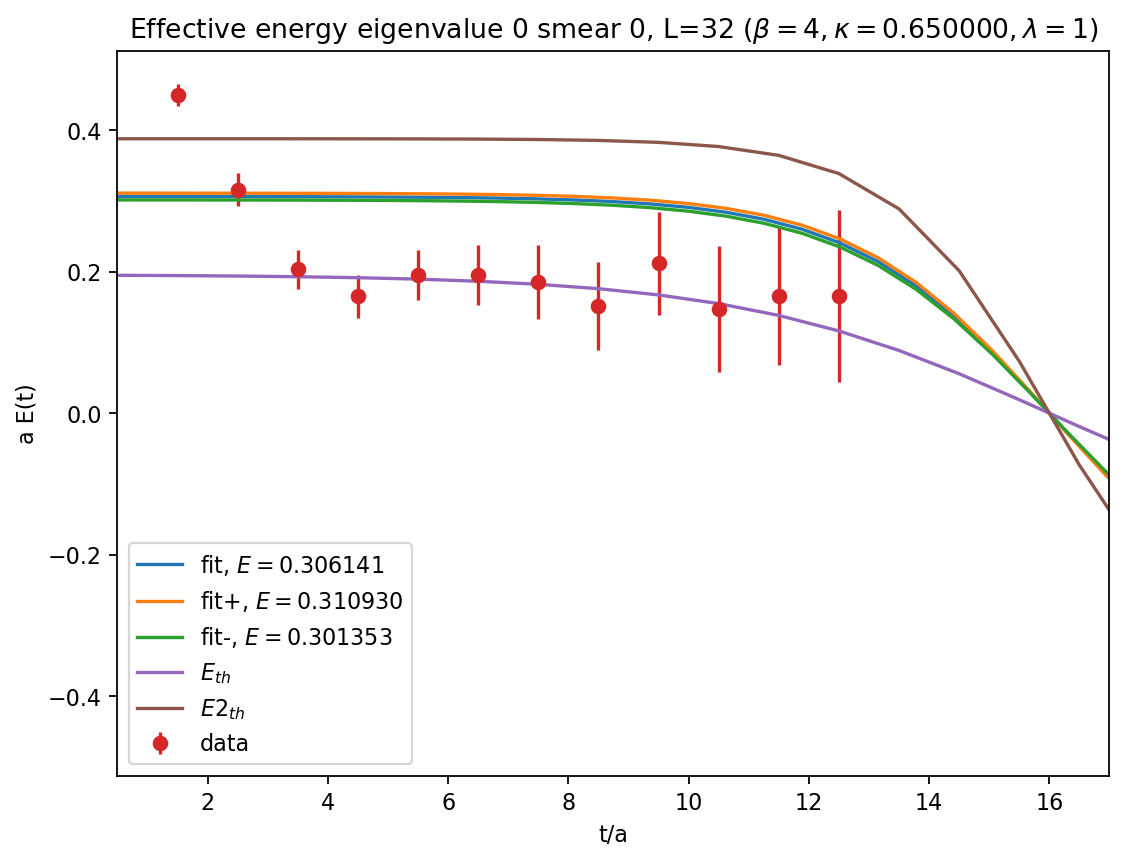

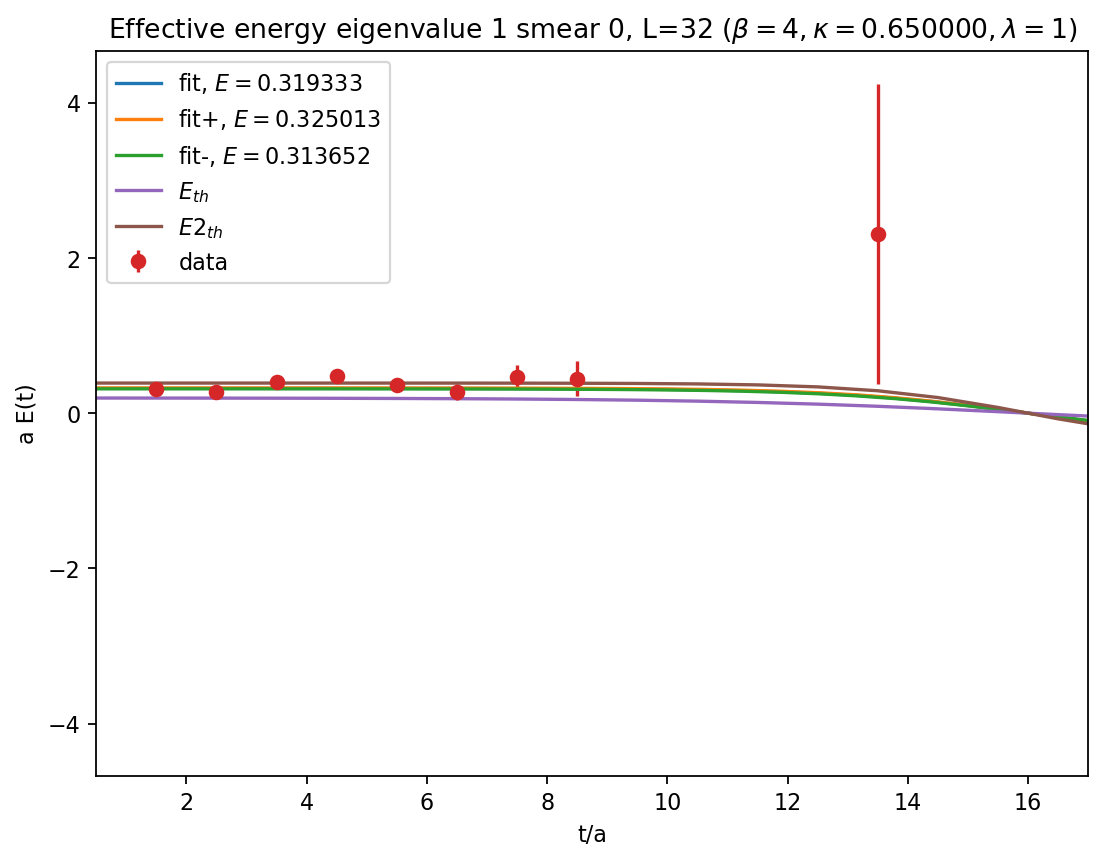

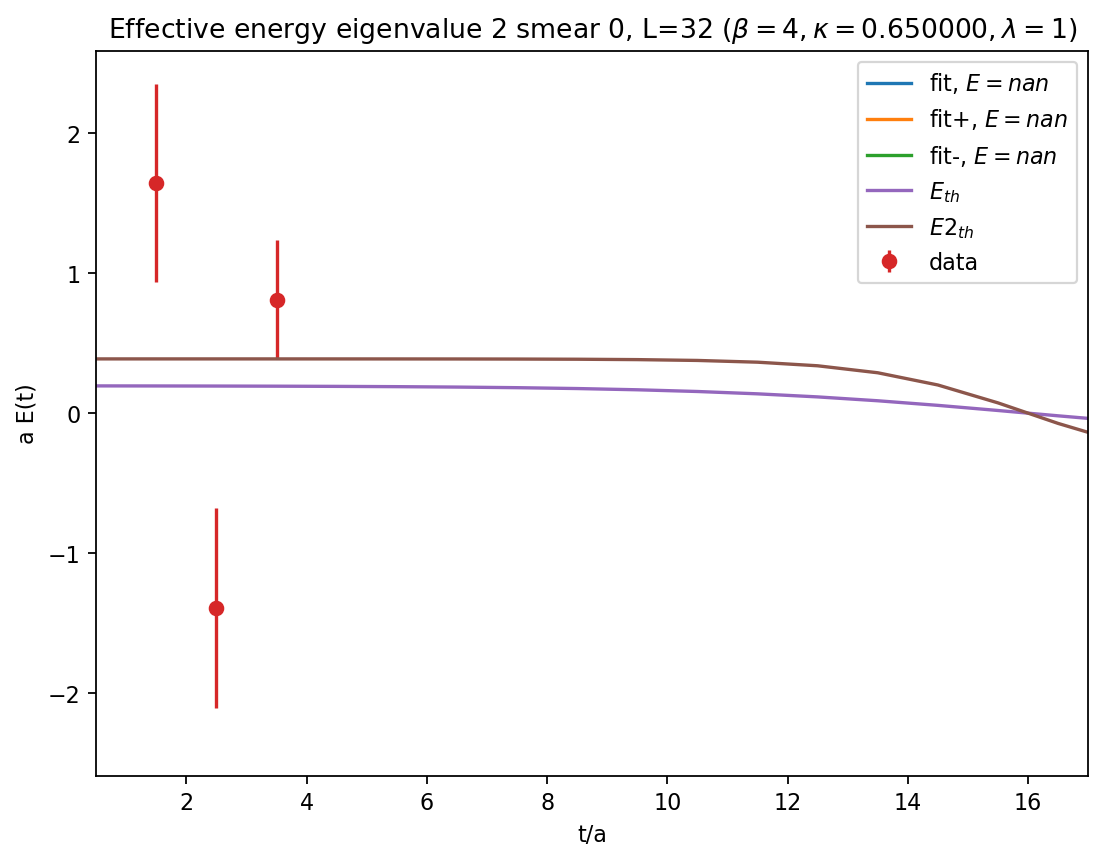

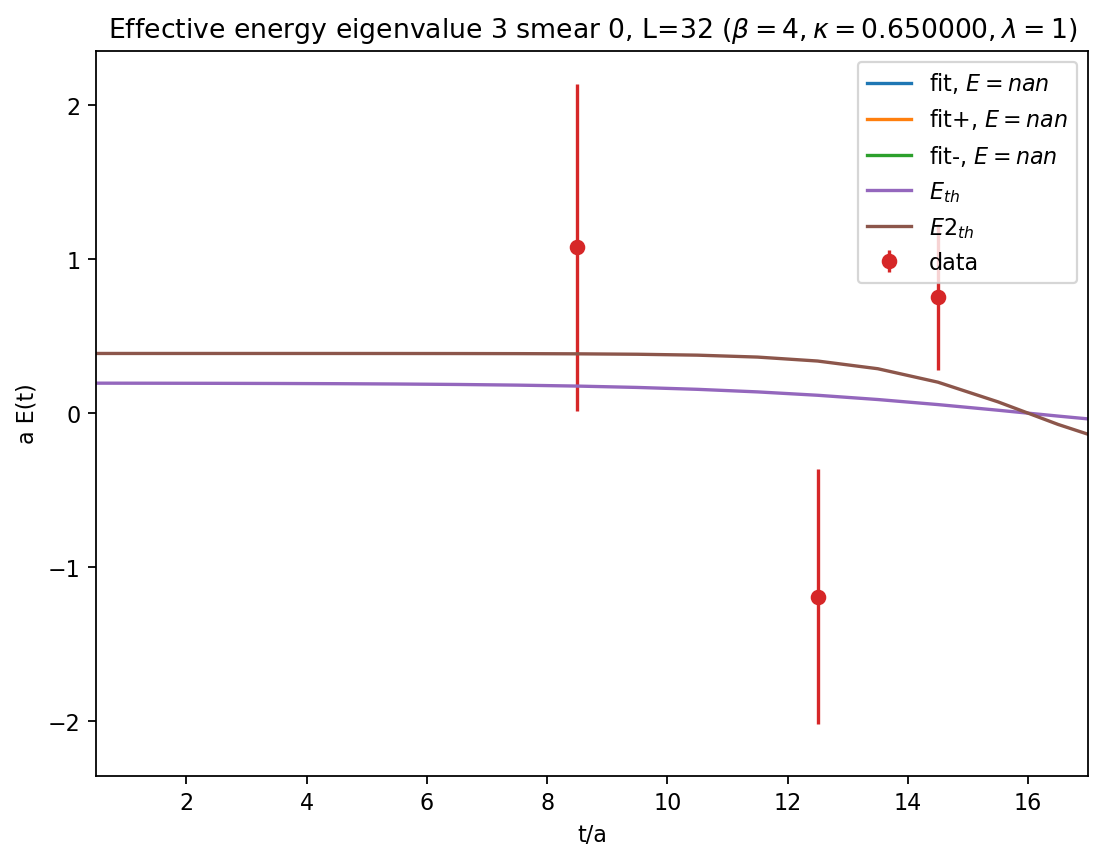

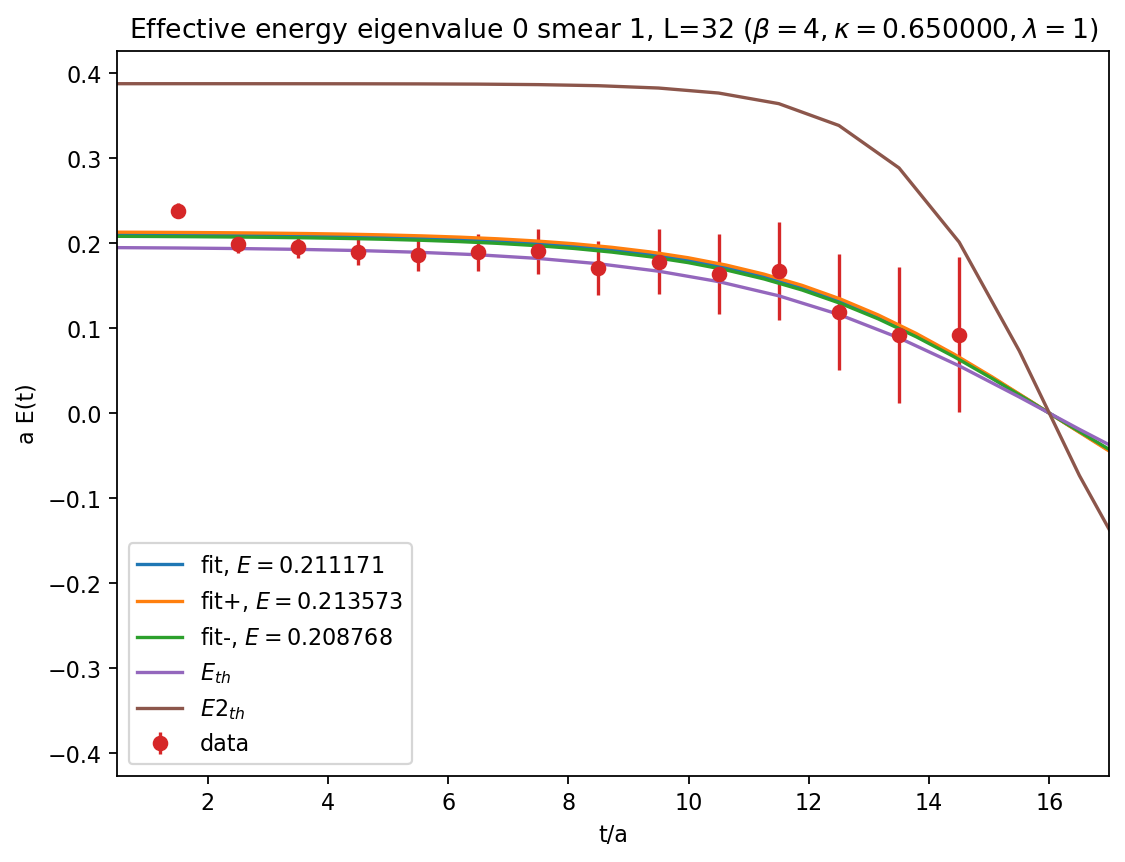

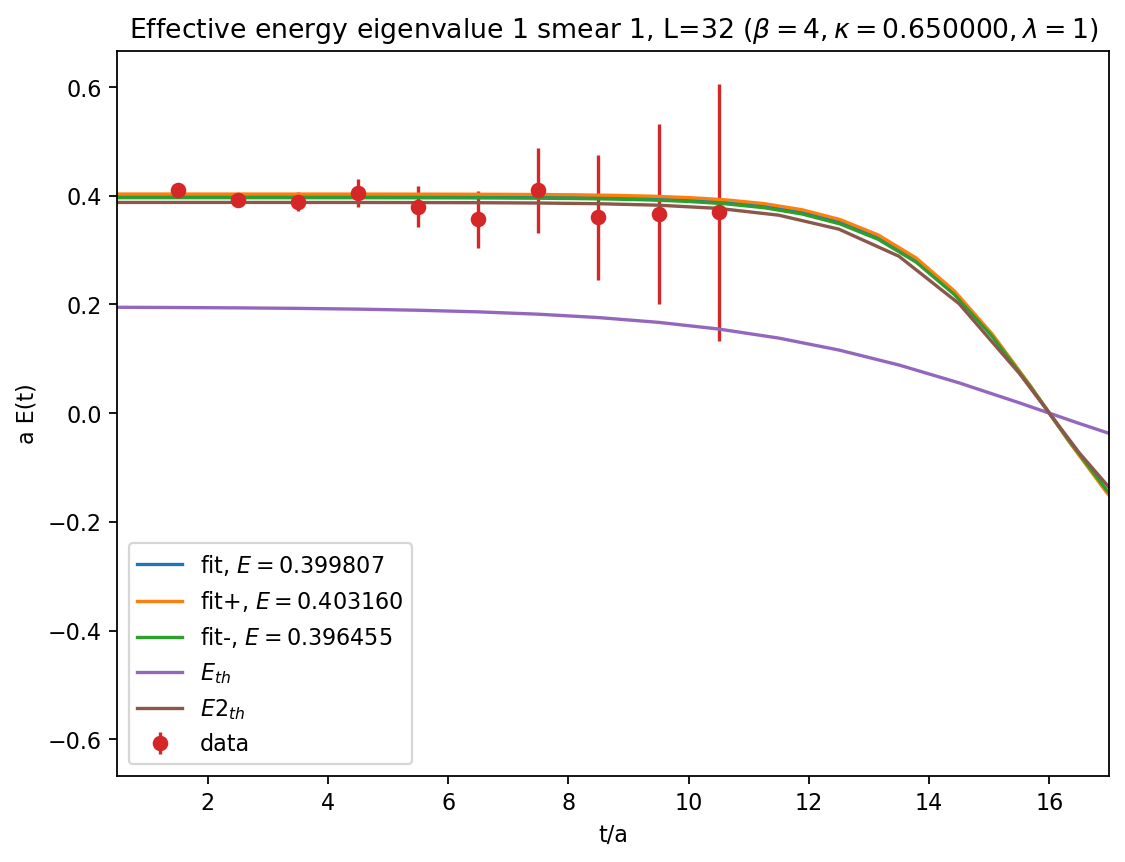

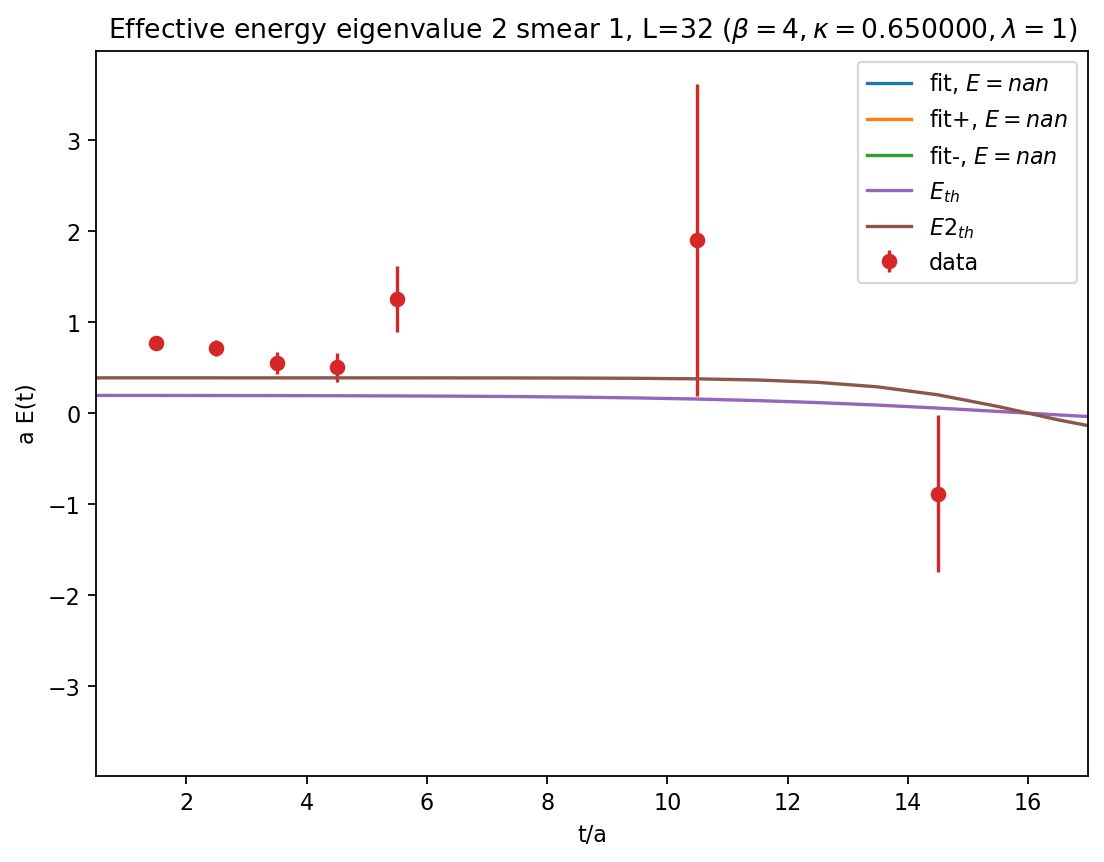

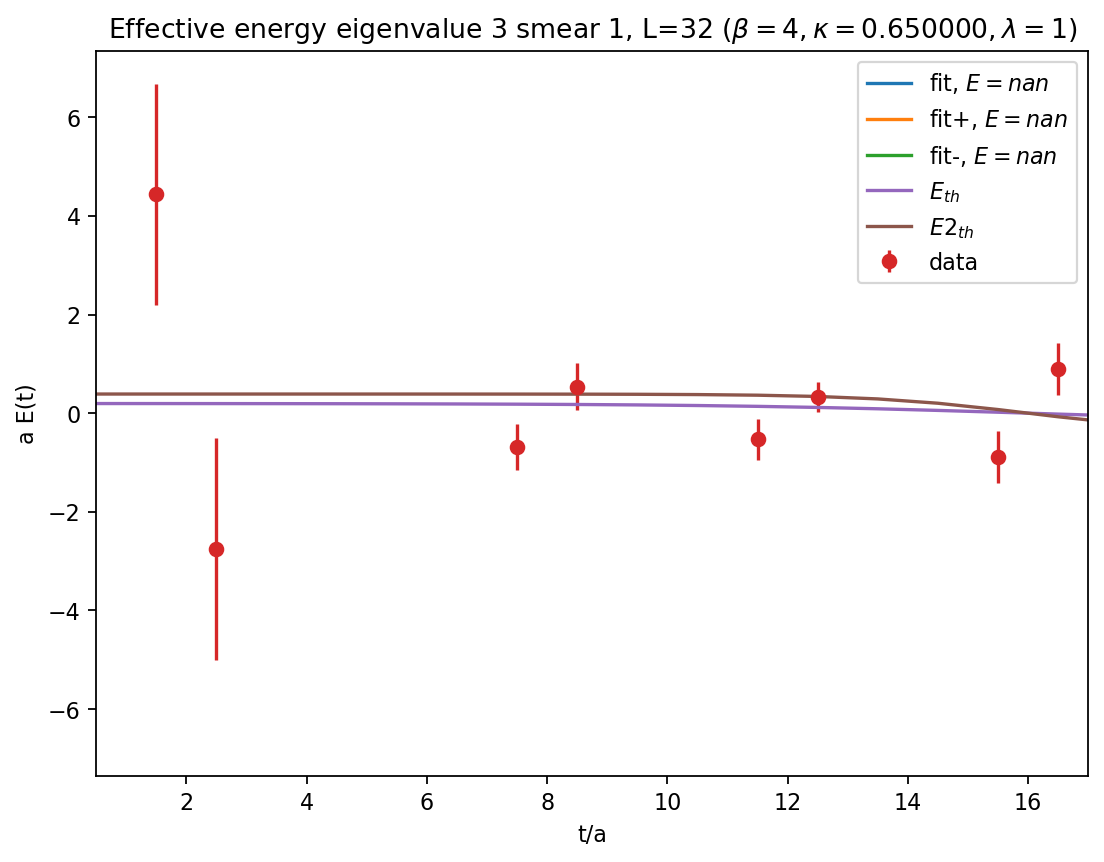

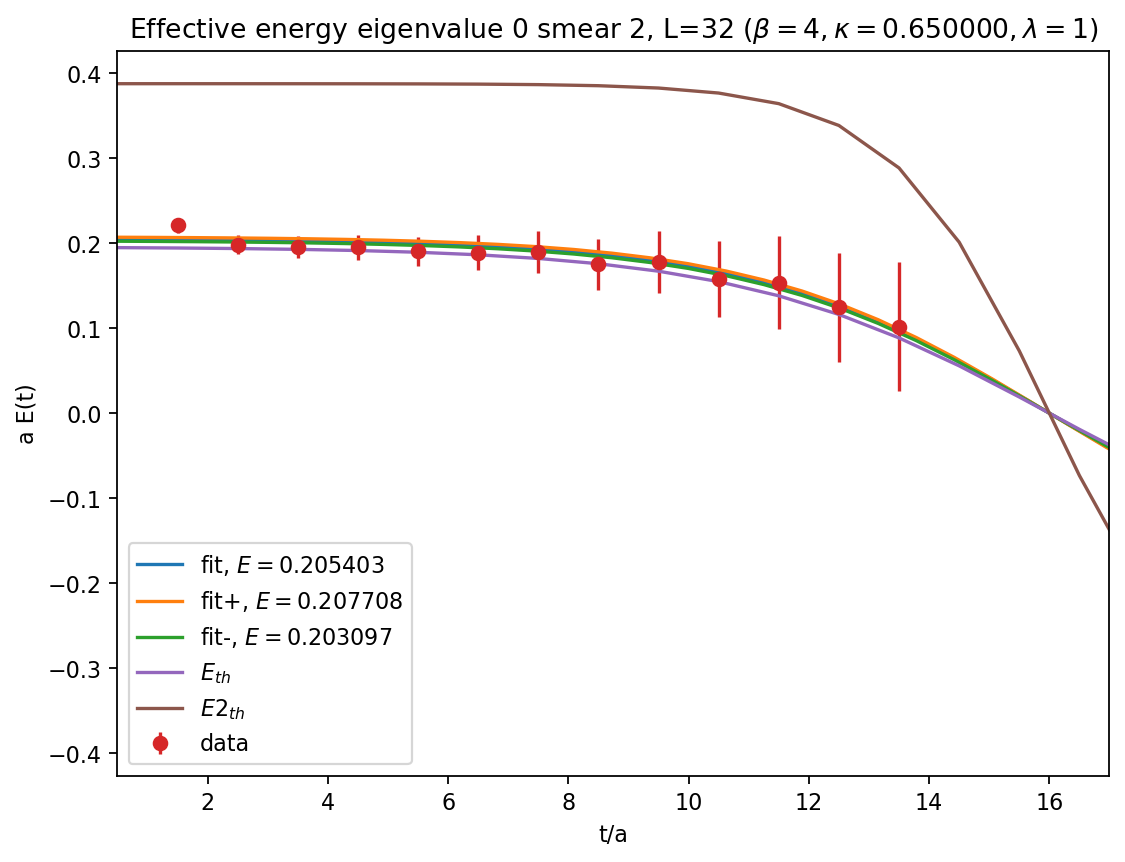

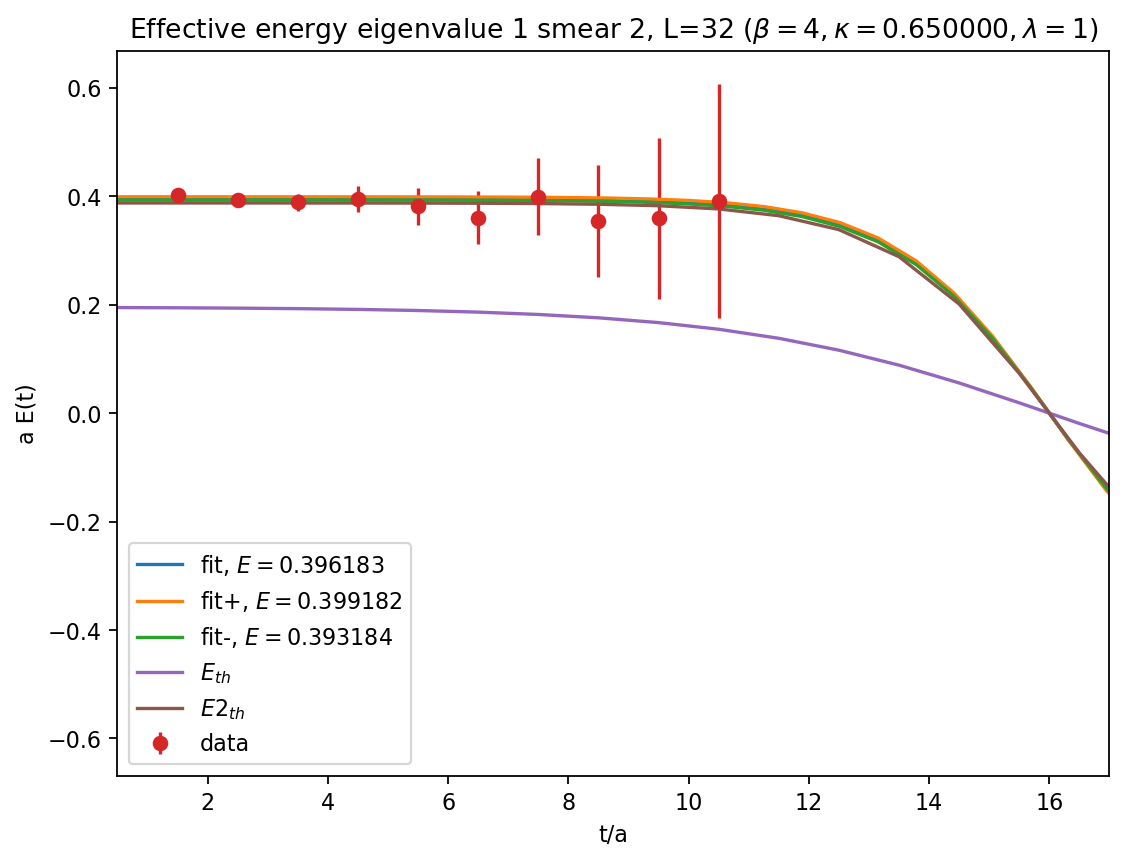

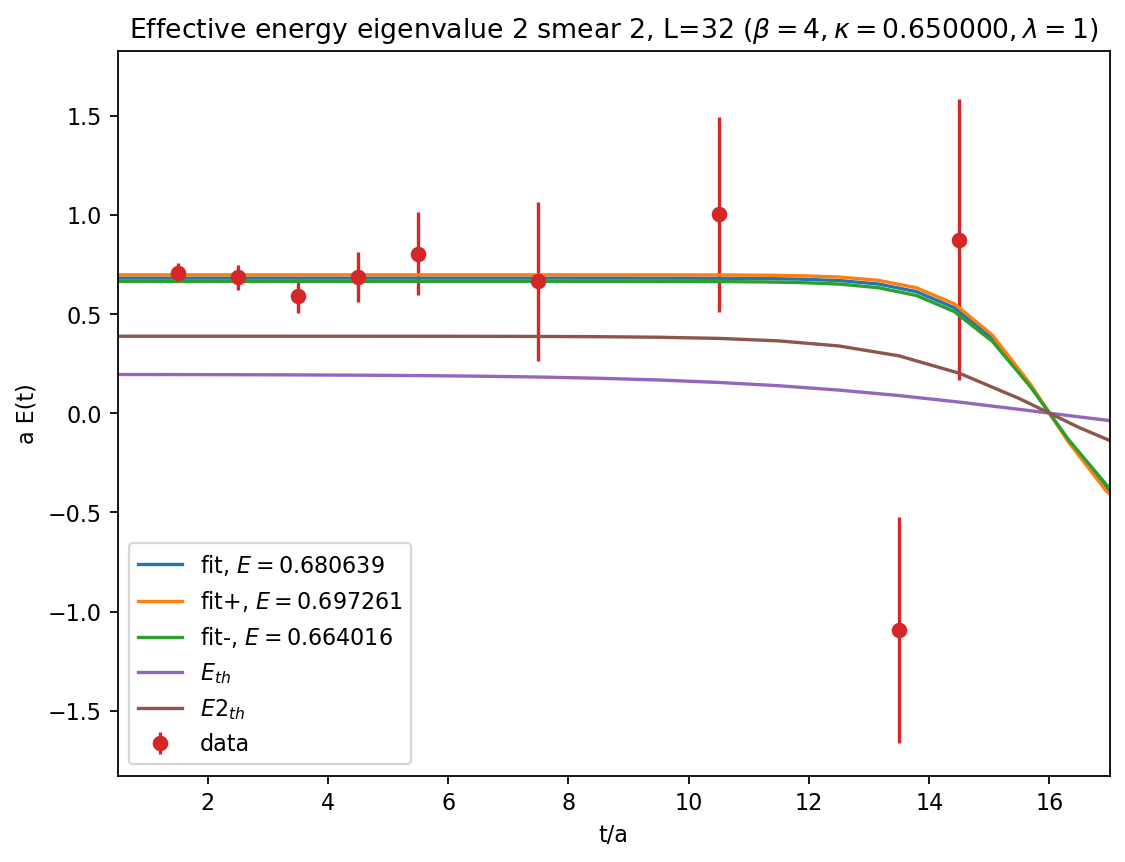

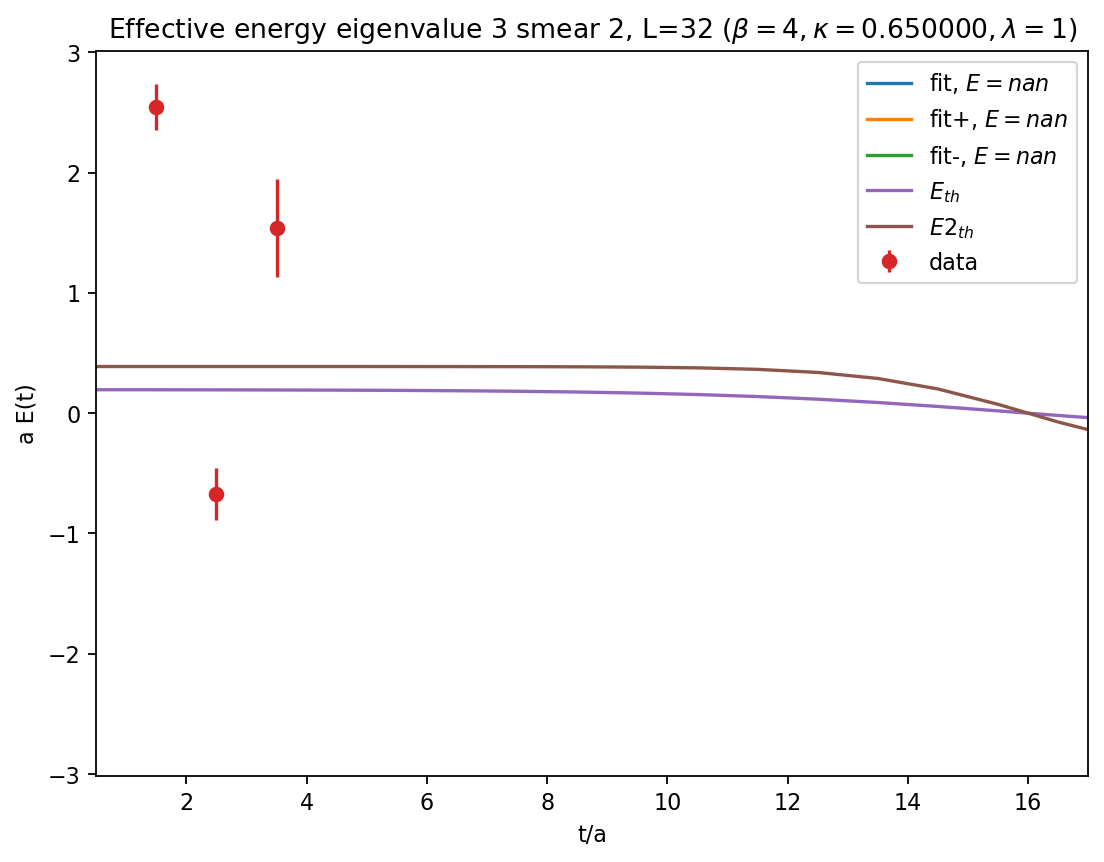

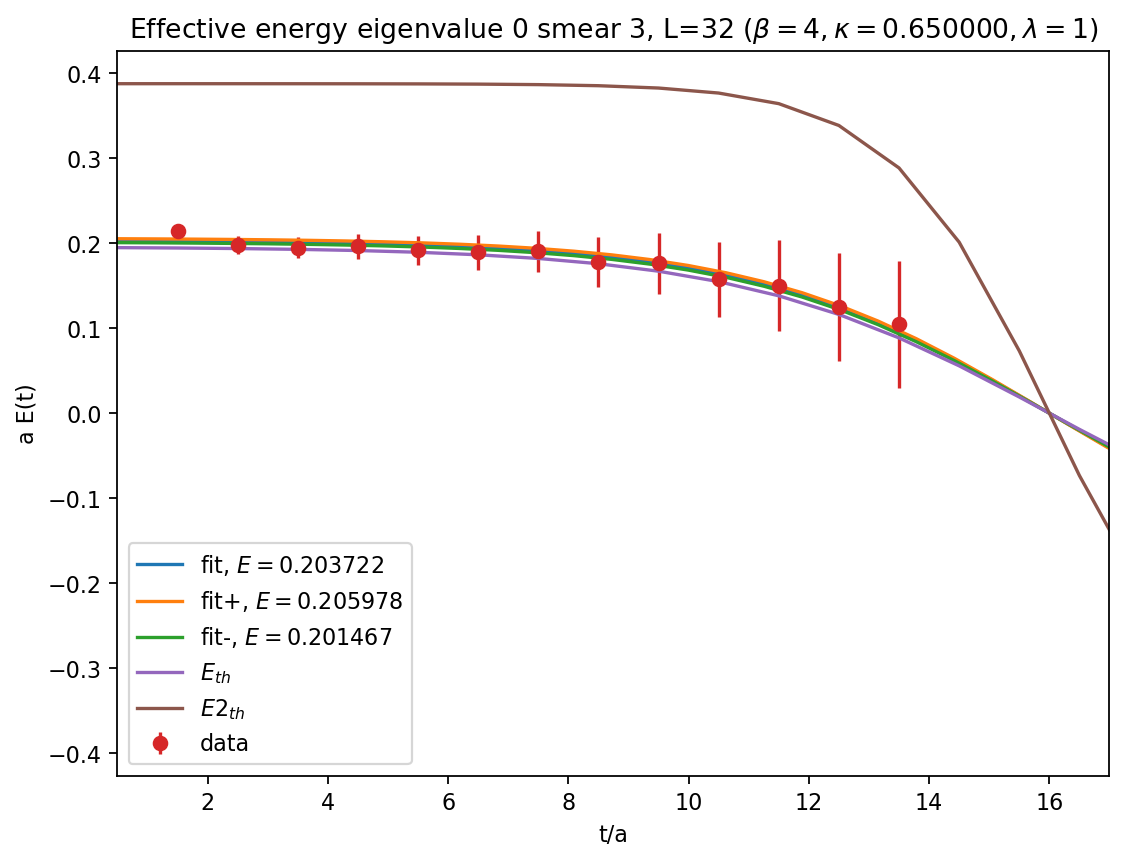

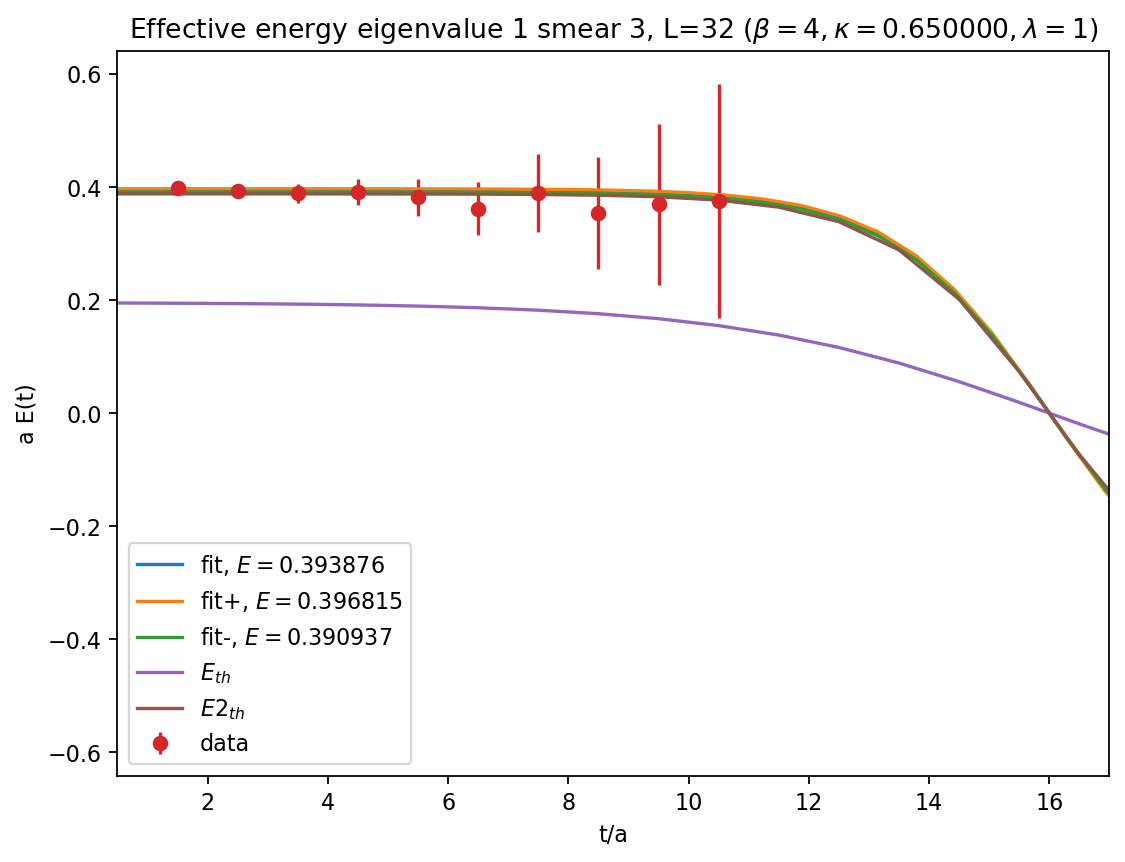

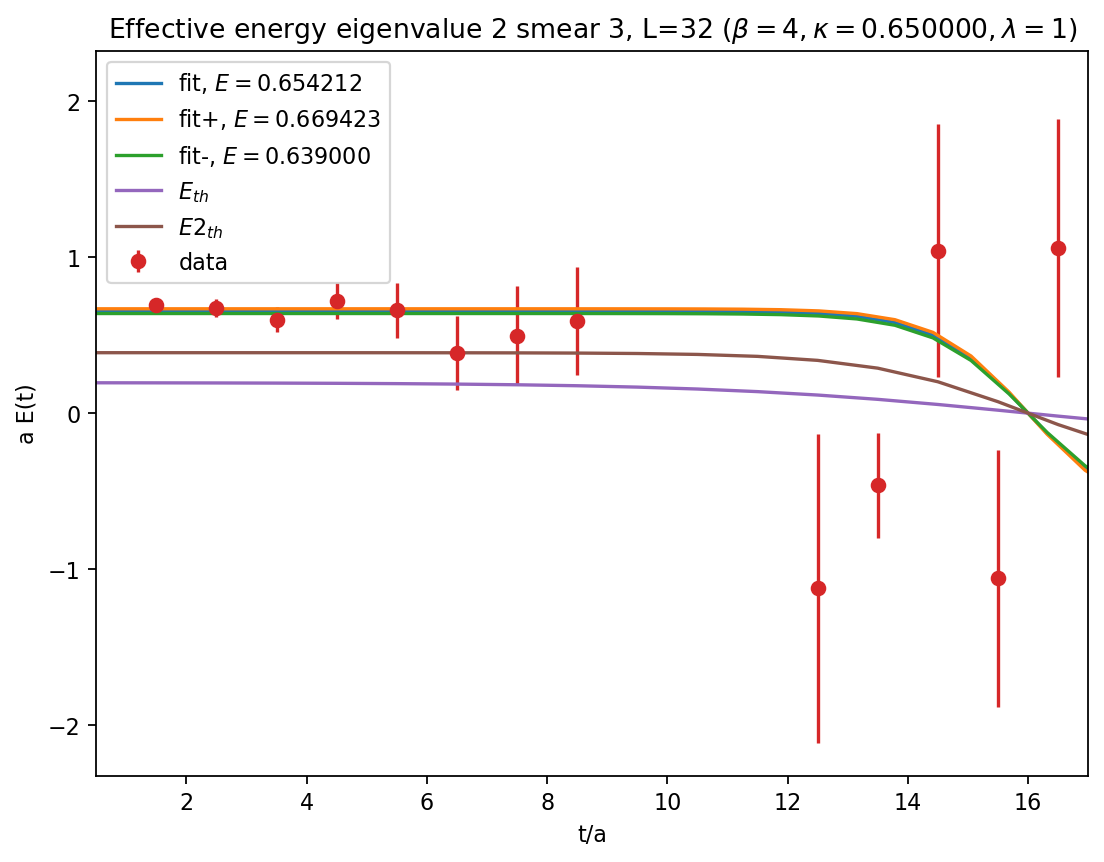

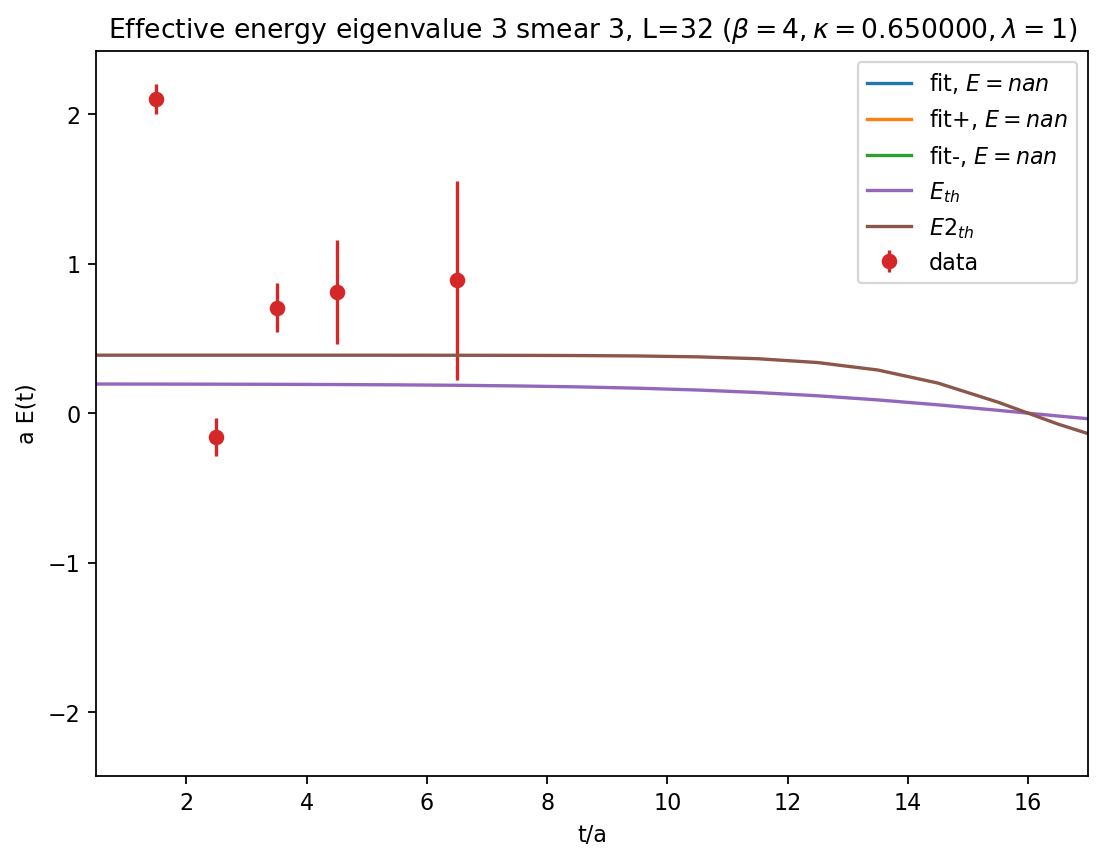

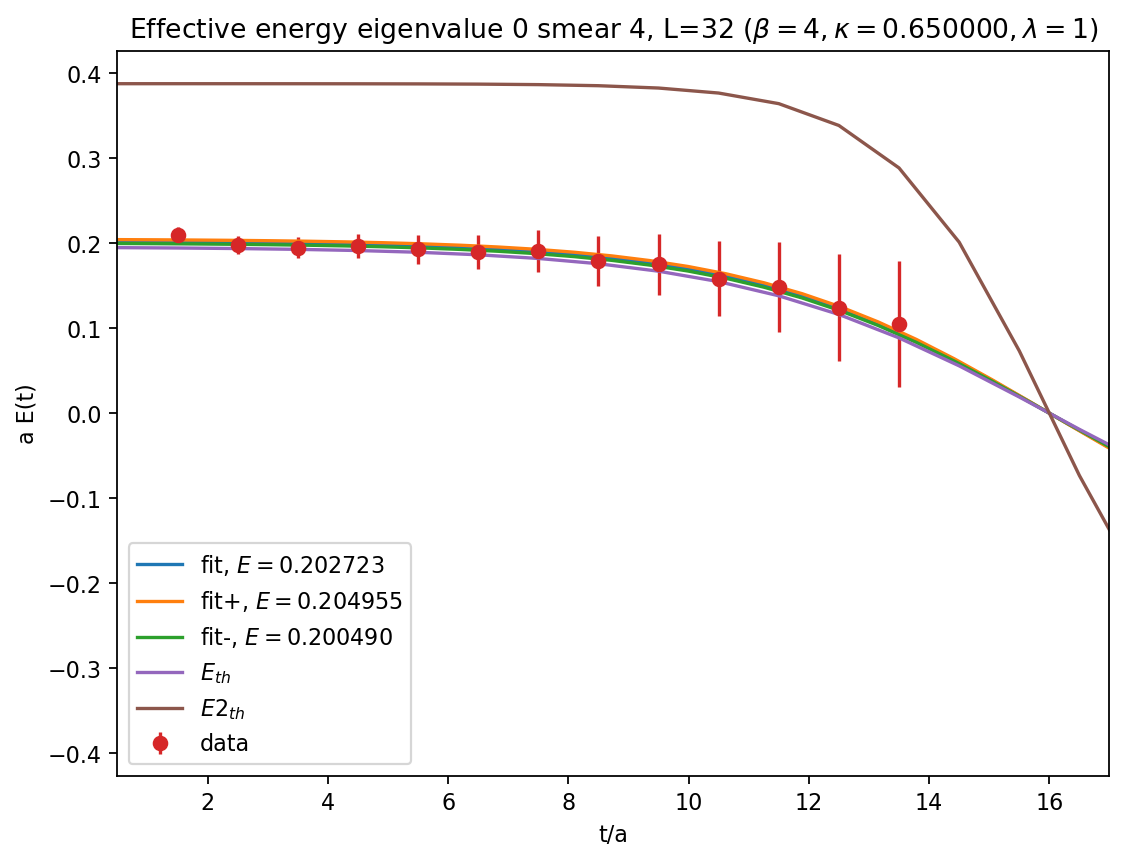

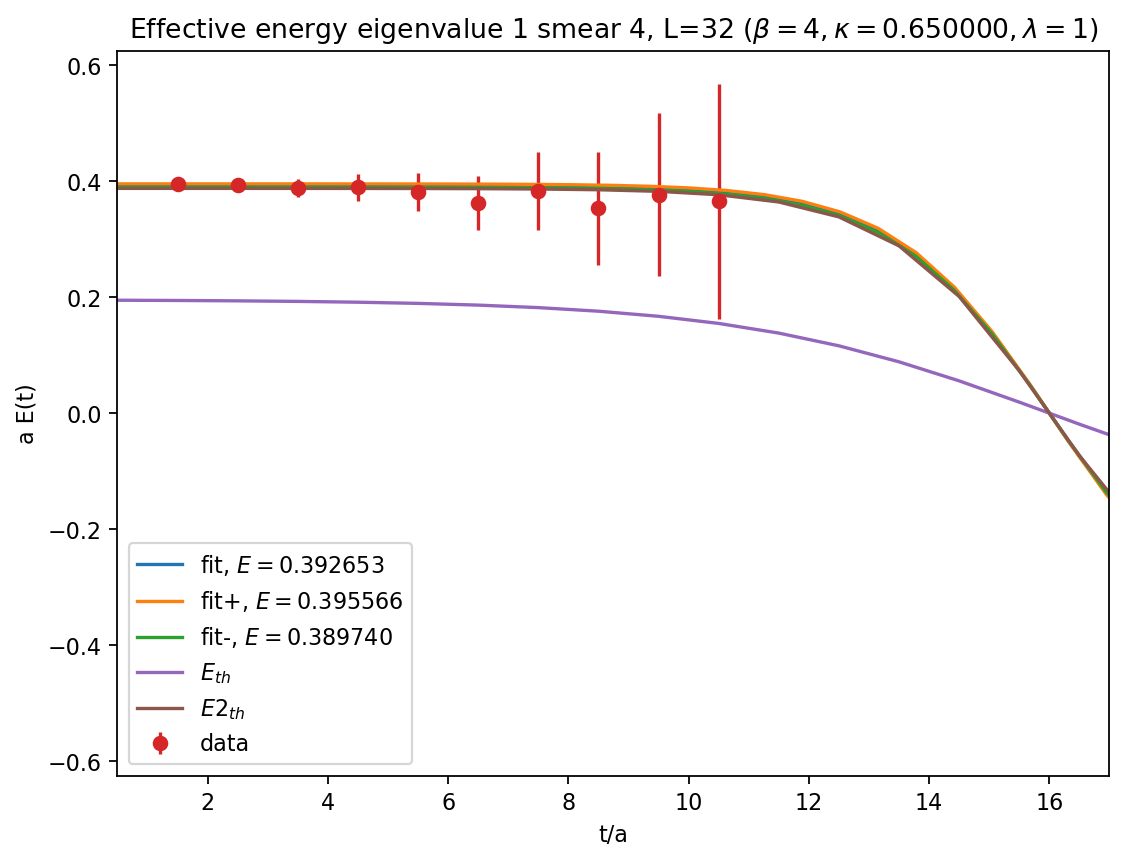

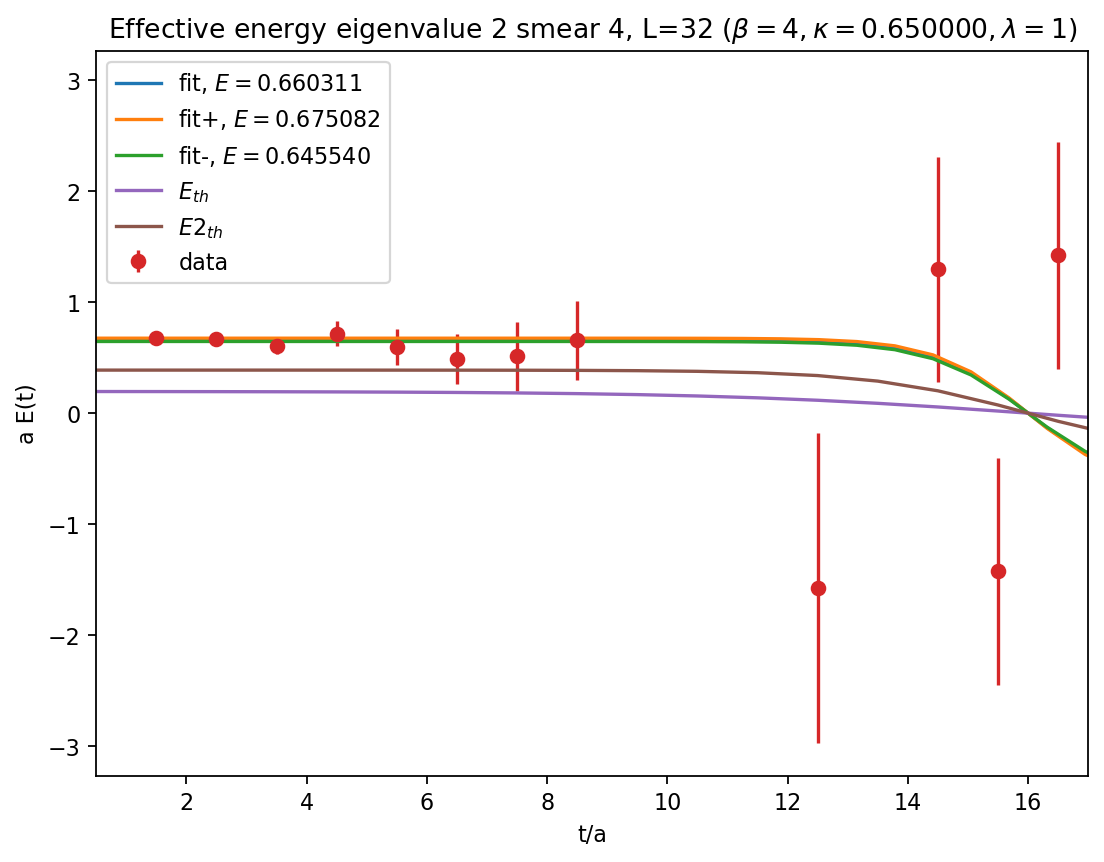

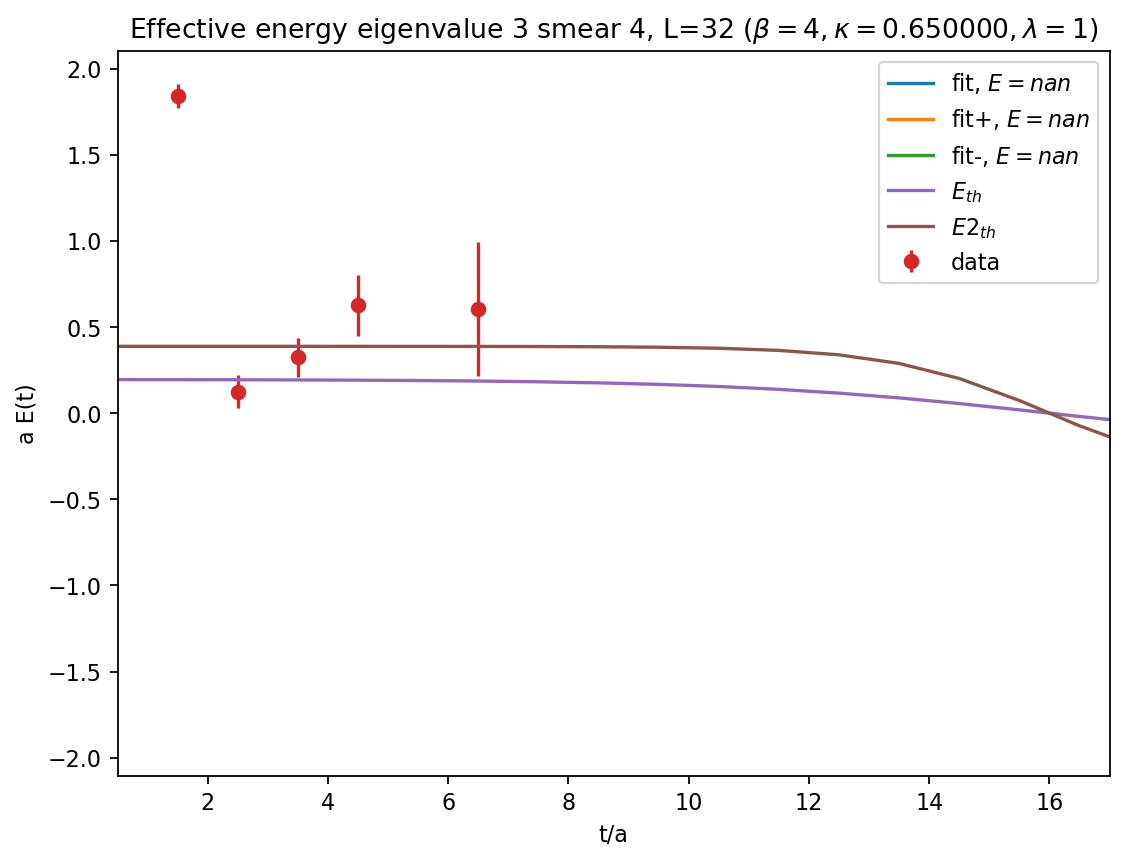

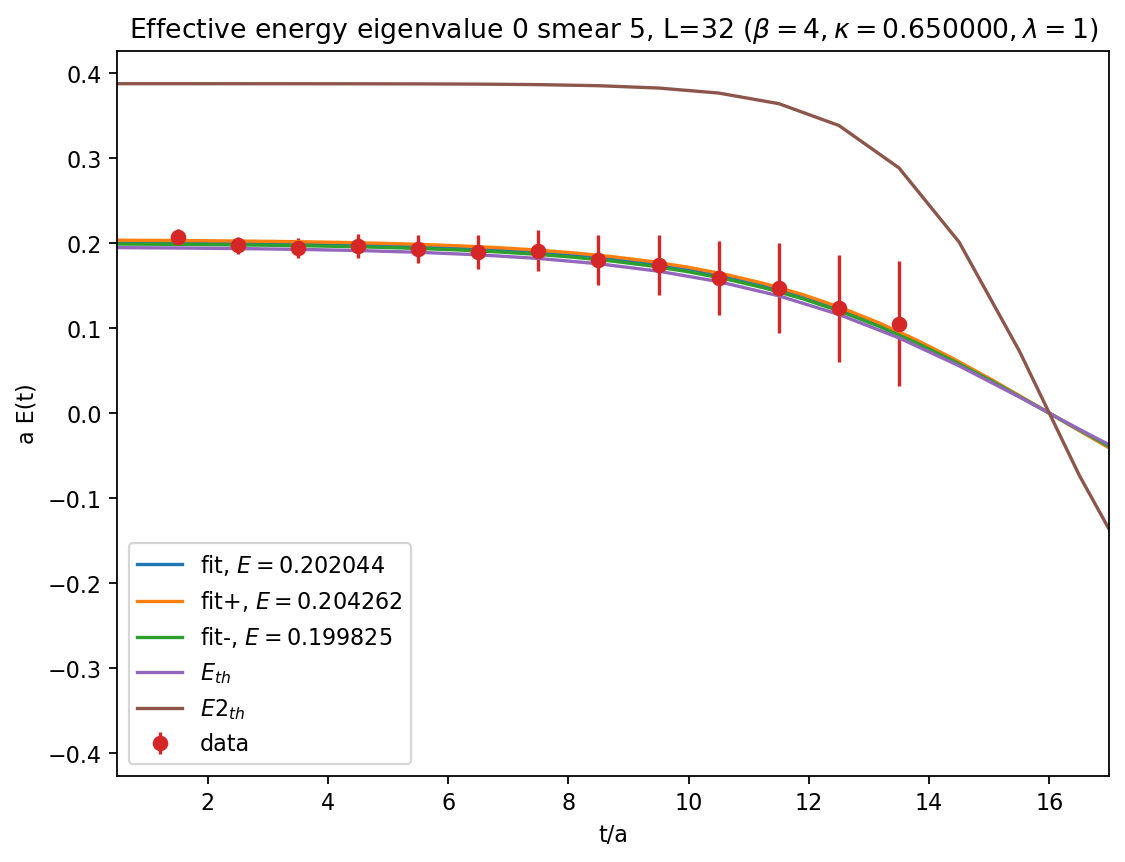

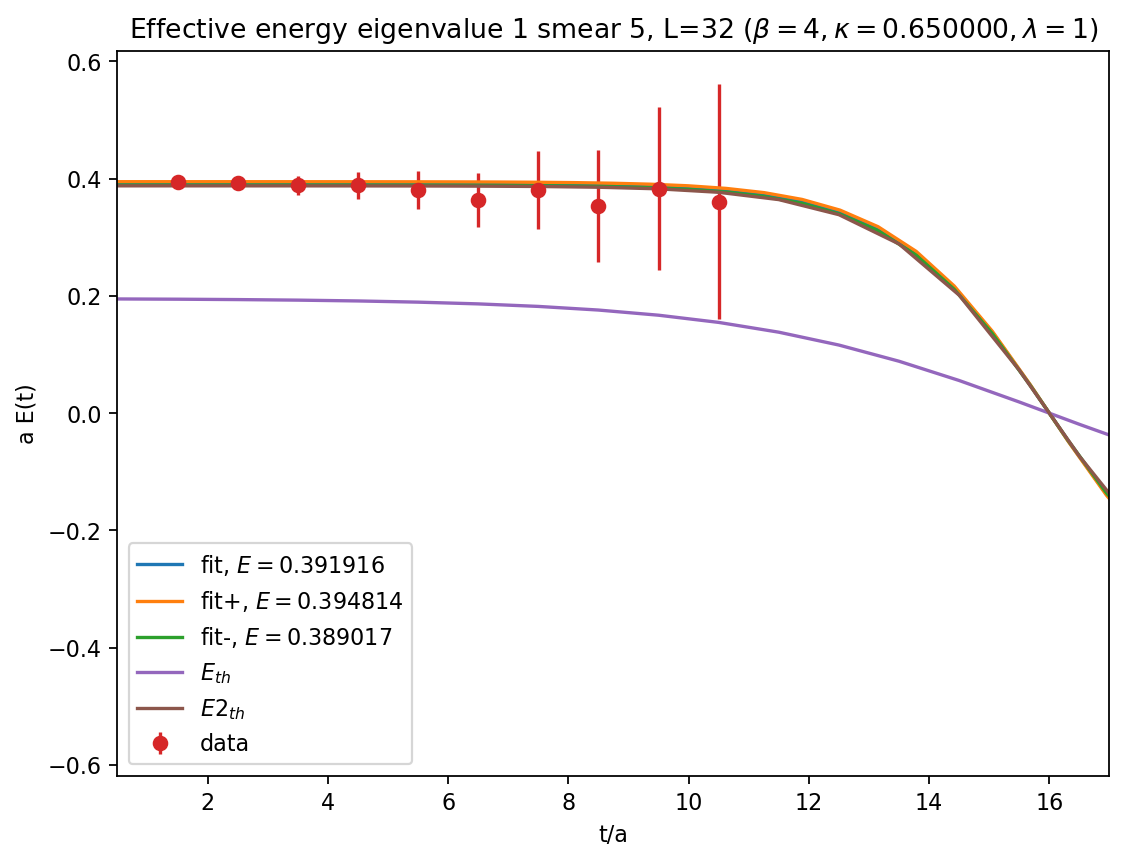

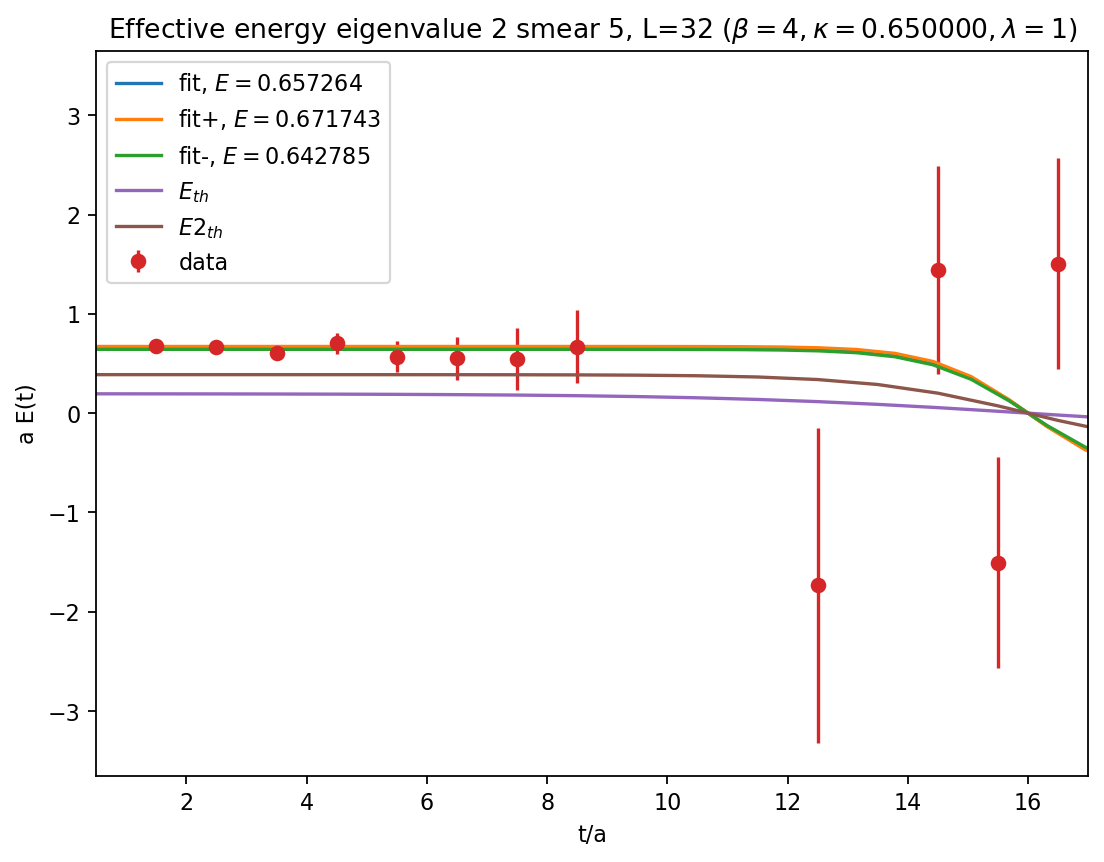

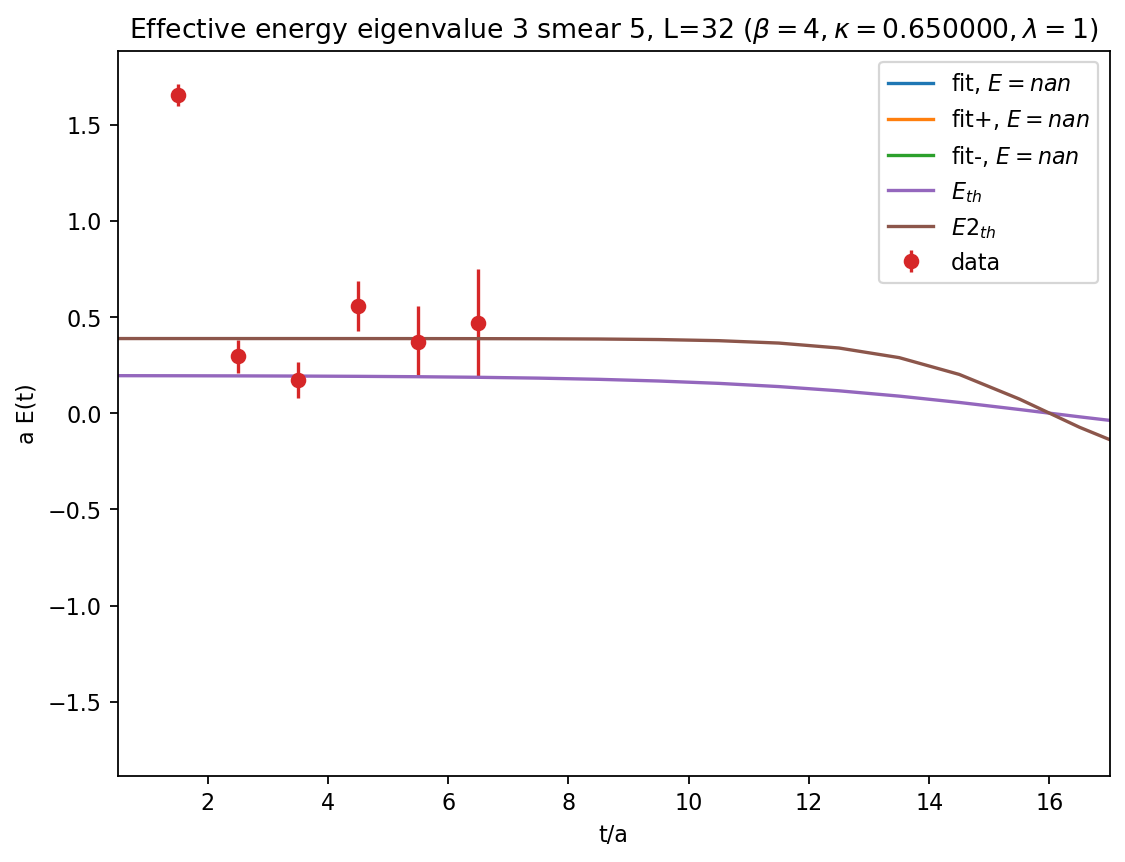

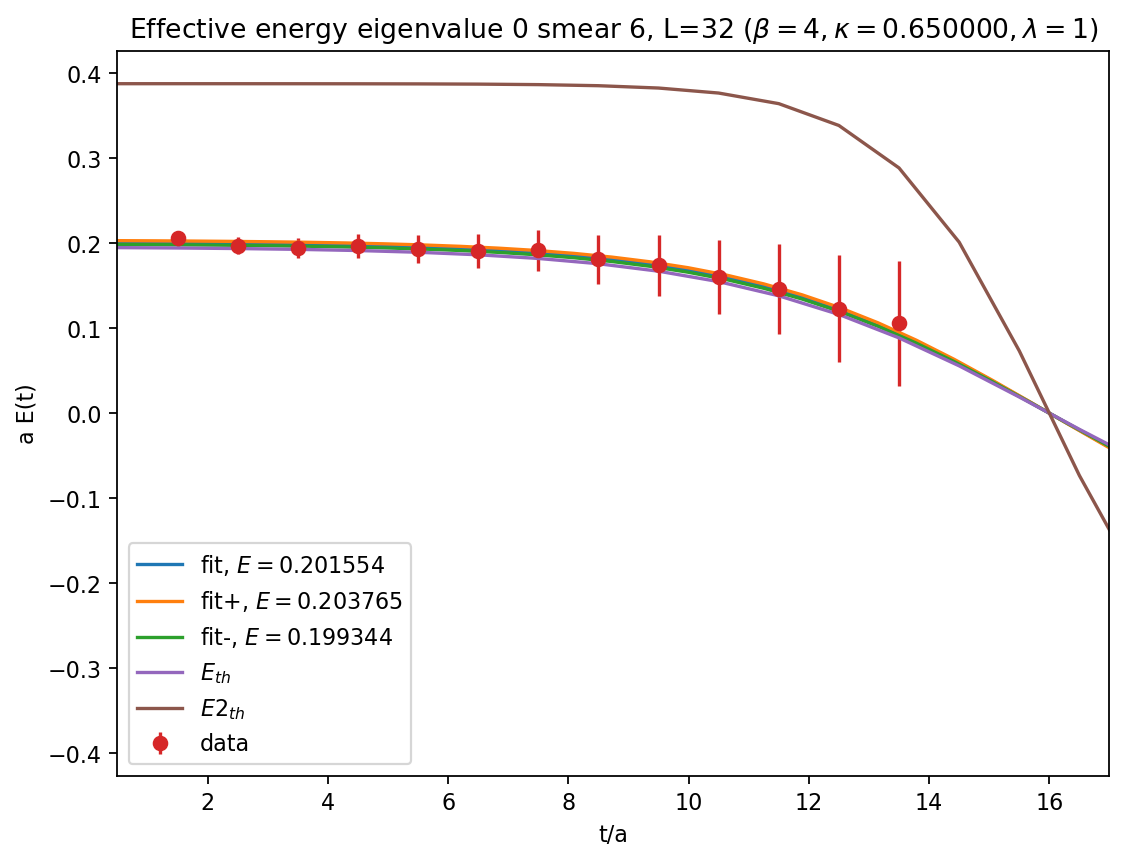

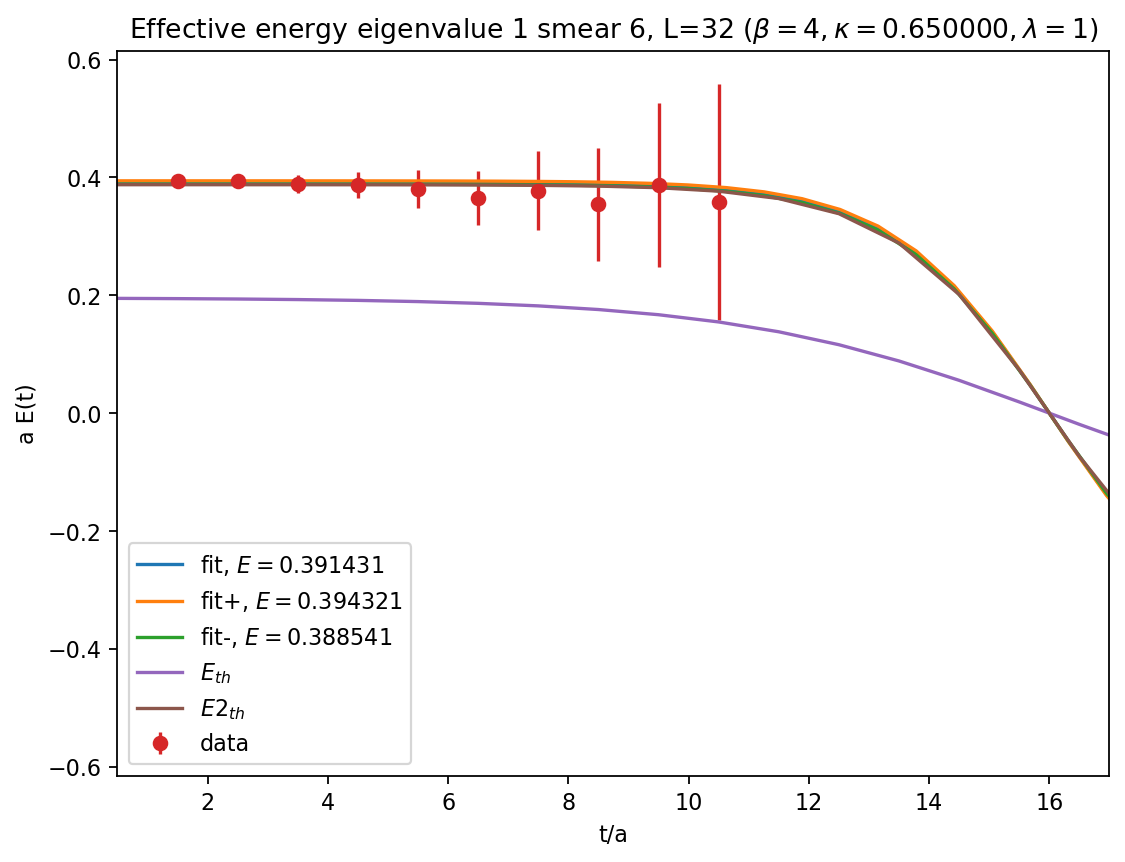

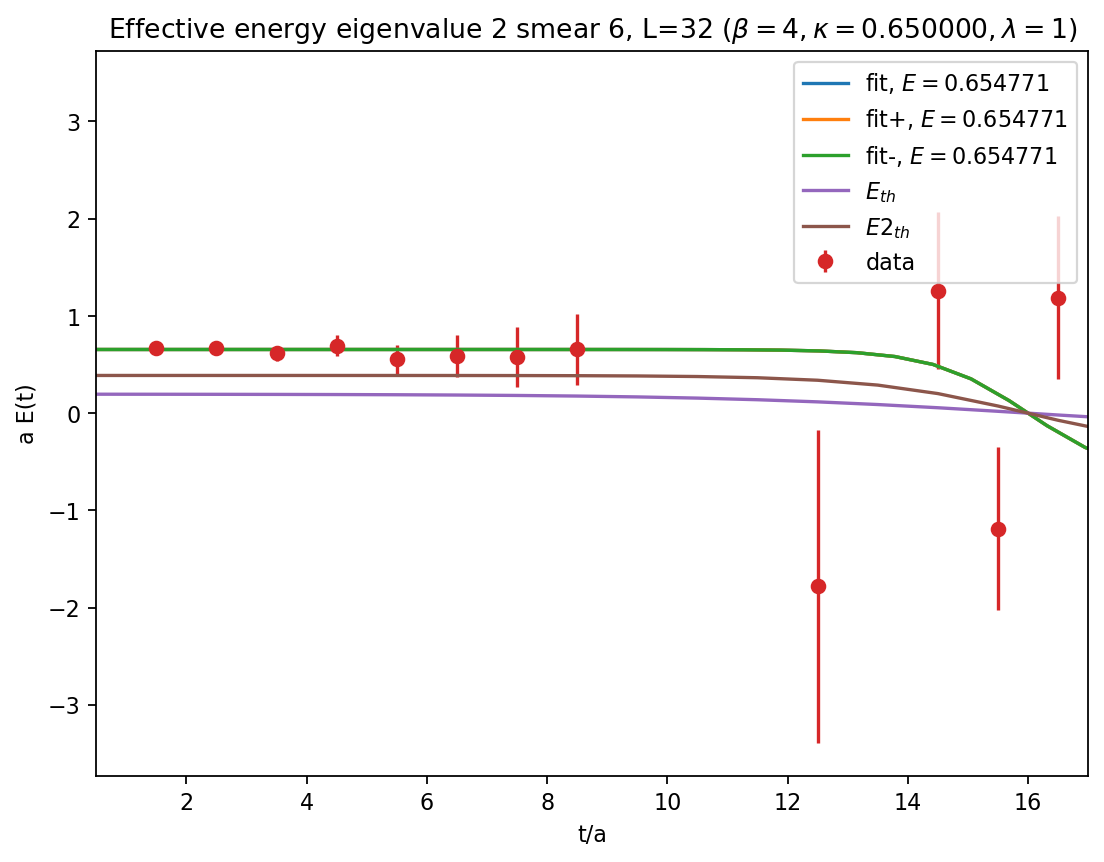

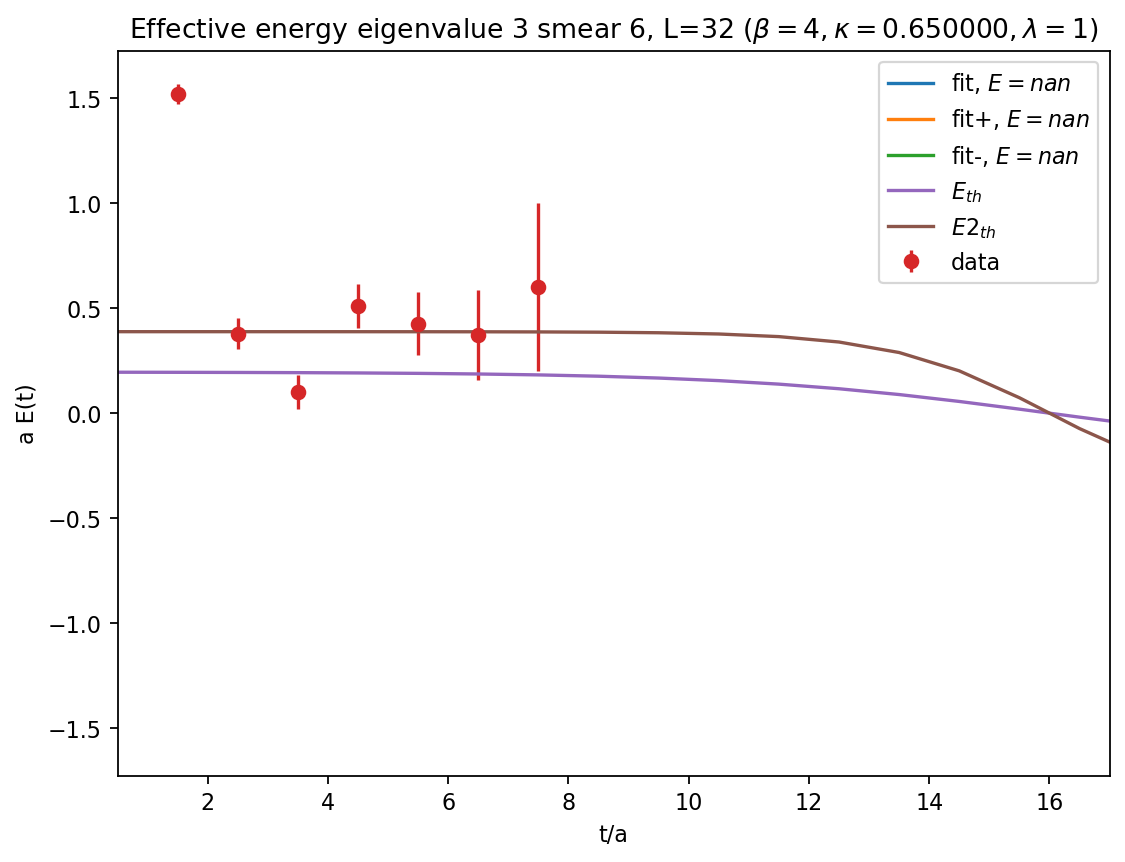

In [84]:
n_smear=7
for Nt in [32]:
    for k in [0.55,0.65]:
        for sm in range(n_smear):
            var_analysis_plot4(k,sm)

In [ ]:
n_smear=6
for Nt in [8]:
    for k in [0.55]:
        for sm in range(n_smear):
            for op in range(n_op):
                var_analysis_plot3(k,sm,op)